In [24]:
from model import TMapper, PhiMapper, OmegaMapper, UnbalancedLoss, UnbalancedSampler
import torch
from collections import Counter
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from model import Hellinger_dual, Jensen_Shannon_dual, KL_dual, Pearson_xi_dual

In [26]:
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

In [27]:
dataset1 = torch.utils.data.TensorDataset(*torch.load('./unbalanced_mnist_1'))
dataset2 = torch.utils.data.TensorDataset(*torch.load('./unbalanced_mnist_2'))

In [28]:
dl_1 = torch.utils.data.DataLoader(dataset1, batch_size=400)
dl_2 = torch.utils.data.DataLoader(dataset2, batch_size=400)

In [29]:
Counter(dataset1.tensors[1].tolist())

Counter({3: 3994,
         0: 4007,
         5: 1983,
         1: 3918,
         8: 1965,
         6: 2033,
         4: 4060,
         2: 4051,
         9: 1961,
         7: 2028})

In [30]:
Counter(dataset2.tensors[1].tolist())

Counter({5: 4077,
         7: 3969,
         6: 3895,
         9: 4080,
         8: 3941,
         2: 2045,
         1: 1966,
         3: 2007,
         4: 2010,
         0: 2010})

In [31]:
def cost_matrix(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return torch.norm(x[:, None] - y, dim=2, p=2)**2

def mass_variation_Pearson(s):
    return (s - 1)**2

def mass_variation_KL(s):
    return s * torch.log(s) - s + 1

In [32]:
cuda=True

In [33]:
in_dim = 64
out_dim = 64

if cuda:
    T = TMapper(in_dim, out_dim, hidden_dims=128).float().cuda()
    Xi = PhiMapper(in_dim, 1, hidden_dims=128).float().cuda()
    f = OmegaMapper(out_dim, 1, hidden_dims=128).float().cuda()
else:
    T = TMapper(in_dim, out_dim, hidden_dims=128).float()
    Xi = PhiMapper(in_dim, 1, hidden_dims=128).float()
    f = OmegaMapper(out_dim, 1, hidden_dims=128).float()

loss = UnbalancedLoss(1./30000, 1./30000, cost_matrix, mass_variation_KL, KL_dual)
w_optim = torch.optim.Adam(f.parameters(), lr=1e-4)
t_optim = torch.optim.Adam(T.parameters(), lr=1e-4)
xi_optim = torch.optim.Adam(Xi.parameters(), lr=1e-4)

In [34]:
def train_loop(data_loader_1: torch.utils.data.DataLoader, data_loader_2: torch.utils.data.DataLoader, cuda=cuda):
    loss_value_1 = []
    loss_value_2 = []
    for i in tqdm_notebook(range(1000)):
        for (X, Z_1), (Y, Z) in zip(data_loader_1, data_loader_2):

            if cuda:
                X = X.float().cuda()
              #  print(X.size())
                Y = Y.float().cuda()
              #  print(Y.size())
                Z = Z.float().cuda()
               # print(Z.size())
                
            else:
                X = X.float()
                Y = Y.float()
                Z = Z.float()
                
            w_optim.zero_grad()
            t_optim.zero_grad()
            xi_optim.zero_grad()
            
            T_output = T(X, Z.view(-1, 1))
            Xi_output = Xi(X)
            f_y = f(Y)
            f_T = f(T_output)
            
            if i % 10 == 0:
                loss_value = -loss.compute(X, Z, Y, T_output, Xi_output, f_y, f_T, verbose=True)
            else:
                loss_value = -loss.compute(X, Z, Y, T_output, Xi_output, f_y, f_T)
            loss_value_1.append(loss_value.item())
        #    print('-loss value {}'.format(loss_value))
            loss_value.backward(retain_graph=True)
            w_optim.step()

            t_optim.zero_grad()
            xi_optim.zero_grad()
            
            f_y = f(Y)
            f_T = f(T_output)
            
            loss_value = loss.compute(X, Z, Y, T_output, Xi_output, f_y, f_T)
            loss_value_2.append(loss_value.item())
         #   print('loss value {}'.format(loss_value))
            loss_value.backward()
            t_optim.step()
            xi_optim.step()            
        if i % 10 == 0:
            print('epoch {}'.format(i))
            print(loss_value_1[-1])
            print(loss_value_2[-1])
    return loss_value_1, loss_value_2

In [35]:
lv1, lv2 = train_loop(dl_1, dl_2)

Mass variation output 0.05874081328511238
Distance function output 3.7550690174102783
Dual function output 0.9482139348983765
Terms:
First 8.48738054628484e-05
Second 1.9580270418373402e-06
Third -9.09941149984661e-07
Fourth -3.1607130949851125e-05
Mass variation output 0.05907050892710686
Distance function output 3.7390952110290527
Dual function output 0.9473254084587097
Terms:
First 8.440346573479474e-05
Second 1.9690169210662134e-06
Third -9.203719741890382e-07
Fourth -3.157751416438259e-05
Mass variation output 0.059604156762361526
Distance function output 3.697333574295044
Dual function output 0.9463567733764648
Terms:
First 8.325724047608674e-05
Second 1.9868052731908392e-06
Third -9.315002102994185e-07
Fourth -3.154522710246965e-05
Mass variation output 0.059885960072278976
Distance function output 3.6620142459869385
Dual function output 0.945013701915741
Terms:
First 8.238665759563446e-05
Second 1.99619853447075e-06
Third -9.442568966733234e-07
Fourth -3.150045813526958e-05
Mas

Mass variation output 0.07939731329679489
Distance function output 3.759350299835205
Dual function output 0.8972371220588684
Terms:
First 7.855275907786563e-05
Second 2.6465770588401938e-06
Third -1.412131837241759e-06
Fourth -2.9907905627624132e-05
Mass variation output 0.07989663630723953
Distance function output 3.606386184692383
Dual function output 0.8949807286262512
Terms:
First 7.517300400650129e-05
Second 2.663221039256314e-06
Third -1.4273670103648328e-06
Fourth -2.9832694053766318e-05
Mass variation output 0.08084665238857269
Distance function output 3.7771244049072266
Dual function output 0.8921550512313843
Terms:
First 7.846546941436827e-05
Second 2.6948882805299945e-06
Third -1.4403217392100487e-06
Fourth -2.9738503144471906e-05
Mass variation output 0.08146417140960693
Distance function output 3.752063274383545
Dual function output 0.8924665451049805
Terms:
First 7.776507845846936e-05
Second 2.715472191994195e-06
Third -1.4548713807016611e-06
Fourth -2.974888775497675e-05

Mass variation output 0.1143229678273201
Distance function output 3.7221033573150635
Dual function output 0.8156079649925232
Terms:
First 6.880824366817251e-05
Second 3.81076529265556e-06
Third -1.8827698795575998e-06
Fourth -2.7186930310563184e-05
Mass variation output 0.11525669693946838
Distance function output 3.6397218704223633
Dual function output 0.8137815594673157
Terms:
First 6.72204841976054e-05
Second 3.841890247713309e-06
Third -1.8964748278449406e-06
Fourth -2.7126054192194715e-05
Mass variation output 0.11780174821615219
Distance function output 3.9172842502593994
Dual function output 0.8084127902984619
Terms:
First 7.168242882471532e-05
Second 3.926725185010582e-06
Third -1.9011806671187514e-06
Fourth -2.694708928174805e-05
epoch 0
-4.6760884288232774e-05
4.684273153543472e-05
Mass variation output 0.8889257907867432
Distance function output 3.7123913764953613
Dual function output 0.005224661901593208
Terms:
First 2.040052095253486e-06
Second 2.9630860808538273e-05
Third

Mass variation output 0.903925895690918
Distance function output 3.787372589111328
Dual function output 0.0035590517800301313
Terms:
First 1.7833882566264947e-06
Second 3.0130864615784958e-05
Third 8.808721077002701e-07
Fourth -1.1863505733344937e-07
Mass variation output 0.8965904712677002
Distance function output 3.6600546836853027
Dual function output 0.004517844878137112
Terms:
First 1.821062141971197e-06
Second 2.9886350603192113e-05
Third 9.777280638445518e-07
Fourth -1.505948148405878e-07
Mass variation output 0.8987996578216553
Distance function output 3.672037124633789
Dual function output 0.004526523407548666
Terms:
First 1.8205284959549317e-06
Second 2.9959990570205264e-05
Third 9.481743745709537e-07
Fourth -1.5088411942087987e-07
Mass variation output 0.8986499309539795
Distance function output 3.7383878231048584
Dual function output 0.004834762774407864
Terms:
First 1.7860614889286808e-06
Second 2.995499744429253e-05
Third 9.648870218370575e-07
Fourth -1.6115878054279165e-

Mass variation output 0.910828709602356
Distance function output 3.7124972343444824
Dual function output 0.0038285439368337393
Terms:
First 1.5334377394538024e-06
Second 3.0360959499375895e-05
Third 9.404674301549676e-07
Fourth -1.2761813650286058e-07
Mass variation output 0.9048680663108826
Distance function output 3.6776421070098877
Dual function output 0.0039752572774887085
Terms:
First 1.54484155245882e-06
Second 3.0162269467837177e-05
Third 1.041687823999382e-06
Fourth -1.325085605685672e-07
Mass variation output 0.9051968455314636
Distance function output 3.5946221351623535
Dual function output 0.005668746307492256
Terms:
First 1.6014311086109956e-06
Second 3.0173225241014734e-05
Third 1.0212062306891312e-06
Fourth -1.8895821085607167e-07
Mass variation output 0.9131584167480469
Distance function output 3.870072603225708
Dual function output 0.003194171003997326
Terms:
First 1.481373374190298e-06
Second 3.0438612157013267e-05
Third 9.329507406619086e-07
Fourth -1.0647237758121264

Mass variation output 0.9845631718635559
Distance function output 3.4228644371032715
Dual function output 0.00043867542990483344
Terms:
First 1.274995184985528e-07
Second 3.281877434346825e-05
Third 3.496149645343394e-07
Fourth -1.4622514754591975e-08
Mass variation output 0.9886303544044495
Distance function output 3.6490886211395264
Dual function output 0.00035203821607865393
Terms:
First 1.0619125845323651e-07
Second 3.295434362371452e-05
Third 2.3857737119215017e-07
Fourth -1.1734607063829117e-08
Mass variation output 0.986488938331604
Distance function output 3.5273351669311523
Dual function output 0.0006000432185828686
Terms:
First 1.1752036499501628e-07
Second 3.2882962841540575e-05
Third 2.9636760245921323e-07
Fourth -2.0001438727490495e-08
Mass variation output 0.987313449382782
Distance function output 3.539858102798462
Dual function output 0.0006908744690008461
Terms:
First 1.1468720373386532e-07
Second 3.291044777142815e-05
Third 2.750651333371934e-07
Fourth -2.302914836604

Distance function output 3.5137815475463867
Dual function output 0.0005891807377338409
Terms:
First 1.1252890885771194e-07
Second 3.287013896624558e-05
Third 3.158554875426489e-07
Fourth -1.9639356807488184e-08
Mass variation output 0.9893633723258972
Distance function output 3.7930541038513184
Dual function output 0.0004307177441660315
Terms:
First 9.210393869807376e-08
Second 3.2978779927361757e-05
Third 2.3096620793694456e-07
Fourth -1.4357259381370113e-08
Mass variation output 0.9883540272712708
Distance function output 3.6562225818634033
Dual function output 0.0009712993633002043
Terms:
First 1.007242431683153e-07
Second 3.294513589935377e-05
Third 2.543337700444681e-07
Fourth -3.237664358834991e-08
Mass variation output 0.9883100390434265
Distance function output 3.5693273544311523
Dual function output 0.0008380684885196388
Terms:
First 1.0166460384652964e-07
Second 3.2943669793894514e-05
Third 2.516341623959306e-07
Fourth -2.7935618263086326e-08
Mass variation output 0.986087381

Mass variation output 0.9925022125244141
Distance function output 3.5089054107666016
Dual function output 0.00010869649850064889
Terms:
First 5.253734869370419e-08
Second 3.3083408197853714e-05
Third 1.6332751329173334e-07
Fourth -3.623216837667087e-09
Mass variation output 0.9912086129188538
Distance function output 3.3170788288116455
Dual function output 0.00012957639410160482
Terms:
First 5.837653560547551e-08
Second 3.304029087303206e-05
Third 2.0885181584162638e-07
Fourth -4.319213431358548e-09
Mass variation output 0.9938140511512756
Distance function output 3.545942544937134
Dual function output 0.00010032380669144914
Terms:
First 4.699635169913563e-08
Second 3.3127140341093764e-05
Third 1.3329901094039087e-07
Fourth -3.3441271973799758e-09
Mass variation output 0.992420494556427
Distance function output 3.415131092071533
Dual function output 0.00020083197159692645
Terms:
First 5.383898837862944e-08
Second 3.30806833517272e-05
Third 1.7329631418760982e-07
Fourth -6.6943992571566

Mass variation output 0.9929671883583069
Distance function output 3.447687864303589
Dual function output 0.00011294787691440433
Terms:
First 5.163168381727701e-08
Second 3.3098905987571925e-05
Third 1.5493634464291972e-07
Fourth -3.764929257243921e-09
Mass variation output 0.9918656945228577
Distance function output 3.4213759899139404
Dual function output 0.00018407039169687778
Terms:
First 5.354697663051411e-08
Second 3.306218786747195e-05
Third 1.9422404307078978e-07
Fourth -6.135679520014037e-09
Mass variation output 0.9939283728599548
Distance function output 3.7082319259643555
Dual function output 0.00014076940715312958
Terms:
First 4.314007284733634e-08
Second 3.3130942028947175e-05
Third 1.3549698962833645e-07
Fourth -4.692313648746449e-09
Mass variation output 0.9933208227157593
Distance function output 3.581052303314209
Dual function output 0.00043936457950621843
Terms:
First 4.83938293882602e-08
Second 3.311069667688571e-05
Third 1.5345594306381827e-07
Fourth -1.4645484824882

Mass variation output 0.9964929223060608
Distance function output 3.421186685562134
Dual function output 5.875791248399764e-05
Terms:
First 2.028700407663564e-08
Second 3.321643089293502e-05
Third 8.93882869945628e-08
Fourth -1.958597062312606e-09
Mass variation output 0.9967893958091736
Distance function output 3.432121753692627
Dual function output 7.112474122550339e-05
Terms:
First 1.9192448519333993e-08
Second 3.3226311643375084e-05
Third 8.148226271487147e-08
Fourth -2.370824647712766e-09
Mass variation output 0.996557891368866
Distance function output 3.4645655155181885
Dual function output 0.0005121729336678982
Terms:
First 1.923042525220353e-08
Second 3.321859549032524e-05
Third 8.791368344418515e-08
Fourth -1.707243413306969e-08
Mass variation output 0.9961531758308411
Distance function output 3.4359662532806396
Dual function output 0.0018955369014292955
Terms:
First 2.004381194353755e-08
Second 3.3205105864908546e-05
Third 1.0430478170064816e-07
Fourth -6.318457224097074e-08


Mass variation output 0.9969736337661743
Distance function output 3.485954523086548
Dual function output 0.0001282120356336236
Terms:
First 1.7489236725509727e-08
Second 3.323245618958026e-05
Third 7.485854069955167e-08
Fourth -4.273734699467013e-09
Mass variation output 0.9960705637931824
Distance function output 3.4462671279907227
Dual function output 8.134960808092728e-05
Terms:
First 1.9603957568392616e-08
Second 3.320234827697277e-05
Third 1.0954594387158068e-07
Fourth -2.711653790399282e-09
Mass variation output 0.9966149926185608
Distance function output 3.3634109497070312
Dual function output 0.00031539902556687593
Terms:
First 1.932647997193726e-08
Second 3.322049815324135e-05
Third 8.592627409598208e-08
Fourth -1.0513299564252065e-08
Mass variation output 0.9968253970146179
Distance function output 3.615124225616455
Dual function output 3.290433232905343e-05
Terms:
First 1.7555196407670337e-08
Second 3.3227512176381424e-05
Third 8.315702615391274e-08
Fourth -1.096810975376172

Mass variation output 0.9980869889259338
Distance function output 3.463002920150757
Dual function output 1.23558293125825e-05
Terms:
First 9.10692143918368e-09
Second 3.3269567211391404e-05
Third 4.899057515217464e-08
Fourth -4.118609620018532e-10
Mass variation output 0.9976949691772461
Distance function output 3.2700209617614746
Dual function output 1.666827120061498e-05
Terms:
First 1.0173241804523059e-08
Second 3.325649959151633e-05
Third 6.343424985288948e-08
Fourth -5.556090032499128e-10
Mass variation output 0.9985621571540833
Distance function output 3.502955675125122
Dual function output 1.3761403351963963e-05
Terms:
First 7.583213168516068e-09
Second 3.328540697111748e-05
Third 3.602685083592405e-08
Fourth -4.587134838640594e-10
Mass variation output 0.9981077313423157
Distance function output 3.367319345474243
Dual function output 2.6685227567213587e-05
Terms:
First 9.33574995087838e-09
Second 3.327025842736475e-05
Third 4.951088428128969e-08
Fourth -8.895075231940552e-10
Ma

Mass variation output 0.9983134269714355
Distance function output 3.3940181732177734
Dual function output 1.514194536866853e-05
Terms:
First 8.628057379667098e-09
Second 3.327711237943731e-05
Third 4.194885860897557e-08
Fourth -5.04731589856533e-10
Mass variation output 0.9978657960891724
Distance function output 3.360992908477783
Dual function output 2.2825319319963455e-05
Terms:
First 9.394611311108747e-09
Second 3.326219302834943e-05
Third 5.812351488998502e-08
Fourth -7.60844054426002e-10
Mass variation output 0.9984999895095825
Distance function output 3.6590468883514404
Dual function output 1.4949848264222965e-05
Terms:
First 7.261829804150466e-09
Second 3.328333332319744e-05
Third 3.8421536174837456e-08
Fourth -4.983283230508562e-10
Mass variation output 0.9983475804328918
Distance function output 3.522444725036621
Dual function output 5.064929791842587e-05
Terms:
First 8.318818522923266e-09
Second 3.327825470478274e-05
Third 4.29133706347784e-08
Fourth -1.6883100473208401e-09
M

Mass variation output 0.9987797141075134
Distance function output 3.365813970565796
Dual function output 1.5184525182121433e-05
Terms:
First 5.559942728439182e-09
Second 3.3292657462880015e-05
Third 3.232731415891976e-08
Fourth -5.061508434600626e-10
Mass variation output 0.998898446559906
Distance function output 3.3804702758789062
Dual function output 1.7848700736067258e-05
Terms:
First 5.181863382830443e-09
Second 3.329661558382213e-05
Third 2.9198931272844675e-08
Fourth -5.949566950214091e-10
Mass variation output 0.998798668384552
Distance function output 3.4206624031066895
Dual function output 0.00010994108743034303
Terms:
First 5.323219642860977e-09
Second 3.329329047119245e-05
Third 3.199082598825953e-08
Fourth -3.664703429606675e-09
Mass variation output 0.9985606670379639
Distance function output 3.377108573913574
Dual function output 0.00073985755443573
Terms:
First 5.604711361684167e-09
Second 3.328535603941418e-05
Third 4.163256761557932e-08
Fourth -2.4661918729407262e-08


Mass variation output 0.9989332556724548
Distance function output 3.520911693572998
Dual function output 2.817308995872736e-05
Terms:
First 4.956161703262296e-09
Second 3.3297772461082786e-05
Third 2.810469545977412e-08
Fourth -9.391030175720516e-10
Mass variation output 0.9989437460899353
Distance function output 3.4296624660491943
Dual function output 2.4975419364636764e-05
Terms:
First 4.785380980365517e-09
Second 3.3298125345027074e-05
Third 2.7365636867671128e-08
Fourth -8.325140021803179e-10
Mass variation output 0.9985174536705017
Distance function output 3.394704580307007
Dual function output 1.91335566341877e-05
Terms:
First 5.632354138640494e-09
Second 3.3283915399806574e-05
Third 4.330783909267666e-08
Fourth -6.377852690420127e-10
Mass variation output 0.9988116025924683
Distance function output 3.3125650882720947
Dual function output 6.742610275978222e-05
Terms:
First 5.407945646851431e-09
Second 3.329372339067049e-05
Third 3.13826653552951e-08
Fourth -2.2475363792295866e-0

Mass variation output 0.9993748068809509
Distance function output 3.4921839237213135
Dual function output 4.571269982989179e-06
Terms:
First 2.8542241903295462e-09
Second 3.3312495361315086e-05
Third 1.5969266797810633e-08
Fourth -1.5237565376136075e-10
Mass variation output 0.9991441369056702
Distance function output 3.360893726348877
Dual function output 9.451167898077983e-06
Terms:
First 3.6483402965359346e-09
Second 3.330480103613809e-05
Third 2.2757070894385834e-08
Fourth -3.1503893938023e-10
Mass variation output 0.9992297291755676
Distance function output 3.3740756511688232
Dual function output 1.1080326657975093e-05
Terms:
First 3.3889220318883417e-09
Second 3.330766048748046e-05
Third 2.0534518085923992e-08
Fourth -3.693442218732912e-10
Mass variation output 0.9991562366485596
Distance function output 3.415438652038574
Dual function output 6.534635758725926e-05
Terms:
First 3.499483147706428e-09
Second 3.330520848976448e-05
Third 2.2567505197912396e-08
Fourth -2.17821183312594

Mass variation output 0.999001145362854
Distance function output 3.350724935531616
Dual function output 8.092312782537192e-06
Terms:
First 3.732808284695466e-09
Second 3.3300038921879604e-05
Third 2.77036686924248e-08
Fourth -2.697437828658167e-10
Mass variation output 0.9993159174919128
Distance function output 3.6475369930267334
Dual function output 4.912872100248933e-06
Terms:
First 2.7944127012347053e-09
Second 3.331053085275926e-05
Third 1.7913325933704982e-08
Fourth -1.6376240641324813e-10
Mass variation output 0.9992501735687256
Distance function output 3.5123136043548584
Dual function output 1.715071266517043e-05
Terms:
First 3.261384717845317e-09
Second 3.330834078951739e-05
Third 1.9855091792919666e-08
Fourth -5.716904727393057e-10
Mass variation output 0.9992586970329285
Distance function output 3.420010566711426
Dual function output 1.4936961633793544e-05
Terms:
First 3.1223454932671757e-09
Second 3.330862455186434e-05
Third 1.93047462460072e-08
Fourth -4.978987222514775e-1

Mass variation output 0.9993392825126648
Distance function output 3.358978509902954
Dual function output 6.238226433197269e-06
Terms:
First 2.7090618637259922e-09
Second 3.331131301820278e-05
Third 1.742504451840432e-08
Fourth -2.0794085897613002e-10
Mass variation output 0.9994063973426819
Distance function output 3.3693933486938477
Dual function output 7.347767223109258e-06
Terms:
First 2.513546037974379e-09
Second 3.3313546737190336e-05
Third 1.5736201675053962e-08
Fourth -2.449255798175898e-10
Mass variation output 0.999347984790802
Distance function output 3.4138476848602295
Dual function output 4.324791734688915e-05
Terms:
First 2.615631489177872e-09
Second 3.331160041852854e-05
Third 1.730772503094613e-08
Fourth -1.44159728598936e-09
Mass variation output 0.9991804957389832
Distance function output 3.3660359382629395
Dual function output 0.000356602540705353
Terms:
First 2.7916420286544508e-09
Second 3.3306016121059656e-05
Third 2.380346231234398e-08
Fourth -1.1886752027123748e-

Mass variation output 0.9994688034057617
Distance function output 3.6404709815979004
Dual function output 3.2087432373373304e-06
Terms:
First 2.0763419872338318e-09
Second 3.331562766106799e-05
Third 1.3802800680196015e-08
Fourth -1.0695810209737644e-10
Mass variation output 0.999419093132019
Distance function output 3.503657341003418
Dual function output 1.13195892481599e-05
Terms:
First 2.432986700995343e-09
Second 3.3313972380710766e-05
Third 1.5301685252211428e-08
Fourth -3.773196755041397e-10
Mass variation output 0.9994264245033264
Distance function output 3.4121763706207275
Dual function output 9.93495177681325e-06
Terms:
First 2.324062942093974e-09
Second 3.3314212487312034e-05
Third 1.4800806802384159e-08
Fourth -3.3116509534636407e-10
Mass variation output 0.9991570711135864
Distance function output 3.382354497909546
Dual function output 8.242909643740859e-06
Terms:
First 2.822017286518985e-09
Second 3.330523395561613e-05
Third 2.4786777075291866e-08
Fourth -2.747636562716593

Mass variation output 0.9994409084320068
Distance function output 3.507581949234009
Dual function output 1.8202845240011811e-06
Terms:
First 2.3350283928635918e-09
Second 3.331469633849338e-05
Third 1.4351214439045634e-08
Fourth -6.067614466420679e-11
Mass variation output 0.999306321144104
Distance function output 3.312808036804199
Dual function output 2.517921302569448e-06
Terms:
First 2.6707609457332637e-09
Second 3.331021071062423e-05
Third 1.956114559220623e-08
Fourth -8.393070960455162e-11
Mass variation output 0.9996137022972107
Distance function output 3.527174234390259
Dual function output 1.9451747448329115e-06
Terms:
First 1.7593981826991012e-09
Second 3.332045889692381e-05
Third 9.788246657649324e-09
Fourth -6.483916181743155e-11
Mass variation output 0.9994595050811768
Distance function output 3.417508602142334
Dual function output 4.2606593524396885e-06
Terms:
First 2.2993102977153512e-09
Second 3.331531843286939e-05
Third 1.4274498916222456e-08
Fourth -1.420219913894627e

Mass variation output 0.9995325803756714
Distance function output 3.4325859546661377
Dual function output 2.348877615077072e-06
Terms:
First 2.086450567873044e-09
Second 3.331775587867014e-05
Third 1.1710657332741903e-08
Fourth -7.829591835983862e-11
Mass variation output 0.9993589520454407
Distance function output 3.406674861907959
Dual function output 3.714795411724481e-06
Terms:
First 2.4010842203381344e-09
Second 3.331196421640925e-05
Third 1.769492818937124e-08
Fourth -1.2382650460551758e-10
Mass variation output 0.9995660185813904
Distance function output 3.6910319328308105
Dual function output 2.196158447986818e-06
Terms:
First 1.7477087554951254e-09
Second 3.3318865462206304e-05
Third 1.1336092953229127e-08
Fourth -7.320528905285784e-11
Mass variation output 0.9995265007019043
Distance function output 3.5536720752716064
Dual function output 7.935082066978794e-06
Terms:
First 2.0463923888769386e-09
Second 3.331754851387814e-05
Third 1.2559918438626028e-08
Fourth -2.6450275303346

First 1.639435476263884e-09
Second 3.3319825888611376e-05
Third 1.0971266561909943e-08
Fourth -6.861116536027723e-11
Mass variation output 0.9995874762535095
Distance function output 3.531885862350464
Dual function output 1.2530249478004407e-06
Terms:
First 1.6849365236382141e-09
Second 3.33195821440313e-05
Third 1.0951099582712231e-08
Fourth -4.17674991814998e-11
Mass variation output 0.9994837641716003
Distance function output 3.336395263671875
Dual function output 1.7302999140156317e-06
Terms:
First 1.9388968208744473e-09
Second 3.3316126064164564e-05
Third 1.4983411844582406e-08
Fourth -5.767666552691786e-11
Mass variation output 0.9997208714485168
Distance function output 3.5483570098876953
Dual function output 1.286396127397893e-06
Terms:
First 1.2360885648377007e-09
Second 3.3324031392112374e-05
Third 7.285258618594526e-09
Fourth -4.287987326323517e-11
Mass variation output 0.9996038675308228
Distance function output 3.4412076473236084
Dual function output 2.893906639656052e-06


Mass variation output 0.9996626973152161
Distance function output 3.450387716293335
Dual function output 1.6066449006757466e-06
Terms:
First 1.4577117291025843e-09
Second 3.332208871142939e-05
Third 8.70497007809945e-09
Fourth -5.355483070901279e-11
Mass variation output 0.9995275735855103
Distance function output 3.4245307445526123
Dual function output 2.563289626777987e-06
Terms:
First 1.7082234515797268e-09
Second 3.331758489366621e-05
Third 1.340971955698933e-08
Fourth -8.544298601975697e-11
Mass variation output 0.9996827244758606
Distance function output 3.7081186771392822
Dual function output 1.5059164297781535e-06
Terms:
First 1.227932311387292e-09
Second 3.33227617375087e-05
Third 8.541442220177942e-09
Fourth -5.01972144406615e-11
Mass variation output 0.9996554255485535
Distance function output 3.5703892707824707
Dual function output 5.451558081404073e-06
Terms:
First 1.4399493819539089e-09
Second 3.332184860482812e-05
Third 9.378705811968757e-09
Fourth -1.8171864013538652e-1

Mass variation output 0.999801516532898
Distance function output 3.521955728530884
Dual function output 8.698906981408072e-07
Terms:
First 8.07446387529609e-10
Second 3.3326719858450815e-05
Third 5.2431565755739484e-09
Fourth -2.899635566377956e-11
Mass variation output 0.999714195728302
Distance function output 3.411036968231201
Dual function output 2.001834673137637e-06
Terms:
First 1.0854059873111055e-09
Second 3.332380219944753e-05
Third 7.834088933122985e-09
Fourth -6.672782465466653e-11
Mass variation output 0.9997439980506897
Distance function output 3.41570782661438
Dual function output 2.385013203820563e-06
Terms:
First 9.983677218272646e-10
Second 3.332479900564067e-05
Third 7.079955732791632e-09
Fourth -7.950044095261788e-11
Mass variation output 0.9997167587280273
Distance function output 3.46256160736084
Dual function output 1.5009694834589027e-05
Terms:
First 1.0552595464119463e-09
Second 3.3323893148917705e-05
Third 7.83176368202021e-09
Fourth -5.003231717815027e-10
Mass

Second 3.3325657568639144e-05
Third 6.271236419053139e-09
Fourth -3.5049126795305696e-11
Mass variation output 0.999751091003418
Distance function output 3.5425925254821777
Dual function output 3.827150976576377e-06
Terms:
First 9.57098178488991e-10
Second 3.332503911224194e-05
Third 6.832946652934879e-09
Fourth -1.2757171707900028e-10
Mass variation output 0.9997546076774597
Distance function output 3.4510672092437744
Dual function output 3.4546401366242208e-06
Terms:
First 9.063554906596494e-10
Second 3.3325155527563766e-05
Third 6.635918037289912e-09
Fourth -1.1515467746026076e-10
Mass variation output 0.9996148347854614
Distance function output 3.4243404865264893
Dual function output 2.950717316707596e-06
Terms:
First 1.1685895584534478e-09
Second 3.332049527671188e-05
Third 1.183029496587551e-08
Fourth -9.835724595896878e-11
Mass variation output 0.9997232556343079
Distance function output 3.3435115814208984
Dual function output 7.96087351773167e-06
Terms:
First 1.0459936250484247

Mass variation output 0.9997780919075012
Distance function output 3.3943796157836914
Dual function output 1.4482643564406317e-06
Terms:
First 7.895185061279619e-10
Second 3.332593769300729e-05
Third 6.073792135907752e-09
Fourth -4.8275477365633535e-11
Mass variation output 0.9998013377189636
Distance function output 3.4001097679138184
Dual function output 1.7350857888231985e-06
Terms:
First 7.260385070928521e-10
Second 3.33267125824932e-05
Third 5.495977895009219e-09
Fourth -5.7836190697768686e-11
Mass variation output 0.9997798204421997
Distance function output 3.445770263671875
Dual function output 1.1230741620238405e-05
Terms:
First 7.655514000504127e-10
Second 3.3325995900668204e-05
Third 6.087167214730016e-09
Fourth -3.743581278303765e-10
Mass variation output 0.9996943473815918
Distance function output 3.395419120788574
Dual function output 9.273608156945556e-05
Terms:
First 8.600339884701214e-10
Second 3.3323143725283444e-05
Third 9.438620551804888e-09
Fourth -3.0912030712926253

Mass variation output 0.9998202323913574
Distance function output 3.669062376022339
Dual function output 7.637466410415072e-07
Terms:
First 5.947258241434383e-10
Second 3.332734195282683e-05
Third 4.900064798363246e-09
Fourth -2.5458222335794645e-11
Mass variation output 0.9998065233230591
Distance function output 3.529970645904541
Dual function output 2.8559379643411376e-06
Terms:
First 7.018699510474846e-10
Second 3.332687992951833e-05
Third 5.31308019802168e-09
Fourth -9.519792593115639e-11
Mass variation output 0.9998091459274292
Distance function output 3.4378318786621094
Dual function output 2.575162852735957e-06
Terms:
First 6.619584880240836e-10
Second 3.3326970878988504e-05
Third 5.163193428359136e-09
Fourth -8.583874583356632e-11
Mass variation output 0.999694287776947
Distance function output 3.4096994400024414
Dual function output 2.2054975943319732e-06
Terms:
First 8.58456361552129e-10
Second 3.3323143725283444e-05
Third 9.400708655959988e-09
Fourth -7.351658865006883e-11


Mass variation output 0.9998769164085388
Distance function output 3.508211135864258
Dual function output 4.52531736527817e-07
Terms:
First 4.5123255132395457e-10
Second 3.3329233701806515e-05
Third 3.255582470274021e-09
Fourth -1.5084392068764885e-11
Mass variation output 0.9998190999031067
Distance function output 3.389981269836426
Dual function output 1.082760377357772e-06
Terms:
First 6.17673578950928e-10
Second 3.332730193505995e-05
Third 4.955148735774628e-09
Fourth -3.6092011324040385e-11
Mass variation output 0.9998379349708557
Distance function output 3.396324872970581
Dual function output 1.3060843002676847e-06
Terms:
First 5.674254399679057e-10
Second 3.332793130539358e-05
Third 4.489741023405713e-09
Fourth -4.353614690977281e-11
Mass variation output 0.9998201727867126
Distance function output 3.44081711769104
Dual function output 8.849750884110108e-06
Terms:
First 5.973768701927895e-10
Second 3.332733831484802e-05
Third 4.9770476628907545e-09
Fourth -2.94991753246876e-10
Ma

Distance function output 3.666923761367798
Dual function output 5.715072006751143e-07
Terms:
First 4.659763130909766e-10
Second 3.332842607051134e-05
Third 4.0196326267505356e-09
Fourth -1.9050240551710118e-11
Mass variation output 0.99984210729599
Distance function output 3.5280842781066895
Dual function output 2.225540583822294e-06
Terms:
First 5.510946698983332e-10
Second 3.332807318656705e-05
Third 4.3402272886794435e-09
Fourth -7.418469311071263e-11
Mass variation output 0.9998443126678467
Distance function output 3.4353654384613037
Dual function output 1.9808978777291486e-06
Terms:
First 5.177630546526757e-10
Second 3.332814230816439e-05
Third 4.220181981651194e-09
Fourth -6.602992458359935e-11
Mass variation output 0.9997463822364807
Distance function output 3.406043291091919
Dual function output 1.6993415101751452e-06
Terms:
First 6.768001714618777e-10
Second 3.332487904117443e-05
Third 7.81742937050467e-09
Fourth -5.664472016442268e-11
Mass variation output 0.9998242855072021


Mass variation output 0.9998647570610046
Distance function output 3.3938815593719482
Dual function output 1.0074999181597377e-06
Terms:
First 4.571423239951855e-10
Second 3.332882624818012e-05
Third 3.757402389226172e-09
Fourth -3.358332709146872e-11
Mass variation output 0.9998496770858765
Distance function output 3.4375452995300293
Dual function output 7.202963843155885e-06
Terms:
First 4.808871079120536e-10
Second 3.332832420710474e-05
Third 4.168228873169255e-09
Fourth -2.4009880195130506e-10
Mass variation output 0.9997829794883728
Distance function output 3.3883612155914307
Dual function output 5.698152381228283e-05
Terms:
First 5.521463286584094e-10
Second 3.332610140205361e-05
Third 6.76265932142428e-09
Fourth -1.899383761383433e-09
Mass variation output 0.9998654723167419
Distance function output 3.449237108230591
Dual function output 7.2285924943571445e-06
Terms:
First 4.779749374073106e-10
Second 3.3328848076052964e-05
Third 3.738890086424362e-09
Fourth -2.409530908131785e-1

Mass variation output 0.9998533129692078
Distance function output 3.323951482772827
Dual function output 3.472120852165972e-06
Terms:
First 4.819623034002518e-10
Second 3.3328447898384184e-05
Third 4.048099633280344e-09
Fourth -1.1573737107584137e-10
Mass variation output 0.9998504519462585
Distance function output 3.566779613494873
Dual function output 4.493521146287094e-07
Terms:
First 4.67479999155529e-10
Second 3.332834967295639e-05
Third 4.324238300768002e-09
Fourth -1.4978403933829654e-11
epoch 140
-3.3333126339130104e-05
3.3333126339130104e-05
Mass variation output 0.9998708963394165
Distance function output 3.429943323135376
Dual function output 2.4759035568422405e-06
Terms:
First 3.7068462188649676e-10
Second 3.332902633701451e-05
Third 3.736643439111731e-09
Fourth -8.253011468672966e-11
Mass variation output 0.9998951554298401
Distance function output 3.3975400924682617
Dual function output 1.1106302736152429e-05
Terms:
First 3.6503278177946186e-10
Second 3.332983760628849e-0

Mass variation output 0.9999142289161682
Distance function output 3.506279230117798
Dual function output 2.6131834829357103e-07
Terms:
First 2.9472921325712775e-10
Second 3.3330474252579734e-05
Third 2.2792783216374346e-09
Fourth -8.710611225370979e-12
Mass variation output 0.9998719692230225
Distance function output 3.3841464519500732
Dual function output 6.471598226198694e-07
Terms:
First 4.103551665135541e-10
Second 3.332906635478139e-05
Third 3.515965962819223e-09
Fourth -2.157199245622632e-11
Mass variation output 0.9998852610588074
Distance function output 3.3916022777557373
Dual function output 7.924961096250627e-07
Terms:
First 3.758001965170621e-10
Second 3.3329510188195854e-05
Third 3.1942475331447895e-09
Fourth -2.6416537360351988e-11
Mass variation output 0.9998723864555359
Distance function output 3.4346580505371094
Dual function output 5.967711331322789e-06
Terms:
First 3.95157850885397e-10
Second 3.332908090669662e-05
Third 3.545581162001099e-09
Fourth -1.989237385924269

Mass variation output 0.9998951554298401
Distance function output 3.66363787651062
Dual function output 3.4037910268125415e-07
Terms:
First 3.0882352231031973e-10
Second 3.33298412442673e-05
Third 2.876171745214151e-09
Fourth -1.13459701703289e-11
Mass variation output 0.9998884201049805
Distance function output 3.5259850025177
Dual function output 1.4520843478749157e-06
Terms:
First 3.670066472949429e-10
Second 3.332961205160245e-05
Third 3.0813185336597826e-09
Fourth -4.840281994655804e-11
Mass variation output 0.9998899102210999
Distance function output 3.4324491024017334
Dual function output 1.248718490387546e-06
Terms:
First 3.4205319132674106e-10
Second 3.332966298330575e-05
Third 3.0010496310239887e-09
Fourth -4.162395081386272e-11
Mass variation output 0.9998153448104858
Distance function output 3.401445150375366
Dual function output 1.0723476862040116e-06
Terms:
First 4.5467266063248246e-10
Second 3.332717824378051e-05
Third 5.723220564135545e-09
Fourth -3.574492091207304e-11


Mass variation output 0.9998899698257446
Distance function output 3.381990432739258
Dual function output 5.145436716702534e-07
Terms:
First 3.441845419782652e-10
Second 3.332966298330575e-05
Third 3.0272928608354732e-09
Fourth -1.715145733771628e-11
Mass variation output 0.9999012351036072
Distance function output 3.38995099067688
Dual function output 6.349252998916199e-07
Terms:
First 3.1470678840683775e-10
Second 3.333004133310169e-05
Third 2.7540625335831237e-09
Fourth -2.116417631425893e-11
Mass variation output 0.9998900890350342
Distance function output 3.432513475418091
Dual function output 5.0196631491417065e-06
Terms:
First 3.3084537887084764e-10
Second 3.3329670259263366e-05
Third 3.0584157428847902e-09
Fourth -1.6732211449710377e-10
Mass variation output 0.9998357892036438
Distance function output 3.384463310241699
Dual function output 3.867881605401635e-05
Terms:
First 3.8709116467749993e-10
Second 3.3327858545817435e-05
Third 5.160420091243623e-09
Fourth -1.289293782846812

Distance function output 3.6623990535736084
Dual function output 2.697752563562972e-07
Terms:
First 2.586056646602941e-10
Second 3.3330321457469836e-05
Third 2.4858610725431163e-09
Fourth -8.992508994387638e-12
Mass variation output 0.9999039769172668
Distance function output 3.525402545928955
Dual function output 1.202708972414257e-06
Terms:
First 3.080182775505591e-10
Second 3.3330135920550674e-05
Third 2.6536710606706038e-09
Fourth -4.009029566653943e-11
Mass variation output 0.9999052286148071
Distance function output 3.4315619468688965
Dual function output 1.017484350995801e-06
Terms:
First 2.860013892380664e-10
Second 3.333017593831755e-05
Third 2.5867075148511276e-09
Fourth -3.3916147668122676e-11
Mass variation output 0.9998391270637512
Distance function output 3.399919033050537
Dual function output 8.73665442213678e-07
Terms:
First 3.8331290919124683e-10
Second 3.3327971323160455e-05
Third 4.996792757339108e-09
Fourth -2.912218383110954e-11
Mass variation output 0.999892950057

Mass variation output 0.9999039769172668
Distance function output 3.380636215209961
Dual function output 4.16351383591973e-07
Terms:
First 2.9368160681109146e-10
Second 3.3330135920550674e-05
Third 2.641686203119775e-09
Fourth -1.3878380215881503e-11
Mass variation output 0.99991375207901
Distance function output 3.3890373706817627
Dual function output 5.17615262651816e-07
Terms:
First 2.681438959761806e-10
Second 3.3330459700664505e-05
Third 2.4065280879170814e-09
Fourth -1.7253842451991908e-11
Mass variation output 0.9999039769172668
Distance function output 3.4311749935150146
Dual function output 4.284640453988686e-06
Terms:
First 2.8186095124560495e-10
Second 3.3330135920550674e-05
Third 2.6734632285752014e-09
Fourth -1.428213519671928e-10
Mass variation output 0.999854326248169
Distance function output 3.3836514949798584
Dual function output 3.2685918995412067e-05
Terms:
First 3.3266694954292575e-10
Second 3.332848064019345e-05
Third 4.590371194268528e-09
Fourth -1.089530576869890

Mass variation output 0.999858021736145
Distance function output 3.3991150856018066
Dual function output 7.230238452393678e-07
Terms:
First 3.287301542087562e-10
Second 3.332860069349408e-05
Third 4.416567112031089e-09
Fourth -2.4100792542225413e-11
Mass variation output 0.999906599521637
Distance function output 3.318756580352783
Dual function output 1.8877061620514723e-06
Terms:
First 2.831686551907353e-10
Second 3.333021959406324e-05
Third 2.590381908973427e-09
Fourth -6.292353443848597e-11
Mass variation output 0.999903678894043
Distance function output 3.5640945434570312
Dual function output 2.2425180645768705e-07
Terms:
First 2.7836438709627487e-10
Second 3.3330121368635446e-05
Third 2.802393206380316e-09
Fourth -7.475060501138664e-12
epoch 170
-3.333319182274863e-05
3.333319182274863e-05
Mass variation output 0.9999133348464966
Distance function output 3.4273605346679688
Dual function output 1.4645959254266927e-06
Terms:
First 2.2968275892321088e-10
Second 3.333044514874928e-05


Mass variation output 0.9999441504478455
Distance function output 3.505561351776123
Dual function output 1.3245133345662907e-07
Terms:
First 1.7887284708972828e-10
Second 3.333147105877288e-05
Third 1.4896147648713054e-09
Fourth -4.415044285027703e-12
Mass variation output 0.9999152421951294
Distance function output 3.379920721054077
Dual function output 3.425559214065288e-07
Terms:
First 2.5444019113862737e-10
Second 3.3330506994389e-05
Third 2.333582660440925e-09
Fourth -1.1418531051243797e-11
Mass variation output 0.999923825263977
Distance function output 3.3887007236480713
Dual function output 4.2890300733233744e-07
Terms:
First 2.3202298415903044e-10
Second 3.333079439471476e-05
Third 2.128686116265044e-09
Fourth -1.4296767762711493e-11
Mass variation output 0.9999150633811951
Distance function output 3.4304676055908203
Dual function output 3.701776904563303e-06
Terms:
First 2.438753643474456e-10
Second 3.333050335641019e-05
Third 2.365475371135517e-09
Fourth -1.2339256005855503e

Mass variation output 0.9999261498451233
Distance function output 3.5258147716522217
Dual function output 8.606783126197115e-07
Terms:
First 2.278763427954189e-10
Second 3.333087079226971e-05
Third 2.046471214711687e-09
Fourth -2.8689276648785622e-11
Mass variation output 0.9999269843101501
Distance function output 3.4315121173858643
Dual function output 7.086528626132349e-07
Terms:
First 2.1025620133841016e-10
Second 3.3330899896100163e-05
Third 1.998182064255616e-09
Fourth -2.3621764266845702e-11
Mass variation output 0.9998733401298523
Distance function output 3.3988568782806396
Dual function output 6.072949645385961e-07
Terms:
First 2.862312054041638e-10
Second 3.3329110010527074e-05
Third 3.947581372898412e-09
Fourth -2.024316651805247e-11
Mass variation output 0.9999175071716309
Distance function output 3.318293333053589
Dual function output 1.593869797034131e-06
Terms:
First 2.4515534047253595e-10
Second 3.3330583391943946e-05
Third 2.2907384877868253e-09
Fourth -5.3128994259576

Mass variation output 0.9998913407325745
Distance function output 3.275620937347412
Dual function output 1.7142380670520652e-07
Terms:
First 2.637821072681845e-10
Second 3.3329710277030244e-05
Third 3.2446554332210553e-09
Fourth -5.714127955525061e-12
Mass variation output 0.9999504089355469
Distance function output 3.5059916973114014
Dual function output 1.0932770067029196e-07
Terms:
First 1.5611710535434753e-10
Second 3.333168206154369e-05
Third 1.3249356056732609e-09
Fourth -3.644256337670404e-12
Mass variation output 0.9999243021011353
Distance function output 3.379567861557007
Dual function output 2.862601320430258e-07
Terms:
First 2.2338501881602468e-10
Second 3.333081258460879e-05
Third 2.084228123422349e-09
Fourth -9.542004339446741e-12
Mass variation output 0.9999319314956665
Distance function output 3.3886773586273193
Dual function output 3.6085845067646005e-07
Terms:
First 2.034823837204769e-10
Second 3.333106724312529e-05
Third 1.9036645593217827e-09
Fourth -1.2028615950510

Mass variation output 0.99990314245224
Distance function output 3.3642642498016357
Dual function output 2.7252272616351547e-07
Terms:
First 2.396710607754926e-10
Second 3.333010317874141e-05
Third 2.79882672593601e-09
Fourth -9.084090250854882e-12
Mass variation output 0.9999373555183411
Distance function output 3.661771059036255
Dual function output 1.4856283314657048e-07
Terms:
First 1.672420674170283e-10
Second 3.333124186610803e-05
Third 1.7286708731134581e-09
Fourth -4.9520942901892795e-12
Mass variation output 0.9999340772628784
Distance function output 3.5264010429382324
Dual function output 7.426408501487458e-07
Terms:
First 2.0010665346958945e-10
Second 3.3331136364722624e-05
Third 1.8281053337787512e-09
Fourth -2.475469308704792e-11
Mass variation output 0.9999348521232605
Distance function output 3.431934356689453
Dual function output 6.042743621037516e-07
Terms:
First 1.841611863007131e-10
Second 3.333115819259547e-05
Third 1.786481851340227e-09
Fourth -2.0142477963336347e-

Mass variation output 0.9999554753303528
Distance function output 3.50638747215271
Dual function output 9.163053249494624e-08
Terms:
First 1.378734765244971e-10
Second 3.3331849408568814e-05
Third 1.190299081521573e-09
Fourth -3.054350609238421e-12
Mass variation output 0.9999317526817322
Distance function output 3.379323720932007
Dual function output 2.426726837256865e-07
Terms:
First 1.9833805431357376e-10
Second 3.3331059967167675e-05
Third 1.8794839018454468e-09
Fourth -8.089090161589318e-12
Mass variation output 0.9999386668205261
Distance function output 3.3887288570404053
Dual function output 3.0791258609497163e-07
Terms:
First 1.804981719644161e-10
Second 3.3331285521853715e-05
Third 1.718768460889919e-09
Fourth -1.0263752521499914e-11
Mass variation output 0.9999315142631531
Distance function output 3.4298932552337646
Dual function output 2.8562062652781606e-06
Terms:
First 1.8970283677255395e-10
Second 3.333105269121006e-05
Third 1.910757552181508e-09
Fourth -9.52068701653985

Mass variation output 0.9999122619628906
Distance function output 3.3645527362823486
Dual function output 2.3171196517068893e-07
Terms:
First 2.1327484223121473e-10
Second 3.3330408768961206e-05
Third 2.535557985794412e-09
Fourth -7.723732244058201e-12
Mass variation output 0.9999433755874634
Distance function output 3.6619081497192383
Dual function output 1.2552881401006744e-07
Terms:
First 1.4838641426706545e-10
Second 3.333144559292123e-05
Third 1.563314921959602e-09
Fourth -4.184294404019351e-12
Mass variation output 0.9999406337738037
Distance function output 3.5269346237182617
Dual function output 6.486351367129828e-07
Terms:
First 1.7769602456141342e-10
Second 3.333135464345105e-05
Third 1.6487063936310165e-09
Fourth -2.1621173601493737e-11
Mass variation output 0.9999412298202515
Distance function output 3.4323482513427734
Dual function output 5.219346235207922e-07
Terms:
First 1.631738355545309e-10
Second 3.333137647132389e-05
Third 1.6125280000167663e-09
Fourth -1.73978210310

Mass variation output 0.9999330043792725
Distance function output 3.472353935241699
Dual function output 9.19930585041584e-08
Terms:
First 1.8798253231810946e-10
Second 3.3331099984934554e-05
Third 1.8190480233215567e-09
Fourth -3.06643490981251e-12
Mass variation output 0.9999098181724548
Distance function output 3.2761166095733643
Dual function output 1.2393137183153158e-07
Terms:
First 2.104349194897992e-10
Second 3.333032509544864e-05
Third 2.7011028969070594e-09
Fourth -4.131045332200767e-12
Mass variation output 0.9999597072601318
Distance function output 3.5066945552825928
Dual function output 7.784588973436257e-08
Terms:
First 1.2300235829876272e-10
Second 3.333199128974229e-05
Third 1.078623079742158e-09
Fourth -2.5948629096134157e-12
Mass variation output 0.9999380111694336
Distance function output 3.379101037979126
Dual function output 2.0838095338149287e-07
Terms:
First 1.7780710237502717e-10
Second 3.333126733195968e-05
Third 1.7089730741659537e-09
Fourth -6.94603142364913

Mass variation output 0.9999199509620667
Distance function output 3.364814043045044
Dual function output 1.994470721911057e-07
Terms:
First 1.9160399655770988e-10
Second 3.33306634274777e-05
Third 2.315393654583886e-09
Fourth -6.6482357813368864e-12
Mass variation output 0.9999483823776245
Distance function output 3.6620049476623535
Dual function output 1.0742809308794676e-07
Terms:
First 1.3296265477524827e-10
Second 3.3331612939946353e-05
Third 1.425272899702179e-09
Fourth -3.5809363287120366e-12
Mass variation output 0.9999460577964783
Distance function output 3.5273642539978027
Dual function output 5.726824952034804e-07
Terms:
First 1.5932100083659861e-10
Second 3.33315329044126e-05
Third 1.4992675989589088e-09
Fourth -1.9089415811968102e-11
Mass variation output 0.9999465942382812
Distance function output 3.432697296142578
Dual function output 4.558829118650465e-07
Terms:
First 1.4601853060014491e-10
Second 3.333155109430663e-05
Third 1.4675982651368713e-09
Fourth -1.5196096117553

Mass variation output 0.9999169111251831
Distance function output 3.276273727416992
Dual function output 1.0727267607535396e-07
Terms:
First 1.9045898191905053e-10
Second 3.3330561564071104e-05
Third 2.490992301318329e-09
Fourth -3.5757557938914664e-12
Mass variation output 0.9999632239341736
Distance function output 3.506882667541504
Dual function output 6.694134668805418e-08
Terms:
First 1.1070796362977475e-10
Second 3.333210770506412e-05
Third 9.84907821965919e-10
Fourth -2.231378276595919e-12
Mass variation output 0.999943196773529
Distance function output 3.378847599029541
Dual function output 1.8098809562161478e-07
Terms:
First 1.6074563902179761e-10
Second 3.333144195494242e-05
Third 1.5653632834400355e-09
Fourth -6.032936303301817e-12
Mass variation output 0.9999488592147827
Distance function output 3.3887648582458496
Dual function output 2.3232968260344933e-07
Terms:
First 1.460664783570209e-10
Second 3.333162749186158e-05
Third 1.4348284782528253e-09
Fourth -7.744322544356308

Mass variation output 0.9999505877494812
Distance function output 3.527662515640259
Dual function output 5.106825256007141e-07
Terms:
First 1.440470659419546e-10
Second 3.3331685699522495e-05
Third 1.3733526538217689e-09
Fourth -1.702275473358661e-11
Mass variation output 0.9999510645866394
Distance function output 3.432945728302002
Dual function output 4.0218452568296925e-07
Terms:
First 1.3179775326666032e-10
Second 3.333170388941653e-05
Third 1.3454560798820125e-09
Fourth -1.3406150321804144e-11
Mass variation output 0.9999120831489563
Distance function output 3.3990426063537598
Dual function output 3.4379422686470207e-07
Terms:
First 1.8407848856316633e-10
Second 3.33304051309824e-05
Third 2.7507365274459517e-09
Fourth -1.1459808796354665e-11
Mass variation output 0.9999445676803589
Distance function output 3.3179140090942383
Dual function output 9.220985361935163e-07
Terms:
First 1.5455978163991801e-10
Second 3.333148924866691e-05
Third 1.5423918808821213e-09
Fourth -3.07366215812

Mass variation output 0.9999662637710571
Distance function output 3.506922483444214
Dual function output 5.8183111661946896e-08
Terms:
First 1.0040635683994381e-10
Second 3.333220593049191e-05
Third 9.053304772521642e-10
Fourth -1.9394371091746576e-12
Mass variation output 0.999947726726532
Distance function output 3.378516674041748
Dual function output 1.5878656256518298e-07
Terms:
First 1.4638100453989722e-10
Second 3.333159111207351e-05
Third 1.4430097117212881e-09
Fourth -5.292885487534482e-12
Mass variation output 0.9999528527259827
Distance function output 3.388662338256836
Dual function output 2.0491488328389096e-07
Terms:
First 1.3293173506401246e-10
Second 3.3331762097077444e-05
Third 1.3241137075681308e-09
Fourth -6.830495804382997e-12
Mass variation output 0.9999473094940186
Distance function output 3.4291863441467285
Dual function output 2.0743188997585094e-06
Terms:
First 1.3969042589323521e-10
Second 3.333157656015828e-05
Third 1.4725003438798012e-09
Fourth -6.91439613897

Mass variation output 0.999954879283905
Distance function output 3.4330639839172363
Dual function output 3.580044563022966e-07
Terms:
First 1.198511567768179e-10
Second 3.333182758069597e-05
Third 1.2413072791872537e-09
Fourth -1.1933482847725774e-11
Mass variation output 0.9999183416366577
Distance function output 3.398954153060913
Dual function output 3.058592881188815e-07
Terms:
First 1.682674694025721e-10
Second 3.33306124957744e-05
Third 2.5554038884934016e-09
Fourth -1.0195310741478725e-11
Mass variation output 0.9999489188194275
Distance function output 3.3177220821380615
Dual function output 8.244011269198381e-07
Terms:
First 1.4069230502844476e-10
Second 3.333163112984039e-05
Third 1.4229416533950712e-09
Fourth -2.748003907759866e-11
Mass variation output 0.9999465942382812
Distance function output 3.565835475921631
Dual function output 8.449569577351213e-08
Terms:
First 1.406602473386087e-10
Second 3.333155473228544e-05
Third 1.56443924481664e-09
Fourth -2.8165230564480837e-1

Mass variation output 0.9999688267707825
Distance function output 3.506805419921875
Dual function output 5.105169975649915e-08
Terms:
First 9.167178127711395e-11
Second 3.333229324198328e-05
Third 8.370393822509925e-10
Fourth -1.7017233976124313e-12
Mass variation output 0.9999515414237976
Distance function output 3.3780877590179443
Dual function output 1.4053799191060534e-07
Terms:
First 1.3414729049809893e-10
Second 3.333171844133176e-05
Third 1.3376898477801547e-09
Fourth -4.684599930193656e-12
Mass variation output 0.9999562501907349
Distance function output 3.3884494304656982
Dual function output 1.822841397824959e-07
Terms:
First 1.2175578600892578e-10
Second 3.3331874874420464e-05
Third 1.2287493245111136e-09
Fourth -6.076137423066674e-12
Mass variation output 0.9999511241912842
Distance function output 3.428809642791748
Dual function output 1.8921269884231151e-06
Terms:
First 1.2793681392064826e-10
Second 3.333170752739534e-05
Third 1.3665258924433488e-09
Fourth -6.307090266721

Third 1.0352760870802058e-09
Fourth -2.609170692002838e-12
Mass variation output 0.9999368190765381
Distance function output 3.3650405406951904
Dual function output 1.3522652864139673e-07
Terms:
First 1.4536750969629253e-10
Second 3.33312273141928e-05
Third 1.8324558537230473e-09
Fourth -4.50755101646938e-12
Mass variation output 0.9999595284461975
Distance function output 3.661710739135742
Dual function output 7.177855110285236e-08
Terms:
First 1.0026716262823143e-10
Second 3.333198401378468e-05
Third 1.123379722578477e-09
Fourth -2.392618221602749e-12
Mass variation output 0.9999578595161438
Distance function output 3.527777671813965
Dual function output 4.1657281713014527e-07
Terms:
First 1.2022778606013418e-10
Second 3.333192944410257e-05
Third 1.17361076412692e-09
Fourth -1.3885762331633522e-11
Mass variation output 0.9999581575393677
Distance function output 3.43304181098938
Dual function output 3.2115769954543794e-07
Terms:
First 1.0969886110601124e-10
Second 3.333194035803899e-

Mass variation output 0.9999549388885498
Distance function output 3.3775057792663574
Dual function output 1.2536624183212552e-07
Terms:
First 1.2361586754217058e-10
Second 3.333182758069597e-05
Third 1.2461990328560546e-09
Fourth -4.178874260518661e-12
Mass variation output 0.9999592304229736
Distance function output 3.3880789279937744
Dual function output 1.6340847253104585e-07
Terms:
First 1.1214278811122469e-10
Second 3.333197673782706e-05
Third 1.145863071094766e-09
Fourth -5.446948881521196e-12
Mass variation output 0.9999545216560364
Distance function output 3.4282960891723633
Dual function output 1.735969703986484e-06
Terms:
First 1.1782561037954054e-10
Second 3.333182030473836e-05
Third 1.2743894828304292e-09
Fourth -5.786565671073163e-11
Mass variation output 0.9999246001243591
Distance function output 3.3836703300476074
Dual function output 1.2790514119842555e-05
Terms:
First 1.460570275835238e-10
Second 3.333081986056641e-05
Third 2.423980349774979e-09
Fourth -4.263504271850

Mass variation output 0.9999621510505676
Distance function output 3.661311626434326
Dual function output 6.385826623045432e-08
Terms:
First 9.240463949566902e-11
Second 3.3332074963254854e-05
Third 1.0486633783557409e-09
Fourth -2.1286087042299284e-12
Mass variation output 0.9999607801437378
Distance function output 3.5275378227233887
Dual function output 3.801790455781884e-07
Terms:
First 1.1079475531472482e-10
Second 3.333202766953036e-05
Third 1.0933097760457144e-09
Fourth -1.2672632908328207e-11
Mass variation output 0.9999610781669617
Distance function output 3.432828903198242
Dual function output 2.901187201587163e-07
Terms:
First 1.0097576247369844e-10
Second 3.3332034945487976e-05
Third 1.0736174171910307e-09
Fourth -9.670623676849566e-12
Mass variation output 0.9999286532402039
Distance function output 3.3983893394470215
Dual function output 2.476312204180431e-07
Terms:
First 1.4307301177129972e-10
Second 3.333095446578227e-05
Third 2.237775520441687e-09
Fourth -8.254374614380

Mass variation output 0.999957799911499
Distance function output 3.3767783641815186
Dual function output 1.1261094101655544e-07
Terms:
First 1.1446786574165202e-10
Second 3.333192580612376e-05
Third 1.1660469256824513e-09
Fourth -3.753697873365436e-12
Mass variation output 0.9999619126319885
Distance function output 3.3875608444213867
Dual function output 1.4747564591743867e-07
Terms:
First 1.0379899023638117e-10
Second 3.3332060411339626e-05
Third 1.0732100763632957e-09
Fourth -4.915855049414386e-12
Mass variation output 0.9999573826789856
Distance function output 3.427654266357422
Dual function output 1.6009779528758372e-06
Terms:
First 1.0904802755229426e-10
Second 3.333191489218734e-05
Third 1.1936042154658821e-09
Fourth -5.3365933200266724e-11
Mass variation output 0.9999287724494934
Distance function output 3.3832788467407227
Dual function output 1.1776016435760539e-05
Terms:
First 1.3566786583041335e-10
Second 3.3330961741739884e-05
Third 2.2920132458637e-09
Fourth -3.9253386652

Mass variation output 0.999963641166687
Distance function output 3.432450294494629
Dual function output 2.6369565375716775e-07
Terms:
First 9.341200729595656e-11
Second 3.333211861900054e-05
Third 1.0052544352490145e-09
Fourth -8.789854261115337e-12
Mass variation output 0.9999329447746277
Distance function output 3.3978822231292725
Dual function output 2.24988653485525e-07
Terms:
First 1.328884918772033e-10
Second 3.3331099984934554e-05
Third 2.107067409440333e-09
Fourth -7.499620716111544e-12
Mass variation output 0.9999587535858154
Distance function output 3.3163721561431885
Dual function output 6.146306645860022e-07
Terms:
First 1.0990278825895317e-10
Second 3.333195854793303e-05
Third 1.1522092169258258e-09
Fourth -2.0487689669779208e-11
Mass variation output 0.9999566674232483
Distance function output 3.5650858879089355
Dual function output 5.961268101373207e-08
Terms:
First 1.1045576259194334e-10
Second 3.3331885788356885e-05
Third 1.2735472676439485e-09
Fourth -1.98708931253843

Mass variation output 0.9999648332595825
Distance function output 3.443650245666504
Dual function output 1.159072212431056e-06
Terms:
First 1.0126167265811503e-10
Second 3.333215863676742e-05
Third 9.90569404279995e-10
Fourth -3.863574390972069e-11
Mass variation output 0.9999317526817322
Distance function output 3.2826249599456787
Dual function output 8.492698810869115e-08
Terms:
First 1.5458667679268956e-10
Second 3.3331059967167675e-05
Third 2.034440838016849e-09
Fourth -2.830899360414807e-12
Mass variation output 0.9999597668647766
Distance function output 3.4555792808532715
Dual function output 1.3167867791707977e-06
Terms:
First 9.971384828943997e-11
Second 3.333199128974229e-05
Third 1.1364686969272952e-09
Fourth -4.389289279260744e-11
Mass variation output 0.999947190284729
Distance function output 3.435363292694092
Dual function output 1.3105639595778484e-07
Terms:
First 1.2947955208009176e-10
Second 3.3331572922179475e-05
Third 1.5368081252020716e-09
Fourth -4.368547190658489

Mass variation output 0.9999592304229736
Distance function output 3.564547061920166
Dual function output 5.379241940772772e-08
Terms:
First 1.0285056833980732e-10
Second 3.3331973099848256e-05
Third 1.198849797212631e-09
Fourth -1.7930806579108394e-12
epoch 270
-3.3333275496261194e-05
3.3333275496261194e-05
Mass variation output 0.9999606013298035
Distance function output 3.4251506328582764
Dual function output 5.067498136668291e-07
Terms:
First 9.02983729456075e-11
Second 3.3332024031551555e-05
Third 1.1568037638909345e-09
Fourth -1.6891661680507042e-11
Mass variation output 0.9999709129333496
Distance function output 3.396439790725708
Dual function output 3.3981871183641488e-06
Terms:
First 8.40466377050042e-11
Second 3.333236600155942e-05
Third 7.695521442308006e-10
Fourth -1.1327291188356625e-10
Mass variation output 0.9999622702598572
Distance function output 3.3623757362365723
Dual function output 7.427180293007041e-08
Terms:
First 8.682332630627343e-11
Second 3.3332074963254854e

Mass variation output 0.999950110912323
Distance function output 3.434643268585205
Dual function output 1.1961502366375498e-07
Terms:
First 1.2116431469255673e-10
Second 3.333167114760727e-05
Third 1.4531781333815275e-09
Fourth -3.98716736710325e-12
Mass variation output 0.999940037727356
Distance function output 3.30633282661438
Dual function output 1.0099846292632719e-07
Terms:
First 1.1332044330680802e-10
Second 3.3331336453557014e-05
Third 1.871894861338319e-09
Fourth -3.366615146382923e-12
Mass variation output 0.9999268651008606
Distance function output 3.4356272220611572
Dual function output 6.825898424267507e-08
Terms:
First 1.4135449755148244e-10
Second 3.3330896258121356e-05
Third 2.314732627795024e-09
Fourth -2.2752993066033067e-12
Mass variation output 0.9999551177024841
Distance function output 3.2250638008117676
Dual function output 1.1835174262841974e-07
Terms:
First 1.0989641141545547e-10
Second 3.333183849463239e-05
Third 1.2948628835829368e-09
Fourth -3.94505825576652

Mass variation output 0.9999627470970154
Distance function output 3.424382448196411
Dual function output 4.715021475476533e-07
Terms:
First 8.46973255419492e-11
Second 3.333208951517008e-05
Third 1.0968660424381937e-09
Fourth -1.5716740409121854e-11
Mass variation output 0.9999725818634033
Distance function output 3.3958144187927246
Dual function output 3.2181233109440655e-06
Terms:
First 7.862631379307317e-11
Second 3.333242057124153e-05
Third 7.26099458336904e-10
Fourth -1.072707755955804e-10
Mass variation output 0.9999642968177795
Distance function output 3.3617162704467773
Dual function output 6.771546168238274e-08
Terms:
First 8.129920348043385e-11
Second 3.333214408485219e-05
Third 1.0424210383774835e-09
Fourth -2.2571820714606394e-12
Mass variation output 0.9999671578407288
Distance function output 3.3237295150756836
Dual function output 1.0655036930984352e-05
Terms:
First 9.08656067055702e-11
Second 3.3332235034322366e-05
Third 9.133516720716273e-10
Fourth -3.551678673385794e-

Mass variation output 0.9999527335166931
Distance function output 3.4338648319244385
Dual function output 1.096911006470691e-07
Terms:
First 1.137862304378956e-10
Second 3.333175845909864e-05
Third 1.3782845975640612e-09
Fourth -3.65636991170315e-12
Mass variation output 0.9999428987503052
Distance function output 3.3056304454803467
Dual function output 9.262354438988041e-08
Terms:
First 1.0657878052322545e-10
Second 3.3331434678984806e-05
Third 1.7831345289209821e-09
Fourth -3.087451518404838e-12
Mass variation output 0.9999303817749023
Distance function output 3.43489408493042
Dual function output 6.236804495074466e-08
Terms:
First 1.3304392310065083e-10
Second 3.333101267344318e-05
Third 2.205592153359248e-09
Fourth -2.078934680654898e-12
Mass variation output 0.9999575614929199
Distance function output 3.224383592605591
Dual function output 1.0906695990797743e-07
Terms:
First 1.0301058617212533e-10
Second 3.333191853016615e-05
Third 1.2265418680712514e-09
Fourth -3.6355653730557602

Mass variation output 0.9999645948410034
Distance function output 3.423574209213257
Dual function output 4.404692504067498e-07
Terms:
First 7.970678977953227e-11
Second 3.33321513608098e-05
Third 1.0429159758018614e-09
Fourth -1.46823091878856e-11
Mass variation output 0.9999740123748779
Distance function output 3.395145893096924
Dual function output 3.055983825106523e-06
Terms:
First 7.380943772838933e-11
Second 3.333246786496602e-05
Third 6.871636037963924e-10
Fourth -1.018661335838722e-10
Mass variation output 0.9999660849571228
Distance function output 3.3610167503356934
Dual function output 6.202117930342865e-08
Terms:
First 7.63816163096287e-11
Second 3.33322022925131e-05
Third 9.921219401576309e-10
Fourth -2.067372531847078e-12
Mass variation output 0.9999688267707825
Distance function output 3.3229687213897705
Dual function output 1.0094356184708886e-05
Terms:
First 8.534307288643461e-11
Second 3.333229324198328e-05
Third 8.659172268110638e-10
Fourth -3.364785394754932e-10
Mass

Mass variation output 0.9999551177024841
Distance function output 3.433037042617798
Dual function output 1.0103119763016366e-07
Terms:
First 1.0719675147541352e-10
Second 3.3331834856653586e-05
Third 1.310837105528151e-09
Fourth -3.367706070608878e-12
Mass variation output 0.9999455213546753
Distance function output 3.3049023151397705
Dual function output 8.531420547797097e-08
Terms:
First 1.0055362098526643e-10
Second 3.333151835249737e-05
Third 1.702885499277329e-09
Fourth -2.843806787278247e-12
Mass variation output 0.9999334216117859
Distance function output 3.4341189861297607
Dual function output 5.72389211583868e-08
Terms:
First 1.2560621986956733e-10
Second 3.333111817482859e-05
Third 2.1068706779203694e-09
Fourth -1.9079640211500104e-12
Mass variation output 0.9999597072601318
Distance function output 3.223680257797241
Dual function output 1.0091316227089919e-07
Terms:
First 9.687497332100392e-11
Second 3.3331987651763484e-05
Third 1.1650961306841623e-09
Fourth -3.3637719346057

Mass variation output 0.9999662637710571
Distance function output 3.4227304458618164
Dual function output 4.1291499996987113e-07
Terms:
First 7.522758804778817e-11
Second 3.3332209568470716e-05
Third 9.940388512319487e-10
Fourth -1.3763832955315802e-11
Mass variation output 0.9999753832817078
Distance function output 3.394437789916992
Dual function output 2.9096383968862938e-06
Terms:
First 6.949738701189645e-11
Second 3.333251515869051e-05
Third 6.52040588189351e-10
Fourth -9.698795239154734e-11
Mass variation output 0.9999677538871765
Distance function output 3.3602800369262695
Dual function output 5.704676553364152e-08
Terms:
First 7.197153290006142e-11
Second 3.333225686219521e-05
Third 9.465297434729791e-10
Fourth -1.9015587715554005e-12
Mass variation output 0.9999703764915466
Distance function output 3.32216739654541
Dual function output 9.588415196049027e-06
Terms:
First 8.039159615780278e-11
Second 3.3332347811665386e-05
Third 8.230547354770579e-10
Fourth -3.196138631533785e-1

Mass variation output 0.999957263469696
Distance function output 3.432163953781128
Dual function output 9.343594342681172e-08
Terms:
First 1.0126630090034894e-10
Second 3.333190761622973e-05
Third 1.2496798040828594e-09
Fourth -3.114531852907443e-12
Mass variation output 0.9999479651451111
Distance function output 3.3041491508483887
Dual function output 7.88938763207625e-08
Terms:
First 9.512804433065014e-11
Second 3.3331598388031125e-05
Third 1.6298553617843936e-09
Fourth -2.6297963372917676e-12
Mass variation output 0.9999363422393799
Distance function output 3.433303117752075
Dual function output 5.2745992462632785e-08
Terms:
First 1.1889830786593336e-10
Second 3.333121276227757e-05
Third 2.0169881320697414e-09
Fourth -1.7581999224580702e-12
Mass variation output 0.9999616742134094
Distance function output 3.2229549884796143
Dual function output 9.371350273568169e-08
Terms:
First 9.136582462820897e-11
Second 3.333205313538201e-05
Third 1.1094536400690913e-09
Fourth -3.12378335004526

Mass variation output 0.9999677538871765
Distance function output 3.4218599796295166
Dual function output 3.8828420656500384e-07
Terms:
First 7.118421824214849e-11
Second 3.333226413815282e-05
Third 9.495140229631716e-10
Fourth -1.2942807416094215e-11
Mass variation output 0.999976634979248
Distance function output 3.3936991691589355
Dual function output 2.7768430754804285e-06
Terms:
First 6.561452076114804e-11
Second 3.333255517645739e-05
Third 6.201762992041893e-10
Fourth -9.25614307423217e-11
Mass variation output 0.9999691843986511
Distance function output 3.3595166206359863
Dual function output 5.267334302061499e-08
Terms:
First 6.799388829747954e-11
Second 3.33323041559197e-05
Third 9.04978536553358e-10
Fourth -1.7557782484856066e-12
Mass variation output 0.9999718070030212
Distance function output 3.321333885192871
Dual function output 9.129682439379394e-06
Terms:
First 7.592640405285067e-11
Second 3.333239510538988e-05
Third 7.841067239944266e-10
Fourth -3.043227891907918e-10
M

Mass variation output 0.9999690055847168
Distance function output 3.452153444290161
Dual function output 9.291802030020335e-07
Terms:
First 7.324994777402338e-11
Second 3.3332300517940894e-05
Third 8.780283722309434e-10
Fourth -3.097267234353218e-11
Mass variation output 0.9999591708183289
Distance function output 3.431256055831909
Dual function output 8.673144691329071e-08
Terms:
First 9.59006762890624e-11
Second 3.333196946186945e-05
Third 1.1939457200682568e-09
Fourth -2.8910485116995233e-12
Mass variation output 0.999950110912323
Distance function output 3.3033783435821533
Dual function output 7.322294237610549e-08
Terms:
First 9.021636909745112e-11
Second 3.333167114760727e-05
Third 1.5630632343999196e-09
Fourth -2.440764387476313e-12
Mass variation output 0.9999390244483948
Distance function output 3.4324569702148438
Dual function output 4.8786262141220504e-08
Terms:
First 1.1281717920974543e-10
Second 3.3331300073768944e-05
Third 1.9347528024127314e-09
Fourth -1.6262088247190332

Mass variation output 0.9999691843986511
Distance function output 3.4209744930267334
Dual function output 3.662177050500759e-07
Terms:
First 6.752119696695758e-11
Second 3.333230779389851e-05
Third 9.088233499099374e-10
Fourth -1.2207256039342695e-11
Mass variation output 0.9999777674674988
Distance function output 3.392939805984497
Dual function output 2.6559728212305345e-06
Terms:
First 6.21050641469445e-11
Second 3.333259155624546e-05
Third 5.91169779795564e-10
Fourth -8.853243138595701e-11
Mass variation output 0.999970555305481
Distance function output 3.3587374687194824
Dual function output 4.880600101841992e-08
Terms:
First 6.439330318963599e-11
Second 3.333235144964419e-05
Third 8.669880369183147e-10
Fourth -1.6268668270175146e-12
Mass variation output 0.9999731183052063
Distance function output 3.32047963142395
Dual function output 8.712328053661622e-06
Terms:
First 7.18850187708675e-11
Second 3.333243876113556e-05
Third 7.485979058863279e-10
Fourth -2.90410945291697e-10
Mass 

Distance function output 3.4385159015655518
Dual function output 7.812864168954547e-07
Terms:
First 7.025251214098915e-11
Second 3.3332475140923634e-05
Third 7.253763145698144e-10
Fourth -2.6042883127797012e-11
Mass variation output 0.9999490976333618
Distance function output 3.278010129928589
Dual function output 5.2620734436459315e-08
Terms:
First 1.0933241118005199e-10
Second 3.3331634767819196e-05
Third 1.5257317631522938e-09
Fourth -1.7540245514716113e-12
Mass variation output 0.9999704360961914
Distance function output 3.451399564743042
Dual function output 8.752992357585754e-07
Terms:
First 6.943997460373552e-11
Second 3.3332347811665386e-05
Third 8.397819106775728e-10
Fourth -2.91766402704674e-11
Mass variation output 0.9999608993530273
Distance function output 3.430325746536255
Dual function output 8.077743274270688e-08
Terms:
First 9.1028455606601e-11
Second 3.333203130750917e-05
Third 1.1429819313235612e-09
Fourth -2.6925814008982307e-12
Mass variation output 0.9999521374702

Mass variation output 0.9999717473983765
Distance function output 3.3108773231506348
Dual function output 3.667875887458649e-07
Terms:
First 7.097909066056118e-11
Second 3.333239146741107e-05
Third 7.945919477947427e-10
Fourth -1.2226253863489855e-11
Mass variation output 0.9999700784683228
Distance function output 3.5602030754089355
Dual function output 3.2107955405535904e-08
Terms:
First 7.19072162924661e-11
Second 3.333233325975016e-05
Third 8.862008349375117e-10
Fourth -1.070265078818855e-12
epoch 330
-3.333329004817642e-05
3.333329004817642e-05
Mass variation output 0.9999704360961914
Distance function output 3.420083522796631
Dual function output 3.4637614021448826e-07
Terms:
First 6.41858996508482e-11
Second 3.333235144964419e-05
Third 8.714436949830429e-10
Fourth -1.1545871030083088e-11
Mass variation output 0.99997878074646
Distance function output 3.3921725749969482
Dual function output 2.545514007579186e-06
Terms:
First 5.891642729238811e-11
Second 3.3332624298054725e-05
Thi

Mass variation output 0.9999825954437256
Distance function output 3.499506950378418
Dual function output 1.945555716531544e-08
Terms:
First 4.6849649160130014e-11
Second 3.333275162731297e-05
Third 4.706868228510075e-10
Fourth -6.485185652382874e-13
Mass variation output 0.9999723434448242
Distance function output 3.369399070739746
Dual function output 5.697339489074693e-08
Terms:
First 7.036533855586669e-11
Second 3.3332409657305107e-05
Third 7.665172940818366e-10
Fourth -1.8991130282947077e-12
Mass variation output 0.9999749660491943
Distance function output 3.381779670715332
Dual function output 7.70808767924791e-08
Terms:
First 6.366630833642972e-11
Second 3.333249696879648e-05
Third 7.102854415741433e-10
Fourth -2.569362257676122e-12
Mass variation output 0.9999719858169556
Distance function output 3.4212756156921387
Dual function output 9.588482043909607e-07
Terms:
First 6.681684372455976e-11
Second 3.3332398743368685e-05
Third 7.897053011518551e-10
Fourth -3.1961610441610944e-11

Mass variation output 0.9999630451202393
Distance function output 3.3597538471221924
Dual function output 5.543817138686791e-08
Terms:
First 7.719883760026747e-11
Second 3.333210406708531e-05
Third 1.0760560220646198e-09
Fourth -1.847939119434261e-12
Mass variation output 0.9999765753746033
Distance function output 3.6544458866119385
Dual function output 2.844169877391778e-08
Terms:
First 5.279399487023717e-11
Second 3.333255153847858e-05
Third 6.539860875065528e-10
Fourth -9.480566288619374e-13
Mass variation output 0.9999760389328003
Distance function output 3.521301031112671
Dual function output 2.032685557651348e-07
Terms:
First 6.307884076184322e-11
Second 3.333253334858455e-05
Third 6.720402012660998e-10
Fourth -6.775618694582208e-12
Mass variation output 0.9999760389328003
Distance function output 3.4272968769073486
Dual function output 1.437023371408941e-07
Terms:
First 5.7122008512155986e-11
Second 3.3332536986563355e-05
Third 6.636637350787566e-10
Fourth -4.79007805642695e-12

Mass variation output 0.9999589920043945
Distance function output 3.2693519592285156
Dual function output 3.053848374179324e-08
Terms:
First 7.999722412277421e-11
Second 3.333196582389064e-05
Third 1.2421469408607777e-09
Fourth -1.017949505070781e-12
Mass variation output 0.9999833703041077
Distance function output 3.4985952377319336
Dual function output 1.807821270460863e-08
Terms:
First 4.4508202678983366e-11
Second 3.333278073114343e-05
Third 4.504879802524897e-10
Fourth -6.026071026725421e-13
Mass variation output 0.9999735951423645
Distance function output 3.3684334754943848
Dual function output 5.3181086201448124e-08
Terms:
First 6.697570276159581e-11
Second 3.3332449675071985e-05
Third 7.346455110912586e-10
Fourth -1.772702969658757e-12
Mass variation output 0.9999760389328003
Distance function output 3.381000280380249
Dual function output 7.22036901379397e-08
Terms:
First 6.058751417237218e-11
Second 3.333253334858455e-05
Third 6.8125827201726e-10
Fourth -2.4067896113588727e-12

Third 9.518825727639069e-10
Fourth -4.991899688749912e-12
Mass variation output 0.9999788999557495
Distance function output 3.3931376934051514
Dual function output 2.916094921090462e-08
Terms:
First 5.542658346180396e-11
Second 3.333262793603353e-05
Third 5.617998288798276e-10
Fourth -9.720315915021094e-13
Mass variation output 0.9999646544456482
Distance function output 3.3590943813323975
Dual function output 5.178965523100487e-08
Terms:
First 7.35486949121622e-11
Second 3.33321513608098e-05
Third 1.0332016353586937e-09
Fourth -1.7263217765017824e-12
Mass variation output 0.9999775290489197
Distance function output 3.65358829498291
Dual function output 2.6498161886934213e-08
Terms:
First 5.028177180177451e-11
Second 3.333258428028785e-05
Third 6.275407971045865e-10
Fourth -8.83272025398868e-13
Mass variation output 0.9999771118164062
Distance function output 3.5204639434814453
Dual function output 1.9254530059242825e-07
Terms:
First 6.004027830464054e-11
Second 3.333256609039381e-05
T

Mass variation output 0.9999720454216003
Distance function output 3.462191343307495
Dual function output 2.206664895254562e-08
Terms:
First 6.833690557872529e-11
Second 3.3332398743368685e-05
Third 7.659872736098805e-10
Fourth -7.35554954618689e-13
Mass variation output 0.9999606013298035
Distance function output 3.268612861633301
Dual function output 2.8536137008927653e-08
Terms:
First 7.630481663190025e-11
Second 3.333202039357275e-05
Third 1.1964298440858556e-09
Fourth -9.51204609869749e-13
Mass variation output 0.9999840259552002
Distance function output 3.4976940155029297
Dual function output 1.6846884776100524e-08
Terms:
First 4.23662459281271e-11
Second 3.333280255901627e-05
Third 4.318708723971554e-10
Fourth -5.615628404995188e-13
Mass variation output 0.9999745488166809
Distance function output 3.3674862384796143
Dual function output 4.977425049901285e-08
Terms:
First 6.386838974359321e-11
Second 3.3332486054860055e-05
Third 7.052235462268186e-10
Fourth -1.6591416825487149e-12

Mass variation output 0.9999659657478333
Distance function output 3.3584492206573486
Dual function output 4.851188251109306e-08
Terms:
First 7.020000553081829e-11
Second 3.3332198654534295e-05
Third 9.935651190673411e-10
Fourth -1.6170628204525972e-12
Mass variation output 0.9999784827232361
Distance function output 3.6527459621429443
Dual function output 2.475512950184111e-08
Terms:
First 4.797991864924356e-11
Second 3.3332613384118304e-05
Third 6.030980159721366e-10
Fourth -8.251709320179768e-13
Mass variation output 0.9999779462814331
Distance function output 3.5196361541748047
Dual function output 1.8282769076449767e-07
Terms:
First 5.7254735674749924e-11
Second 3.3332598832203075e-05
Third 6.181943290606284e-10
Fourth -6.094256176092383e-12
Mass variation output 0.9999780058860779
Distance function output 3.42584490776062
Dual function output 1.274254941563413e-07
Terms:
First 5.180702741802712e-11
Second 3.3332598832203075e-05
Third 6.11100559044786e-10
Fourth -4.2475168347821946

Mass variation output 0.9999619722366333
Distance function output 3.2678956985473633
Dual function output 2.6733451008453812e-08
Terms:
First 7.291119791252854e-11
Second 3.333206768729724e-05
Third 1.154013662407749e-09
Fourth -8.911149270741936e-13
Mass variation output 0.9999847412109375
Distance function output 3.4968128204345703
Dual function output 1.57414827839375e-08
Terms:
First 4.040241058378413e-11
Second 3.3332824386889115e-05
Third 4.146755994138829e-10
Fourth -5.24716067037273e-13
Mass variation output 0.9999755620956421
Distance function output 3.366565465927124
Dual function output 4.670110698157259e-08
Terms:
First 6.101410349179659e-11
Second 3.333251879666932e-05
Third 6.780107586479289e-10
Fourth -1.5567036592070704e-12
Mass variation output 0.9999777674674988
Distance function output 3.3794972896575928
Dual function output 6.383739048487769e-08
Terms:
First 5.517456283521405e-11
Second 3.333259519422427e-05
Third 6.296410615114212e-10
Fourth -2.1279130801160617e-12

Mass variation output 0.9999791979789734
Distance function output 3.6519253253936768
Dual function output 2.3185386055502022e-08
Terms:
First 4.586671320527813e-11
Second 3.333263884996995e-05
Third 5.804665637043627e-10
Fourth -7.728461967615452e-13
Mass variation output 0.99997878074646
Distance function output 3.518826961517334
Dual function output 1.739522303978447e-07
Terms:
First 5.46960428338128e-11
Second 3.333262793603353e-05
Third 5.942915604073562e-10
Fourth -5.7984077608819184e-12
Mass variation output 0.9999788999557495
Distance function output 3.425144910812378
Dual function output 1.2040229080412246e-07
Terms:
First 4.947532314392156e-11
Second 3.333262793603353e-05
Third 5.877505149243234e-10
Fourth -4.0134098301669585e-12
Mass variation output 0.9999592304229736
Distance function output 3.389860153198242
Dual function output 1.0228019675651012e-07
Terms:
First 7.254773864984188e-11
Second 3.3331973099848256e-05
Third 1.2893133227720455e-09
Fourth -3.4093403013940593e-1

Mass variation output 0.9999764561653137
Distance function output 3.365676164627075
Dual function output 4.392008179365803e-08
Terms:
First 5.838465821916827e-11
Second 3.333255153847858e-05
Third 6.527797191679952e-10
Fourth -1.464002747156301e-12
Mass variation output 0.9999786019325256
Distance function output 3.378784656524658
Dual function output 6.023321219572608e-08
Terms:
First 5.278791639917735e-11
Second 3.333262066007592e-05
Third 6.066296354134693e-10
Fourth -2.0077737215851155e-12
Mass variation output 0.9999761581420898
Distance function output 3.4181039333343506
Dual function output 7.910953740974946e-07
Terms:
First 5.536793246108118e-11
Second 3.3332536986563355e-05
Third 6.742520430869092e-10
Fourth -2.6369845543272596e-11
Mass variation output 0.9999569654464722
Distance function output 3.3758628368377686
Dual function output 5.7748538893065415e-06
Terms:
First 7.045247024661805e-11
Second 3.3331900340272114e-05
Third 1.4097821798841892e-09
Fourth -1.9249515870178868

Mass variation output 0.9999606013298035
Distance function output 3.389148712158203
Dual function output 9.680015011781506e-08
Terms:
First 6.953697340161824e-11
Second 3.333202039357275e-05
Third 1.2457483933303592e-09
Fourth -3.226671534128922e-12
Mass variation output 0.9999769926071167
Distance function output 3.3068125247955322
Dual function output 2.7778057187788363e-07
Terms:
First 5.587638685078389e-11
Second 3.333256609039381e-05
Third 6.487720360937033e-10
Fourth -9.25935283307977e-12
Mass variation output 0.9999755024909973
Distance function output 3.556253433227539
Dual function output 2.29219043745843e-08
Terms:
First 5.681766168663671e-11
Second 3.333251515869051e-05
Third 7.26996962630011e-10
Fourth -7.640634544330005e-13
epoch 380
-3.3333300962112844e-05
3.3333300962112844e-05
Mass variation output 0.9999755620956421
Distance function output 3.4158616065979004
Dual function output 2.7117698664369527e-07
Terms:
First 5.123078350433019e-11
Second 3.3332522434648126e-05
Th

Mass variation output 0.9999645948410034
Distance function output 3.2665481567382812
Dual function output 2.3628713208267982e-08
Terms:
First 6.68932825798052e-11
Second 3.33321513608098e-05
Third 1.077771649704573e-09
Fourth -7.876237097421968e-13
Mass variation output 0.9999858140945435
Distance function output 3.4951319694519043
Dual function output 1.3844137392027278e-08
Terms:
First 3.693112482494598e-11
Second 3.333286440465599e-05
Third 3.83963222327921e-10
Fourth -4.614711932894588e-13
Mass variation output 0.9999774098396301
Distance function output 3.3648226261138916
Dual function output 4.139253562129852e-08
Terms:
First 5.595513635769933e-11
Second 3.333258064230904e-05
Third 6.293058296691356e-10
Fourth -1.3797512394761458e-12
Mass variation output 0.9999793767929077
Distance function output 3.378103494644165
Dual function output 5.6950010929313066e-08
Terms:
First 5.058319388351329e-11
Second 3.333264248794876e-05
Third 5.852107132220397e-10
Fourth -1.8983334869326907e-12

Mass variation output 0.9999714493751526
Distance function output 3.4313647747039795
Dual function output 1.2138799831973301e-07
Terms:
First 6.312589340140562e-11
Second 3.333238419145346e-05
Third 8.212290847353643e-10
Fourth -4.046266360163697e-12
Mass variation output 0.9999819993972778
Distance function output 3.3903377056121826
Dual function output 2.259847597940734e-08
Terms:
First 4.607256243183144e-11
Second 3.333273343741894e-05
Third 4.797912622755973e-10
Fourth -7.532825817106736e-13
Mass variation output 0.999969482421875
Distance function output 3.356653928756714
Dual function output 4.043631562922201e-08
Terms:
First 6.16612663706384e-11
Second 3.333231870783493e-05
Third 8.909350479591183e-10
Fourth -1.3478772134881134e-12
Mass variation output 0.9999807476997375
Distance function output 3.6503713130950928
Dual function output 2.0479919982108186e-08
Terms:
First 4.2123242394165317e-11
Second 3.333268978167325e-05
Third 5.398916314014457e-10
Fourth -6.826640489877855e-13

Mass variation output 0.9999657273292542
Distance function output 3.265925407409668
Dual function output 2.2284378786707748e-08
Terms:
First 6.421862347449903e-11
Second 3.3332187740597874e-05
Third 1.0433989228175733e-09
Fourth -7.428126581714156e-13
Mass variation output 0.9999863505363464
Distance function output 3.4943413734436035
Dual function output 1.3025683642808872e-08
Terms:
First 3.539272347419242e-11
Second 3.3332875318592414e-05
Third 3.7020247978247767e-10
Fourth -4.341894682333147e-13
Mass variation output 0.9999781847000122
Distance function output 3.364006996154785
Dual function output 3.908870382929308e-08
Terms:
First 5.370739963872495e-11
Second 3.333260610816069e-05
Third 6.074410974221678e-10
Fourth -1.3029568743383457e-12
Mass variation output 0.9999801516532898
Distance function output 3.377457618713379
Dual function output 5.394900526312085e-08
Terms:
First 4.854381133179153e-11
Second 3.333267159177922e-05
Third 5.652510681741774e-10
Fourth -1.7983005492702708

Mass variation output 0.9999813437461853
Distance function output 3.6496455669403076
Dual function output 1.930791526660869e-08
Terms:
First 4.0461023420590436e-11
Second 3.33327152475249e-05
Third 5.216484466608051e-10
Fourth -6.435971005268326e-13
Mass variation output 0.9999810457229614
Distance function output 3.5165627002716064
Dual function output 1.5146366649787524e-07
Terms:
First 4.814522738816329e-11
Second 3.3332700695609674e-05
Third 5.323090301878608e-10
Fourth -5.048789077782834e-12
Mass variation output 0.9999810457229614
Distance function output 3.4232115745544434
Dual function output 1.027960934152361e-07
Terms:
First 4.351524349188729e-11
Second 3.333270433358848e-05
Third 5.271443281884558e-10
Fourth -3.4265361815305484e-12
Mass variation output 0.999963104724884
Distance function output 3.3878226280212402
Dual function output 8.718586030909137e-08
Terms:
First 6.4172410441099e-11
Second 3.333210406708531e-05
Third 1.1670699961996434e-09
Fourth -2.9061952497300148e-1

Mass variation output 0.9999783039093018
Distance function output 3.3484928607940674
Dual function output 4.069431014386282e-08
Terms:
First 4.871754735735756e-11
Second 3.3332613384118304e-05
Third 6.204055602587744e-10
Fourth -1.3564771051202684e-12
Mass variation output 0.9999768733978271
Distance function output 3.3103585243225098
Dual function output 2.8384226524735823e-08
Terms:
First 5.25466579970324e-11
Second 3.33325588144362e-05
Third 6.606091229599542e-10
Fourth -9.461408436231555e-13
Mass variation output 0.999976634979248
Distance function output 3.458526372909546
Dual function output 1.6459265950174995e-08
Terms:
First 5.533887584285857e-11
Second 3.333255517645739e-05
Third 6.401979502079769e-10
Fourth -5.486421863695745e-13
Mass variation output 0.9999667406082153
Distance function output 3.265340566635132
Dual function output 2.1057486421227622e-08
Terms:
First 6.173921096586099e-11
Second 3.3332224120385945e-05
Third 1.011247419135941e-09
Fourth -7.019162811747193e-13

Mass variation output 0.9999733567237854
Distance function output 3.4301538467407227
Dual function output 1.105136746559765e-07
Terms:
First 5.84218298738115e-11
Second 3.333244239911437e-05
Third 7.685315162042627e-10
Fourth -3.6837889509644395e-12
Mass variation output 0.9999831914901733
Distance function output 3.389119863510132
Dual function output 2.0150944024521777e-08
Terms:
First 4.2409940143040004e-11
Second 3.3332773455185816e-05
Third 4.469686010200036e-10
Fourth -6.716981029546154e-13
Mass variation output 0.9999715089797974
Distance function output 3.3556127548217773
Dual function output 3.617861565885505e-08
Terms:
First 5.698139876608721e-11
Second 3.333238419145346e-05
Third 8.335638845835547e-10
Fourth -1.2059537396469366e-12
Mass variation output 0.9999819993972778
Distance function output 3.6489570140838623
Dual function output 1.823794626432118e-08
Terms:
First 3.892067571009683e-11
Second 3.333273343741894e-05
Third 5.046120743479321e-10
Fourth -6.079315653315098e-

Mass variation output 0.9999753832817078
Distance function output 3.5535922050476074
Dual function output 1.2366421060505672e-06
Terms:
First 5.176489098479564e-11
Second 3.333251515869051e-05
Third 7.293929904506058e-10
Fourth -4.12214082312623e-11
Mass variation output 0.9999839663505554
Distance function output 3.3185980319976807
Dual function output 1.4146496418732113e-08
Terms:
First 4.027118916116734e-11
Second 3.3332798921037465e-05
Third 4.362321615047904e-10
Fourth -4.715498824747755e-13
Mass variation output 0.9999862313270569
Distance function output 3.6335999965667725
Dual function output 4.478053838852247e-08
Terms:
First 3.609752774469399e-11
Second 3.3332875318592414e-05
Third 3.779234702960821e-10
Fourth -1.4926846651081016e-12
Mass variation output 0.9999790787696838
Distance function output 3.3479084968566895
Dual function output 3.865681463821602e-08
Terms:
First 4.69025443483595e-11
Second 3.3332635211991146e-05
Third 6.008211150820841e-10
Fourth -1.2885606210516487

Mass variation output 0.9999817609786987
Distance function output 3.2760813236236572
Dual function output 1.9674335050012814e-08
Terms:
First 4.570604311693316e-11
Second 3.333272979944013e-05
Third 4.895767125034922e-10
Fourth -6.558111801009681e-13
Mass variation output 0.9999700784683228
Distance function output 3.4993691444396973
Dual function output 5.8279699288732445e-08
Terms:
First 6.01078700701585e-11
Second 3.3332336897728965e-05
Third 9.121636224129759e-10
Fourth -1.9426567559460706e-12
Mass variation output 0.9999741911888123
Distance function output 3.4296021461486816
Dual function output 1.0569860364739725e-07
Terms:
First 5.631111896220453e-11
Second 3.333247150294483e-05
Third 7.446335215099964e-10
Fourth -3.523286913956203e-12
Mass variation output 0.9999837875366211
Distance function output 3.3885650634765625
Dual function output 1.9080371060908874e-08
Terms:
First 4.077205933983308e-11
Second 3.333279164507985e-05
Third 4.321356605885285e-10
Fourth -6.360124015988844

Mass variation output 0.9999854564666748
Distance function output 3.517774820327759
Dual function output 1.0414700568617263e-07
Terms:
First 3.799546441363155e-11
Second 3.333284621476196e-05
Third 3.9466419021749743e-10
Fourth -3.471567217722127e-12
Mass variation output 0.9999761581420898
Distance function output 3.5529062747955322
Dual function output 1.1894881026819348e-06
Terms:
First 4.993614549642089e-11
Second 3.3332536986563355e-05
Third 7.074979491150657e-10
Fourth -3.964960304525533e-11
Mass variation output 0.9999845027923584
Distance function output 3.317920684814453
Dual function output 1.3391351139091512e-08
Terms:
First 3.8772943189435694e-11
Second 3.33328171109315e-05
Third 4.220906124619006e-10
Fourth -4.463783401069399e-13
Mass variation output 0.9999867081642151
Distance function output 3.6329972743988037
Dual function output 4.256616392694923e-08
Terms:
First 3.4800974602067214e-11
Second 3.333288987050764e-05
Third 3.6616565335378937e-10
Fourth -1.418872181205288

Mass variation output 0.9999738931655884
Distance function output 3.3857674598693848
Dual function output 5.992580298652683e-08
Terms:
First 5.5890306271955126e-11
Second 3.333246422698721e-05
Third 7.626801967752783e-10
Fourth -1.997526493172086e-12
Mass variation output 0.9999650120735168
Distance function output 3.2911412715911865
Dual function output 3.1328707450484217e-07
Terms:
First 6.642261740630317e-11
Second 3.333216591272503e-05
Third 1.0799751093415466e-09
Fourth -1.0442902619034466e-11
Mass variation output 0.9999701380729675
Distance function output 3.390604257583618
Dual function output 8.338599144508407e-08
Terms:
First 6.04989183750071e-11
Second 3.3332336897728965e-05
Third 8.768427650629462e-10
Fourth -2.7795326804080922e-12
Mass variation output 0.9999823570251465
Distance function output 3.2755258083343506
Dual function output 1.8651160615945628e-08
Terms:
First 4.3999952986650825e-11
Second 3.3332747989334166e-05
Third 4.740493553256897e-10
Fourth -6.2170532394087

Mass variation output 0.999985933303833
Distance function output 3.5171256065368652
Dual function output 9.954611357443355e-08
Terms:
First 3.661584230263415e-11
Second 3.333286440465599e-05
Third 3.823494576504771e-10
Fourth -3.3182040014984038e-12
Mass variation output 0.9999768733978271
Distance function output 3.5522592067718506
Dual function output 1.1455399544502143e-06
Terms:
First 4.822627366896093e-11
Second 3.33325588144362e-05
Third 6.868822177708012e-10
Fourth -3.818466376426244e-11
Mass variation output 0.9999850392341614
Distance function output 3.3172850608825684
Dual function output 1.269757810007377e-08
Terms:
First 3.7374079525642756e-11
Second 3.3332835300825536e-05
Third 4.088073490837729e-10
Fourth -4.232525788183672e-13
Mass variation output 0.9999870657920837
Distance function output 3.6324338912963867
Dual function output 4.052298052670267e-08
Terms:
First 3.35896033210048e-11
Second 3.333290442242287e-05
Third 3.5510966389651344e-10
Fourth -1.3507659617564838e-

Mass variation output 0.9999659657478333
Distance function output 3.2907533645629883
Dual function output 3.014547473867424e-07
Terms:
First 6.417202186304038e-11
Second 3.3332198654534295e-05
Third 1.0503299341380057e-09
Fourth -1.004849155272769e-11
Mass variation output 0.9999709129333496
Distance function output 3.390079975128174
Dual function output 7.965708448409714e-08
Terms:
First 5.842978184622538e-11
Second 3.333236600155942e-05
Third 8.518897254283786e-10
Fourth -2.6552360570669675e-12
Mass variation output 0.9999828934669495
Distance function output 3.275008201599121
Dual function output 1.7710114263991272e-08
Terms:
First 4.24068280491241e-11
Second 3.33327661792282e-05
Third 4.594513103306497e-10
Fourth -5.903371324764151e-13
Mass variation output 0.9999717473983765
Distance function output 3.49808669090271
Dual function output 5.2962231933406656e-08
Terms:
First 5.6164094208721593e-11
Second 3.333239146741107e-05
Third 8.614762792014119e-10
Fourth -1.7654075900805366e-12

Mass variation output 0.9999775290489197
Distance function output 3.5516507625579834
Dual function output 1.104495709114417e-06
Terms:
First 4.662401714705666e-11
Second 3.333258428028785e-05
Third 6.674301111786463e-10
Fourth -3.6816525522676e-11
Mass variation output 0.9999854564666748
Distance function output 3.31669020652771
Dual function output 1.2058603005016266e-08
Terms:
First 3.606508494624627e-11
Second 3.3332849852740765e-05
Third 3.9630318471317594e-10
Fourth -4.0195340003483515e-13
Mass variation output 0.9999874830245972
Distance function output 3.631908416748047
Dual function output 3.863273434490111e-08
Terms:
First 3.245530233453309e-11
Second 3.333291533635929e-05
Third 3.446917473670652e-10
Fourth -1.287757660922706e-12
Mass variation output 0.9999809265136719
Distance function output 3.3463776111602783
Dual function output 3.344532473192885e-08
Terms:
First 4.2152132478934234e-11
Second 3.333269705763087e-05
Third 5.488334231529279e-10
Fourth -1.1148442195449415e-12

Mass variation output 0.9999668598175049
Distance function output 3.290397882461548
Dual function output 2.9041160587439663e-07
Terms:
First 6.20627924052819e-11
Second 3.333223139634356e-05
Third 1.0223143442900096e-09
Fourth -9.680386700572363e-12
Mass variation output 0.9999717473983765
Distance function output 3.3895959854125977
Dual function output 7.619808428671604e-08
Terms:
First 5.649074957814193e-11
Second 3.333239146741107e-05
Third 8.283289609778421e-10
Fourth -2.539936360193562e-12
Mass variation output 0.9999834895133972
Distance function output 3.2745275497436523
Dual function output 1.6842090388990982e-08
Terms:
First 4.09162183301337e-11
Second 3.333278073114343e-05
Third 4.4570039325897426e-10
Fourth -5.614029748891858e-13
Mass variation output 0.9999726414680481
Distance function output 3.4975078105926514
Dual function output 5.059509788907235e-08
Terms:
First 5.437615288594877e-11
Second 3.333242057124153e-05
Third 8.382313176902301e-10
Fourth -1.6865033675150798e-1

Mass variation output 0.9999854564666748
Distance function output 3.4569647312164307
Dual function output 4.01165145547111e-08
Terms:
First 4.062025368845035e-11
Second 3.3332849852740765e-05
Third 3.9134129270479434e-10
Fourth -1.3372171208878014e-12
Mass variation output 0.9999824166297913
Distance function output 3.3994967937469482
Dual function output 5.309855222179749e-09
Terms:
First 4.0099056020093116e-11
Second 3.3332747989334166e-05
Third 4.915794438176135e-10
Fourth -1.7699516440157492e-13
Mass variation output 0.9999867081642151
Distance function output 3.5159459114074707
Dual function output 9.130566525072936e-08
Terms:
First 3.411603638481253e-11
Second 3.333288987050764e-05
Third 3.598306375085514e-10
Fourth -3.0435222484609392e-12
Mass variation output 0.9999780654907227
Distance function output 3.551079511642456
Dual function output 1.0661485703167273e-06
Terms:
First 4.512125742484052e-11
Second 3.333260247018188e-05
Third 6.490700199535127e-10
Fourth -3.55382771821677

Dual function output 9.869888162938878e-05
Terms:
First 4.815147239267681e-11
Second 3.3332737075397745e-05
Third 5.034644368073771e-10
Fourth -3.289963190766798e-09
Mass variation output 0.9999847412109375
Distance function output 3.3326897621154785
Dual function output 5.566174422710901e-06
Terms:
First 3.7739374125767e-11
Second 3.3332824386889115e-05
Third 4.28313023936866e-10
Fourth -1.8553915348551442e-10
Mass variation output 0.9999793171882629
Distance function output 3.380497932434082
Dual function output 1.4767407208182703e-07
Terms:
First 4.575031672948704e-11
Second 3.333264248794876e-05
Third 6.099444838092438e-10
Fourth -4.9224691163474166e-12
Mass variation output 0.9999760389328003
Distance function output 3.383910894393921
Dual function output 5.233209776633885e-08
Terms:
First 5.04207127438594e-11
Second 3.333253334858455e-05
Third 7.014722136489127e-10
Fourth -1.7444030161323232e-12
Mass variation output 0.9999677538871765
Distance function output 3.2900726795196533


Mass variation output 0.9999809265136719
Distance function output 3.4109647274017334
Dual function output 9.993001093278053e-09
Terms:
First 3.8587574108239764e-11
Second 3.333269705763087e-05
Third 5.72709990542819e-10
Fourth -3.331000297639164e-13
Mass variation output 0.9999829530715942
Distance function output 3.20951509475708
Dual function output 4.940434195077614e-08
Terms:
First 4.212066112563306e-11
Second 3.33327661792282e-05
Third 4.732058633827307e-10
Fourth -1.646811376501689e-12
Mass variation output 0.9999761581420898
Distance function output 3.437121868133545
Dual function output 2.717061136081611e-07
Terms:
First 3.5996167851992666e-11
Second 3.333254062454216e-05
Third 8.039071630605577e-10
Fourth -9.05687070479333e-12
Mass variation output 0.9999780654907227
Distance function output 3.2942380905151367
Dual function output 1.1651812883428647e-06
Terms:
First 4.3454229797790234e-11
Second 3.333260247018188e-05
Third 6.288504161844344e-10
Fourth -3.88393761596717e-11
Mas

Mass variation output 0.9999804496765137
Distance function output 3.4352874755859375
Dual function output 5.962829874306408e-08
Terms:
First 4.321179872257552e-11
Second 3.333268250571564e-05
Third 5.731469188141602e-10
Fourth -1.9876099464216646e-12
Mass variation output 0.99997478723526
Distance function output 3.219324827194214
Dual function output 3.025195951522619e-07
Terms:
First 5.0461801404111384e-11
Second 3.333249333081767e-05
Third 7.368763377257892e-10
Fourth -1.0083985729769651e-11
Mass variation output 0.9999656677246094
Distance function output 3.3087010383605957
Dual function output 1.3502406659426924e-07
Terms:
First 4.961842742234879e-11
Second 3.3332187740597874e-05
Third 1.1038775449279115e-09
Fourth -4.500802074786092e-12
Mass variation output 0.9999679327011108
Distance function output 3.5471272468566895
Dual function output 2.8024423670558463e-08
Terms:
First 5.870532532314954e-11
Second 3.333226413815282e-05
Third 1.0631091562629535e-09
Fourth -9.341475076113381

Fourth -1.870231183462301e-12
Mass variation output 0.9999813437461853
Distance function output 3.410522222518921
Dual function output 9.542825196717786e-09
Terms:
First 3.738572298961351e-11
Second 3.3332711609546095e-05
Third 5.579839368330397e-10
Fourth -3.180941567006851e-13
Mass variation output 0.9999834895133972
Distance function output 3.209078788757324
Dual function output 4.7337920250356547e-08
Terms:
First 4.0779744164831655e-11
Second 3.333278073114343e-05
Third 4.599688407935787e-10
Fourth -1.5779307114410779e-12
Mass variation output 0.9999768137931824
Distance function output 3.436673402786255
Dual function output 2.6293642463315336e-07
Terms:
First 3.489437558346076e-11
Second 3.33325588144362e-05
Third 7.852467565072629e-10
Fourth -8.764546380324312e-12
Mass variation output 0.9999786019325256
Distance function output 3.2938232421875
Dual function output 1.1195775186934043e-06
Terms:
First 4.2100045671844555e-11
Second 3.333262066007592e-05
Third 6.123768159227438e-10


Mass variation output 0.9999663829803467
Distance function output 3.308330774307251
Dual function output 1.2993152154194831e-07
Terms:
First 4.8164961602426004e-11
Second 3.333221684442833e-05
Third 1.078079625571604e-09
Fourth -4.331051142725251e-12
Mass variation output 0.9999687075614929
Distance function output 3.5467026233673096
Dual function output 2.6789980012154047e-08
Terms:
First 5.6967534856067203e-11
Second 3.333228960400447e-05
Third 1.0368577108010868e-09
Fourth -8.929993788701907e-13
Mass variation output 0.9999819993972778
Distance function output 3.291524887084961
Dual function output 4.718716013485391e-07
Terms:
First 4.022685309856833e-11
Second 3.333273343741894e-05
Third 5.168762085006051e-10
Fourth -1.5729053476354338e-11
Mass variation output 0.9999831318855286
Distance function output 3.282942533493042
Dual function output 9.332677291240543e-05
Terms:
First 4.518234050787662e-11
Second 3.333276981720701e-05
Third 4.76299555352e-10
Fourth -3.1108924325451426e-09


Mass variation output 0.9999818205833435
Distance function output 3.410111904144287
Dual function output 9.124085487144384e-09
Terms:
First 3.6252695290173165e-11
Second 3.333272979944013e-05
Third 5.440031758396913e-10
Fourth -3.041361921422153e-13
Mass variation output 0.9999839663505554
Distance function output 3.208672285079956
Dual function output 4.540901699101596e-08
Terms:
First 3.951630342391432e-11
Second 3.333279528305866e-05
Third 4.47428621930257e-10
Fourth -1.5136339447455183e-12
Mass variation output 0.9999772906303406
Distance function output 3.4362549781799316
Dual function output 2.5468838771303126e-07
Terms:
First 3.3855744596689163e-11
Second 3.333258064230904e-05
Third 7.674847424254949e-10
Fourth -8.489611791340224e-12
Mass variation output 0.9999791979789734
Distance function output 3.2934377193450928
Dual function output 1.0766889317892492e-06
Terms:
First 4.082361879098606e-11
Second 3.333263884996995e-05
Third 5.967413230223428e-10
Fourth -3.588963501388598e-1

Mass variation output 0.9999671578407288
Distance function output 3.3079886436462402
Dual function output 1.2515049263583933e-07
Terms:
First 4.67935933057273e-11
Second 3.333224231027998e-05
Third 1.053521603289198e-09
Fourth -4.1716833980298684e-12
Mass variation output 0.999969482421875
Distance function output 3.5463099479675293
Dual function output 2.5639630862883678e-08
Terms:
First 5.532756197634825e-11
Second 3.333231870783493e-05
Third 1.0119117765938768e-09
Fourth -8.546542922156786e-13
Mass variation output 0.9999825358390808
Distance function output 3.2911694049835205
Dual function output 4.561321418350417e-07
Terms:
First 3.89968092540105e-11
Second 3.333275162731297e-05
Third 5.034113681468e-10
Fourth -1.5204405443003388e-11
Mass variation output 0.9999834895133972
Distance function output 3.2826123237609863
Dual function output 9.084846533369273e-05
Terms:
First 4.382451693207834e-11
Second 3.333278436912224e-05
Third 4.63778349057975e-10
Fourth -3.028282513639624e-09
Ma

Mass variation output 0.9999843239784241
Distance function output 3.3920702934265137
Dual function output 1.72135141696117e-08
Terms:
First 3.40127995213102e-11
Second 3.3332813472952694e-05
Third 4.5801690218283397e-10
Fourth -5.737838047574495e-13
Mass variation output 0.9999854564666748
Distance function output 3.377103805541992
Dual function output 5.1989925253792535e-08
Terms:
First 3.26619530033323e-11
Second 3.3332849852740765e-05
Third 4.0445710669523294e-10
Fourth -1.7329974261182102e-12
Mass variation output 0.9999823570251465
Distance function output 3.4097328186035156
Dual function output 8.73378880328346e-09
Terms:
First 3.518343255626277e-11
Second 3.333274071337655e-05
Third 5.307166373036409e-10
Fourth -2.911262810684212e-13
Mass variation output 0.9999843239784241
Distance function output 3.2082927227020264
Dual function output 4.3605041355476715e-08
Terms:
First 3.832460390706949e-11
Second 3.3332813472952694e-05
Third 4.355365512687115e-10
Fourth -1.4535012733338237e

Second 3.3332624298054725e-05
Third 6.36693864297655e-10
Fourth -2.524022874386689e-12
Mass variation output 0.9999807476997375
Distance function output 3.29375958442688
Dual function output 2.4668543119332753e-07
Terms:
First 4.4265927728881493e-11
Second 3.333268978167325e-05
Third 5.736157104863082e-10
Fourth -8.222849484651462e-12
Mass variation output 0.9999633431434631
Distance function output 3.2020843029022217
Dual function output 5.6789303926052526e-08
Terms:
First 4.5608766763294284e-11
Second 3.3332111343042925e-05
Third 1.2458840625839684e-09
Fourth -1.8929768776793088e-12
Mass variation output 0.9999819993972778
Distance function output 3.4338459968566895
Dual function output 5.2995019927948306e-08
Terms:
First 3.940585358019888e-11
Second 3.333272979944013e-05
Third 5.301808991831081e-10
Fourth -1.7665007911310537e-12
Mass variation output 0.9999766945838928
Distance function output 3.2183806896209717
Dual function output 2.730427581809636e-07
Terms:
First 4.5978696544546

Mass variation output 0.9999827146530151
Distance function output 3.4093804359436035
Dual function output 8.369471338198764e-09
Terms:
First 3.4173972679463205e-11
Second 3.333275526529178e-05
Third 5.180917916902672e-10
Fourth -2.7898237647989987e-13
Mass variation output 0.9999847412109375
Distance function output 3.207937002182007
Dual function output 4.191571889577972e-08
Terms:
First 3.720020472219865e-11
Second 3.3332824386889115e-05
Third 4.2425979396298885e-10
Fourth -1.3971905230003578e-12
Mass variation output 0.9999783039093018
Distance function output 3.4354982376098633
Dual function output 2.395810838606849e-07
Terms:
First 3.195035902514576e-11
Second 3.3332613384118304e-05
Third 7.344399532982493e-10
Fourth -7.986035444051964e-12
Mass variation output 0.9999802112579346
Distance function output 3.292740821838379
Dual function output 9.98241375782527e-07
Terms:
First 3.848255741845108e-11
Second 3.3332675229758024e-05
Third 5.677751602206627e-10
Fourth -3.3274719785092444

Mass variation output 0.9999823570251465
Distance function output 3.4334230422973633
Dual function output 5.1053302030368286e-08
Terms:
First 3.827633696107391e-11
Second 3.3332747989334166e-05
Third 5.172732797653623e-10
Fourth -1.7017767403593176e-12
Mass variation output 0.9999772310256958
Distance function output 3.2181167602539062
Dual function output 2.6431803235027473e-07
Terms:
First 4.4649849789690776e-11
Second 3.3332573366351426e-05
Third 6.650432426980046e-10
Fourth -8.810600686526282e-12
Mass variation output 0.9999687075614929
Distance function output 3.3073792457580566
Dual function output 1.164193292879645e-07
Terms:
First 4.427453195732234e-11
Second 3.333228960400447e-05
Third 1.007834038446731e-09
Fourth -3.8806440699756806e-12
Mass variation output 0.9999709725379944
Distance function output 3.545609951019287
Dual function output 2.3561385731341034e-08
Terms:
First 5.231435423747044e-11
Second 3.333236600155942e-05
Third 9.656230259835752e-10
Fourth -7.8537951966536

Mass variation output 0.9999831318855286
Distance function output 3.4090523719787598
Dual function output 8.028958831118871e-09
Terms:
First 3.32193231256106e-11
Second 3.333276981720701e-05
Third 5.060799557199402e-10
Fourth -2.676319723563664e-13
Mass variation output 0.9999850988388062
Distance function output 3.20760178565979
Dual function output 4.033178768736434e-08
Terms:
First 3.613748189579269e-11
Second 3.333283893880434e-05
Third 4.1355172064605483e-10
Fourth -1.3443929129663967e-12
Mass variation output 0.99997878074646
Distance function output 3.4351541996002197
Dual function output 2.3265837967301195e-07
Terms:
First 3.1075395728885624e-11
Second 3.3332624298054725e-05
Third 7.190639750298544e-10
Fourth -7.755279925192315e-12
Mass variation output 0.9999806880950928
Distance function output 3.2924230098724365
Dual function output 9.628505495129502e-07
Terms:
First 3.74077192832889e-11
Second 3.333268978167325e-05
Third 5.54351731185676e-10
Fourth -3.2095021085254416e-11
M

Mass variation output 0.9999827146530151
Distance function output 3.433023452758789
Dual function output 4.922874552448775e-08
Terms:
First 3.7207886077750274e-11
Second 3.333275890327059e-05
Third 5.049972662263258e-10
Fourth -1.6409582026533087e-12
Mass variation output 0.9999778270721436
Distance function output 3.2178728580474854
Dual function output 2.561304484061111e-07
Terms:
First 4.339359080396399e-11
Second 3.333259519422427e-05
Third 6.492584248007915e-10
Fourth -8.537679244136065e-12
Mass variation output 0.9999693036079407
Distance function output 3.307105779647827
Dual function output 1.1242993025462056e-07
Terms:
First 4.3115865044907054e-11
Second 3.3332311431877315e-05
Third 9.865703809452953e-10
Fourth -3.7476636377542505e-12
Mass variation output 0.9999715685844421
Distance function output 3.545297145843506
Dual function output 2.2621261308586327e-08
Terms:
First 5.092841079412658e-11
Second 3.333238419145346e-05
Third 9.441347703642577e-10
Fourth -7.540420111223911e

Mass variation output 0.9999834895133972
Distance function output 3.408745288848877
Dual function output 7.710110772052303e-09
Terms:
First 3.2314574627267945e-11
Second 3.333278436912224e-05
Third 4.946259513083362e-10
Fourth -2.570036468797082e-13
Mass variation output 0.9999854564666748
Distance function output 3.2072834968566895
Dual function output 3.884397159481523e-08
Terms:
First 3.513095370166752e-11
Second 3.3332849852740765e-05
Third 4.0336120554762545e-10
Fourth -1.2947991203521303e-12
Mass variation output 0.9999791979789734
Distance function output 3.434828519821167
Dual function output 2.2611038730246946e-07
Terms:
First 3.024626729630775e-11
Second 3.333263884996995e-05
Third 7.043671201856228e-10
Fourth -7.537012680636224e-12
Mass variation output 0.9999811053276062
Distance function output 3.292120933532715
Dual function output 9.293851235270267e-07
Terms:
First 3.638941231676185e-11
Second 3.333270433358848e-05
Third 5.41556133271115e-10
Fourth -3.097950368458058e-11

Mass variation output 0.9999722242355347
Distance function output 3.5450046062469482
Dual function output 2.1739598565773122e-08
Terms:
First 4.961372632172889e-11
Second 3.33324060193263e-05
Third 9.236302278559094e-10
Fourth -7.246533017743473e-13
Mass variation output 0.9999842643737793
Distance function output 3.2899675369262695
Dual function output 4.018591823751194e-07
Terms:
First 3.4722977965140345e-11
Second 3.333280619699508e-05
Third 4.559610189414087e-10
Fourth -1.3395306565355813e-11
Mass variation output 0.9999850988388062
Distance function output 3.2815308570861816
Dual function output 8.208399231079966e-05
Terms:
First 3.9099643661666406e-11
Second 3.3332835300825536e-05
Third 4.19689227815212e-10
Fourth -2.736133541958452e-09
Mass variation output 0.9999873638153076
Distance function output 3.329551935195923
Dual function output 4.336642632551957e-06
Terms:
First 3.037685034068538e-11
Second 3.333290806040168e-05
Third 3.5531499964491786e-10
Fourth -1.4455474317554007e

Mass variation output 0.9999839067459106
Distance function output 3.4084558486938477
Dual function output 7.411087743491862e-09
Terms:
First 3.145646243485345e-11
Second 3.333279528305866e-05
Third 4.836996914114877e-10
Fourth -2.4703627815245155e-13
Mass variation output 0.9999858140945435
Distance function output 3.206979274749756
Dual function output 3.744441556818856e-08
Terms:
First 3.417694946494798e-11
Second 3.3332860766677186e-05
Third 3.936589942910018e-10
Fourth -1.2481470934924688e-12
Mass variation output 0.9999796748161316
Distance function output 3.434518337249756
Dual function output 2.199107171918513e-07
Terms:
First 2.945990673630661e-11
Second 3.333265340188518e-05
Third 6.903139726510688e-10
Fourth -7.33035767502832e-12
Mass variation output 0.9999815821647644
Distance function output 3.29183030128479
Dual function output 8.977318088909669e-07
Terms:
First 3.542379584109412e-11
Second 3.333271888550371e-05
Third 5.293523952509815e-10
Fourth -2.992439629423416e-11
Ma

Mass variation output 0.9999788403511047
Distance function output 3.21743106842041
Dual function output 2.4103960072352493e-07
Terms:
First 4.107520920615393e-11
Second 3.333262793603353e-05
Third 6.198617175101617e-10
Fourth -8.034653671551428e-12
Mass variation output 0.9999706149101257
Distance function output 3.3066041469573975
Dual function output 1.0510398595897641e-07
Terms:
First 4.0972943787798144e-11
Second 3.333235144964419e-05
Third 9.468075212737403e-10
Fourth -3.503466397200561e-12
Mass variation output 0.9999728202819824
Distance function output 3.544729709625244
Dual function output 2.0911526732447783e-08
Terms:
First 4.8365606658551386e-11
Second 3.333242784719914e-05
Third 9.040549975303236e-10
Fourth -6.970508697155819e-13
Mass variation output 0.9999845623970032
Distance function output 3.289706230163574
Dual function output 3.900567548953404e-07
Terms:
First 3.379211147014338e-11
Second 3.33328171109315e-05
Third 4.454824287236647e-10
Fourth -1.3001892965047723e-11

Mass variation output 0.9999842643737793
Distance function output 3.4081804752349854
Dual function output 7.130279033873421e-09
Terms:
First 3.0641152809485206e-11
Second 3.333280619699508e-05
Third 4.732601532886349e-10
Fourth -2.376759271165152e-13
Mass variation output 0.9999861717224121
Distance function output 3.2066850662231445
Dual function output 3.612618826309699e-08
Terms:
First 3.327123299090573e-11
Second 3.333287168061361e-05
Third 3.8440722827104423e-10
Fourth -1.2042061141651073e-12
Mass variation output 0.9999799728393555
Distance function output 3.4342193603515625
Dual function output 2.1403236871719855e-07
Terms:
First 2.871283245886591e-11
Second 3.333266795380041e-05
Third 6.768572924364946e-10
Fourth -7.134412852161098e-12
Mass variation output 0.9999819993972778
Distance function output 3.291548013687134
Dual function output 8.677569667270291e-07
Terms:
First 3.450662672266347e-11
Second 3.333273343741894e-05
Third 5.176948314478125e-10
Fourth -2.8925230266541035e

Fourth -1.478854799036311e-12
Mass variation output 0.9999793171882629
Distance function output 3.217226982116699
Dual function output 2.3407616822623822e-07
Terms:
First 4.000396888748092e-11
Second 3.333264248794876e-05
Third 6.06157901650306e-10
Fourth -7.802538996848352e-12
Mass variation output 0.9999711513519287
Distance function output 3.3063690662384033
Dual function output 1.0173609155117447e-07
Terms:
First 3.998029338148079e-11
Second 3.3332373277517036e-05
Third 9.281952983997144e-10
Fourth -3.3912033337718528e-12
Mass variation output 0.9999733567237854
Distance function output 3.5444693565368652
Dual function output 2.0132862488253522e-08
Terms:
First 4.7178976003703355e-11
Second 3.333244603709318e-05
Third 8.853439092959547e-10
Fourth -6.710953949669307e-13
Mass variation output 0.999984860420227
Distance function output 3.2894530296325684
Dual function output 3.788578339936066e-07
Terms:
First 3.290816577572464e-11
Second 3.333283166284673e-05
Third 4.3548181727359747e

Mass variation output 0.9999845623970032
Distance function output 3.407916307449341
Dual function output 6.866342161515604e-09
Terms:
First 2.986805247573443e-11
Second 3.33328171109315e-05
Third 4.633109729201834e-10
Fourth -2.288780601676643e-13
Mass variation output 0.9999865293502808
Distance function output 3.2063982486724854
Dual function output 3.4883601784940765e-08
Terms:
First 3.2413086104021716e-11
Second 3.333288259455003e-05
Third 3.7560676791059677e-10
Fourth -1.1627866638302953e-12
Mass variation output 0.9999804496765137
Distance function output 3.433929920196533
Dual function output 2.0845739356900594e-07
Terms:
First 2.80043991468526e-11
Second 3.333268250571564e-05
Third 6.640038519023506e-10
Fourth -6.948580599797083e-12
Mass variation output 0.9999823570251465
Distance function output 3.2912702560424805
Dual function output 8.393726602662355e-07
Terms:
First 3.3637204133185605e-11
Second 3.3332747989334166e-05
Third 5.065871611087402e-10
Fourth -2.797908432716767e-

Mass variation output 0.9999842643737793
Distance function output 3.431601047515869
Dual function output 4.292374811143418e-08
Terms:
First 3.3455783282621e-11
Second 3.3332809834973887e-05
Third 4.613295301325593e-10
Fourth -1.4307915746289424e-12
Mass variation output 0.9999797344207764
Distance function output 3.217029333114624
Dual function output 2.27472625624614e-07
Terms:
First 3.8988645645332554e-11
Second 3.333265703986399e-05
Third 5.931005686576896e-10
Fourth -7.582419934981655e-12
Mass variation output 0.9999717473983765
Distance function output 3.3061397075653076
Dual function output 9.854749549731423e-08
Terms:
First 3.903775566693746e-11
Second 3.333239146741107e-05
Third 9.104132447923519e-10
Fourth -3.2849166095583193e-12
Mass variation output 0.9999738931655884
Distance function output 3.544220209121704
Dual function output 1.9399891471039155e-08
Terms:
First 4.6052852503697395e-11
Second 3.333246422698721e-05
Third 8.675012375114477e-10
Fourth -6.466631158504044e-13


Mass variation output 0.999984860420227
Distance function output 3.4076600074768066
Dual function output 6.617832948307978e-09
Terms:
First 2.913273441929043e-11
Second 3.333283166284673e-05
Third 4.5380105229142487e-10
Fourth -2.2059444386175048e-13
Mass variation output 0.9999867677688599
Distance function output 3.206115245819092
Dual function output 3.371028967080747e-08
Terms:
First 3.159757525073026e-11
Second 3.333288987050764e-05
Third 3.6721040097553725e-10
Fourth -1.1236764557026602e-12
Mass variation output 0.9999807476997375
Distance function output 3.4336459636688232
Dual function output 2.031612353903256e-07
Terms:
First 2.7330563159844168e-11
Second 3.333269341965206e-05
Third 6.516905903808379e-10
Fourth -6.772041261093875e-12
Mass variation output 0.9999827146530151
Distance function output 3.2909936904907227
Dual function output 8.124591204250464e-07
Terms:
First 3.2810511252368e-11
Second 3.333275890327059e-05
Third 4.959707089469134e-10
Fourth -2.708196861211931e-11

Mass variation output 0.9999744296073914
Distance function output 3.5439796447753906
Dual function output 1.870885135701883e-08
Terms:
First 4.4980841967801055e-11
Second 3.333248241688125e-05
Third 8.504346671323049e-10
Fourth -6.236283733342118e-13
Mass variation output 0.9999855756759644
Distance function output 3.2889609336853027
Dual function output 3.581204452984821e-07
Terms:
First 3.127329298302506e-11
Second 3.3332849852740765e-05
Third 4.1685865870277894e-10
Fourth -1.1937348678991988e-11
Mass variation output 0.9999864101409912
Distance function output 3.280665636062622
Dual function output 7.48573147575371e-05
Terms:
First 3.527715619622285e-11
Second 3.333287895657122e-05
Third 3.83399478831592e-10
Fourth -2.4952437893688284e-09
Mass variation output 0.9999885559082031
Distance function output 3.3282041549682617
Dual function output 3.8240154935920145e-06
Terms:
First 2.7290621151809802e-11
Second 3.3332948078168556e-05
Third 3.2379787739955646e-10
Fourth -1.27467175703444

First 2.6370912398210322e-11
Second 3.333293352625333e-05
Third 3.363149203572391e-10
Fourth -1.3239603640843867e-12
Mass variation output 0.9999851584434509
Distance function output 3.4074089527130127
Dual function output 6.3835443597781705e-09
Terms:
First 2.843354891812755e-11
Second 3.333283893880434e-05
Third 4.4471529236922436e-10
Fourth -2.1278480008806583e-13
Mass variation output 0.999987006187439
Distance function output 3.2058331966400146
Dual function output 3.2601072064153414e-08
Terms:
First 3.082283039912426e-11
Second 3.333290442242287e-05
Third 3.592034725219406e-10
Fourth -1.0867024511154733e-12
Mass variation output 0.9999811053276062
Distance function output 3.4333651065826416
Dual function output 1.9812497953353159e-07
Terms:
First 2.668976671615919e-11
Second 3.333270433358848e-05
Third 6.399014651492507e-10
Fourth -6.604165565110565e-12
Mass variation output 0.999983012676239
Distance function output 3.290715217590332
Dual function output 7.869045361985627e-07
Te

Mass variation output 0.9999685287475586
Distance function output 3.19950270652771
Dual function output 4.3502737412381975e-08
Terms:
First 3.699434161785753e-11
Second 3.3332285966025665e-05
Third 1.0698744112858094e-09
Fourth -1.4500912406609223e-12
Mass variation output 0.9999849200248718
Distance function output 3.43095064163208
Dual function output 4.026816924351806e-08
Terms:
First 3.184949179391161e-11
Second 3.333283166284673e-05
Third 4.4236467267033674e-10
Fourth -1.3422723219372323e-12
Mass variation output 0.999980628490448
Distance function output 3.216642379760742
Dual function output 2.152314806380673e-07
Terms:
First 3.7106446387769054e-11
Second 3.3332686143694445e-05
Third 5.687053605818448e-10
Fourth -7.17438261577108e-12
Mass variation output 0.9999728202819824
Distance function output 3.3056881427764893
Dual function output 9.265433220662089e-08
Terms:
First 3.728533107261178e-11
Second 3.3332424209220335e-05
Third 8.770572601513038e-10
Fourth -3.0884778241813127e-

Mass variation output 0.9999854564666748
Distance function output 3.4071595668792725
Dual function output 6.162389709629679e-09
Terms:
First 2.7768599919486547e-11
Second 3.3332849852740765e-05
Third 4.3603512467349503e-10
Fourth -2.054129978092123e-13
Mass variation output 0.9999873042106628
Distance function output 3.2055492401123047
Dual function output 3.155127004106362e-08
Terms:
First 3.0086762942138634e-11
Second 3.3332911698380485e-05
Third 3.515688018485008e-10
Fourth -1.0517089586367656e-12
Mass variation output 0.9999815225601196
Distance function output 3.43308424949646
Dual function output 1.933305782131356e-07
Terms:
First 2.6080259479810408e-11
Second 3.33327152475249e-05
Third 6.286159370816335e-10
Fourth -6.444352863843594e-12
Mass variation output 0.9999834299087524
Distance function output 3.290431261062622
Dual function output 7.626292131135415e-07
Terms:
First 3.127771305844185e-11
Second 3.333278073114343e-05
Third 4.761415151044446e-10
Fourth -2.5420967414424567e

Mass variation output 0.9999731779098511
Distance function output 3.3054587841033936
Dual function output 8.992760314185944e-08
Terms:
First 3.647121840644196e-11
Second 3.333243876113556e-05
Third 8.614320923250318e-10
Fourth -2.9975872044979424e-12
Mass variation output 0.9999753832817078
Distance function output 3.543513298034668
Dual function output 1.7439983679423676e-08
Terms:
First 4.2990489640404306e-11
Second 3.333251515869051e-05
Third 8.185404021254783e-10
Fourth -5.813328334339229e-13
Mass variation output 0.9999861121177673
Distance function output 3.2884678840637207
Dual function output 3.3934026077986346e-07
Terms:
First 2.9796172473783855e-11
Second 3.333287168061361e-05
Third 3.998844311237093e-10
Fourth -1.1311339018216238e-11
Mass variation output 0.999987006187439
Distance function output 3.280247211456299
Dual function output 7.171197648858652e-05
Terms:
First 3.36380853727114e-11
Second 3.3332900784444064e-05
Third 3.6766126254583753e-10
Fourth -2.390399211904537e

Mass variation output 0.9999858140945435
Distance function output 3.4069101810455322
Dual function output 5.953392445690042e-09
Terms:
First 2.71346035918274e-11
Second 3.333285712869838e-05
Third 4.277218579318287e-10
Fourth -1.9844642964485237e-13
Mass variation output 0.9999876022338867
Distance function output 3.2052600383758545
Dual function output 3.055679798080746e-08
Terms:
First 2.938569179655737e-11
Second 3.33329189743381e-05
Third 3.4427075079612734e-10
Fourth -1.018559802473673e-12
Mass variation output 0.9999818205833435
Distance function output 3.4328010082244873
Dual function output 1.8876208685014717e-07
Terms:
First 2.5499010888885287e-11
Second 3.3332726161461323e-05
Third 6.177857114764151e-10
Fourth -6.292070597185839e-12
Mass variation output 0.9999837279319763
Distance function output 3.2901389598846436
Dual function output 7.395517513941741e-07
Terms:
First 3.0565709685514975e-11
Second 3.333279164507985e-05
Third 4.668629927095935e-10
Fourth -2.465172684040784e

Mass variation output 0.9999854564666748
Distance function output 3.430309295654297
Dual function output 3.7881122239014076e-08
Terms:
First 3.039515861225084e-11
Second 3.3332849852740765e-05
Third 4.250478580214434e-10
Fourth -1.2627040255411281e-12
Mass variation output 0.9999813437461853
Distance function output 3.216248035430908
Dual function output 2.041392264118258e-07
Terms:
First 3.54044016326327e-11
Second 3.3332711609546095e-05
Third 5.464260155463307e-10
Fourth -6.804640184654431e-12
Mass variation output 0.9999736547470093
Distance function output 3.3052244186401367
Dual function output 8.733432821372844e-08
Terms:
First 3.569390963353847e-11
Second 3.33324569510296e-05
Third 8.464336453961607e-10
Fourth -2.9111439821261076e-12
Mass variation output 0.999975860118866
Distance function output 3.5432820320129395
Dual function output 1.685666539685826e-08
Terms:
First 4.206468159906329e-11
Second 3.333252971060574e-05
Third 8.036111776021926e-10
Fourth -5.618889143028938e-13


Mass variation output 0.9999861121177673
Distance function output 3.406658172607422
Dual function output 5.755671050877709e-09
Terms:
First 2.653078624847982e-11
Second 3.33328680426348e-05
Third 4.197708847186732e-10
Fourth -1.9185570016358455e-13
Mass variation output 0.9999878406524658
Distance function output 3.2049639225006104
Dual function output 2.9614186658477593e-08
Terms:
First 2.8718754804812896e-11
Second 3.333292988827452e-05
Third 3.3730457316138995e-10
Fourth -9.871395150948259e-13
Mass variation output 0.9999821186065674
Distance function output 3.4325127601623535
Dual function output 1.8440505300532095e-07
Terms:
First 2.4945299298417822e-11
Second 3.3332737075397745e-05
Third 6.074082903317901e-10
Fourth -6.146835210968371e-12
Mass variation output 0.9999840259552002
Distance function output 3.2898359298706055
Dual function output 7.175932523750816e-07
Terms:
First 2.98878907734057e-11
Second 3.333280255901627e-05
Third 4.5798970171873066e-10
Fourth -2.391977414750723

Mass variation output 0.9999741315841675
Distance function output 3.3049819469451904
Dual function output 8.486554037290261e-08
Terms:
First 3.4952322286452286e-11
Second 3.333247150294483e-05
Third 8.320540367812157e-10
Fourth -2.8288515193514163e-12
Mass variation output 0.9999763369560242
Distance function output 3.5430490970611572
Dual function output 1.630414203646069e-08
Terms:
First 4.118246021977967e-11
Second 3.333254426252097e-05
Third 7.893305453698929e-10
Fourth -5.434714093685566e-13
Mass variation output 0.9999867081642151
Distance function output 3.2879514694213867
Dual function output 3.2226779467237066e-07
Terms:
First 2.8457161974082545e-11
Second 3.333288987050764e-05
Third 3.843703688666267e-10
Fourth -1.074226124719857e-11
Mass variation output 0.9999874830245972
Distance function output 3.2798068523406982
Dual function output 6.883274909341708e-05
Terms:
First 3.21510283673998e-11
Second 3.333291533635929e-05
Third 3.532848180665127e-10
Fourth -2.2944248723177907e

Mass variation output 0.9999863505363464
Distance function output 3.406400680541992
Dual function output 5.568416394652331e-09
Terms:
First 2.5956577165420214e-11
Second 3.3332875318592414e-05
Third 4.121805119439159e-10
Fourth -1.8561388049394972e-13
Mass variation output 0.9999880790710449
Distance function output 3.2046585083007812
Dual function output 2.8719295386281374e-08
Terms:
First 2.8085306649772157e-11
Second 3.3332937164232135e-05
Third 3.3066763216460515e-10
Fourth -9.573098607232322e-13
Mass variation output 0.9999824166297913
Distance function output 3.432217597961426
Dual function output 1.8024732639787544e-07
Terms:
First 2.4418559188554845e-11
Second 3.3332747989334166e-05
Third 5.974833405808511e-10
Fourth -6.008243815663894e-12
Mass variation output 0.9999843239784241
Distance function output 3.2895195484161377
Dual function output 6.966963610466337e-07
Terms:
First 2.92435867188523e-11
Second 3.3332809834973887e-05
Third 4.495183114627821e-10
Fourth -2.322321328296

Mass variation output 0.9999745488166809
Distance function output 3.304729700088501
Dual function output 8.251383576407534e-08
Terms:
First 3.4246199626108975e-11
Second 3.3332486054860055e-05
Third 8.182993727068322e-10
Fourth -2.7504611001955004e-12
Mass variation output 0.999976634979248
Distance function output 3.5428123474121094
Dual function output 1.578030861537627e-08
Terms:
First 4.0343506313433863e-11
Second 3.333255517645739e-05
Third 7.757035569433413e-10
Fourth -5.26010279170569e-13
Mass variation output 0.9999869465827942
Distance function output 3.2876787185668945
Dual function output 3.1432139735443343e-07
Terms:
First 2.7836693020089065e-11
Second 3.333289714646526e-05
Third 3.7714151246426297e-10
Fourth -1.0477380248119506e-11
Mass variation output 0.9999877214431763
Distance function output 3.2795722484588623
Dual function output 6.748519081156701e-05
Terms:
First 3.146161803302405e-11
Second 3.3332922612316906e-05
Third 3.465889242271203e-10
Fourth -2.24950658100908

Mass variation output 0.9999882578849792
Distance function output 3.3891983032226562
Dual function output 1.075689581853112e-08
Terms:
First 2.4547841190325492e-11
Second 3.333294080221094e-05
Third 3.4545977189992527e-10
Fourth -3.5856319541109627e-13
Mass variation output 0.9999890923500061
Distance function output 3.373223304748535
Dual function output 3.4368188295275104e-08
Terms:
First 2.3561078435485605e-11
Second 3.33329699060414e-05
Third 3.0491101310481383e-10
Fourth -1.1456061793646555e-12
Mass variation output 0.9999865293502808
Distance function output 3.406137466430664
Dual function output 5.3909223751702484e-09
Terms:
First 2.5411610315995148e-11
Second 3.333288259455003e-05
Third 4.049489910062931e-10
Fourth -1.7969741634375064e-13
Mass variation output 0.9999883770942688
Distance function output 3.20434308052063
Dual function output 2.7868972907185707e-08
Terms:
First 2.7484866813032305e-11
Second 3.333294444018975e-05
Third 3.243577073597237e-10
Fourth -9.2896567174816

Mass variation output 0.9999862313270569
Distance function output 3.4293212890625
Dual function output 3.472767318157821e-08
Terms:
First 2.8466661319836994e-11
Second 3.3332875318592414e-05
Third 4.018698984697977e-10
Fourth -1.157589107035617e-12
Mass variation output 0.9999823570251465
Distance function output 3.215601921081543
Dual function output 1.8936073331587977e-07
Terms:
First 3.3150728689923525e-11
Second 3.3332747989334166e-05
Third 5.165973759879705e-10
Fourth -6.3120255550108695e-12
Mass variation output 0.9999749660491943
Distance function output 3.3044674396514893
Dual function output 8.027194553505979e-08
Terms:
First 3.357505246048831e-11
Second 3.3332500606775284e-05
Third 8.051621591675939e-10
Fourth -2.675731598095199e-12
Mass variation output 0.9999771118164062
Distance function output 3.5425710678100586
Dual function output 1.52832217992227e-08
Terms:
First 3.9547046193355584e-11
Second 3.333256972837262e-05
Third 7.627229958728776e-10
Fourth -5.094407426291248e-

First 2.307943072765717e-11
Second 3.3332973544020206e-05
Third 2.994536008049664e-10
Fourth -1.1149131748031116e-12
Mass variation output 0.9999867677688599
Distance function output 3.4058687686920166
Dual function output 5.222313692598846e-09
Terms:
First 2.489289503693204e-11
Second 3.333288987050764e-05
Third 3.9803330076360055e-10
Fourth -1.7407714267454744e-13
Mass variation output 0.9999885559082031
Distance function output 3.204019546508789
Dual function output 2.705920465473355e-08
Terms:
First 2.691400227683438e-11
Second 3.333295171614736e-05
Third 3.1833619074106423e-10
Fourth -9.019733202518532e-13
Mass variation output 0.9999829530715942
Distance function output 3.431602954864502
Dual function output 1.7247606365344836e-07
Terms:
First 2.3441817931235676e-11
Second 3.33327661792282e-05
Third 5.789402846012592e-10
Fourth -5.749201028443229e-12
Mass variation output 0.999984860420227
Distance function output 3.2888479232788086
Dual function output 6.58313297208224e-07
Terms

Mass variation output 0.9999858140945435
Distance function output 3.2894060611724854
Dual function output 1.6925825718772103e-07
Terms:
First 3.131535308842359e-11
Second 3.333285712869838e-05
Third 4.260903019304152e-10
Fourth -5.641941341200107e-12
Mass variation output 0.9999714493751526
Distance function output 3.1976983547210693
Dual function output 3.670721682169642e-08
Terms:
First 3.2442704772650544e-11
Second 3.333238055347465e-05
Third 9.718038596062684e-10
Fourth -1.2235739765137366e-12
Mass variation output 0.9999865293502808
Distance function output 3.42897891998291
Dual function output 3.3774785634932414e-08
Terms:
First 2.7885704162455838e-11
Second 3.3332886232528836e-05
Third 3.9483630254188995e-10
Fourth -1.1258262117702644e-12
Mass variation output 0.9999826550483704
Distance function output 3.2153732776641846
Dual function output 1.8486625208424812e-07
Terms:
First 3.247244487192269e-11
Second 3.333275526529178e-05
Third 5.0754295211064e-10
Fourth -6.162209631455084

Mass variation output 0.9999894499778748
Distance function output 3.3725764751434326
Dual function output 3.256800695794482e-08
Terms:
First 2.262128331875779e-11
Second 3.333298081997782e-05
Third 2.942337762323888e-10
Fourth -1.0856003596071417e-12
Mass variation output 0.999987006187439
Distance function output 3.4055967330932617
Dual function output 5.061981500631418e-09
Terms:
First 2.4399276002395887e-11
Second 3.3332900784444064e-05
Third 3.914180923825228e-10
Fourth -1.687327035905517e-13
Mass variation output 0.9999886751174927
Distance function output 3.2036895751953125
Dual function output 2.6287340304520512e-08
Terms:
First 2.6371368630484504e-11
Second 3.333295535412617e-05
Third 3.125895098321507e-10
Fourth -8.762446605976859e-13
Mass variation output 0.9999831914901733
Distance function output 3.4312853813171387
Dual function output 1.6883414843960054e-07
Terms:
First 2.2987910186511584e-11
Second 3.3332773455185816e-05
Third 5.702508465432743e-10
Fourth -5.6278055132752

Mass variation output 0.9999867677688599
Distance function output 3.4286296367645264
Dual function output 3.286503513777461e-08
Terms:
First 2.733271421695438e-11
Second 3.333288987050764e-05
Third 3.881154564400191e-10
Fourth -1.0955011854260621e-12
Mass variation output 0.9999829530715942
Distance function output 3.2151405811309814
Dual function output 1.8055841621844593e-07
Terms:
First 3.1826947327617816e-11
Second 3.33327661792282e-05
Third 4.988880419887209e-10
Fourth -6.018613992603283e-12
Mass variation output 0.9999757409095764
Distance function output 3.303922176361084
Dual function output 7.608124263924765e-08
Terms:
First 3.2326880755606524e-11
Second 3.3332522434648126e-05
Third 7.804852875104018e-10
Fourth -2.5360412554686906e-12
Mass variation output 0.9999778270721436
Distance function output 3.542078733444214
Dual function output 1.4360580280481372e-08
Terms:
First 3.806779891313283e-11
Second 3.333259519422427e-05
Third 7.384565181567382e-10
Fourth -4.786859927538578e

Mass variation output 0.9999872446060181
Distance function output 3.405315637588501
Dual function output 4.909646911244181e-09
Terms:
First 2.393015820223443e-11
Second 3.333290806040168e-05
Third 3.851106378238711e-10
Fourth -1.6365489692582447e-13
Mass variation output 0.9999889135360718
Distance function output 3.203345775604248
Dual function output 2.5552379767646016e-08
Terms:
First 2.585642464025817e-11
Second 3.3332962630083784e-05
Third 3.0712221654738414e-10
Fourth -8.517460283082035e-13
Mass variation output 0.9999834895133972
Distance function output 3.4309568405151367
Dual function output 1.6535460645172861e-07
Terms:
First 2.2556224249514756e-11
Second 3.333278436912224e-05
Third 5.619529841460746e-10
Fourth -5.511821034309694e-12
Mass variation output 0.9999853372573853
Distance function output 3.2881276607513428
Dual function output 6.235891305550467e-07
Terms:
First 2.6971749486626173e-11
Second 3.333284621476196e-05
Third 4.192798885860327e-10
Fourth -2.078630149948690

Mass variation output 0.9999760985374451
Distance function output 3.303633451461792
Dual function output 7.412626956693202e-08
Terms:
First 3.174745882850161e-11
Second 3.3332536986563355e-05
Third 7.689378023201243e-10
Fourth -2.470875934412753e-12
Mass variation output 0.9999781847000122
Distance function output 3.541823387145996
Dual function output 1.3932757170209698e-08
Terms:
First 3.7382510281736003e-11
Second 3.333260610816069e-05
Third 7.27157778435128e-10
Fourth -4.644253189488301e-13
Mass variation output 0.999987781047821
Distance function output 3.2864909172058105
Dual function output 2.859543712929735e-07
Terms:
First 2.5648171086967153e-11
Second 3.333292988827452e-05
Third 3.514121771353018e-10
Fourth -9.531812839025378e-12
Mass variation output 0.9999885559082031
Distance function output 3.2785491943359375
Dual function output 6.262770330067724e-05
Terms:
First 2.9028829687249846e-11
Second 3.333295171614736e-05
Third 3.2276947781184617e-10
Fourth -2.087589878740914e-0

Mass variation output 0.9999897480010986
Distance function output 3.3718783855438232
Dual function output 3.093149913979687e-08
Terms:
First 2.177151688098622e-11
Second 3.333299173391424e-05
Third 2.8449889666326555e-10
Fourth -1.0310499199209233e-12
Mass variation output 0.9999874830245972
Distance function output 3.405024528503418
Dual function output 4.764871608387011e-09
Terms:
First 2.348301587906665e-11
Second 3.333291533635929e-05
Third 3.7908043371004396e-10
Fourth -1.5882907239851002e-13
Mass variation output 0.9999891519546509
Distance function output 3.202986717224121
Dual function output 2.485246142214237e-08
Terms:
First 2.5366386074976432e-11
Second 3.33329699060414e-05
Third 3.019066108223001e-10
Fourth -8.284154612292483e-13
Mass variation output 0.9999836683273315
Distance function output 3.4306154251098633
Dual function output 1.6203226493871625e-07
Terms:
First 2.2144562225601128e-11
Second 3.3332788007101044e-05
Third 5.540095049383353e-10
Fourth -5.401076287603335

Mass variation output 0.9999834895133972
Distance function output 3.2146389484405518
Dual function output 1.7253746875667275e-07
Terms:
First 3.0629467712151026e-11
Second 3.333278436912224e-05
Third 4.827526156603312e-10
Fourth -5.75124886950662e-12
Mass variation output 0.999976396560669
Distance function output 3.3033297061920166
Dual function output 7.225998643889397e-08
Terms:
First 3.119444286214801e-11
Second 3.3332547900499776e-05
Third 7.578743743685834e-10
Fourth -2.408666365319445e-12
Mass variation output 0.9999785423278809
Distance function output 3.541560173034668
Dual function output 1.3525738751241079e-08
Terms:
First 3.672964016265823e-11
Second 3.333261702209711e-05
Third 7.163654114350493e-10
Fourth -4.508580195381612e-13
Mass variation output 0.9999880194664001
Distance function output 3.286161184310913
Dual function output 2.796102478441753e-07
Terms:
First 2.5165796530002282e-11
Second 3.333293352625333e-05
Third 3.4569413998042364e-10
Fourth -9.320341373686425e-1

Mass variation output 0.9999876022338867
Distance function output 3.4047203063964844
Dual function output 4.627055183448192e-09
Terms:
First 2.3058032913580995e-11
Second 3.33329189743381e-05
Third 3.7333178215526175e-10
Fourth -1.5423518582094453e-13
Mass variation output 0.9999892711639404
Distance function output 3.202608823776245
Dual function output 2.418480349319907e-08
Terms:
First 2.4901497530649408e-11
Second 3.333297718199901e-05
Third 2.969461898594261e-10
Fourth -8.061599890245297e-13
Mass variation output 0.9999839067459106
Distance function output 3.430257797241211
Dual function output 1.5885177617747104e-07
Terms:
First 2.1753054219031398e-11
Second 3.3332798921037465e-05
Third 5.464264596355406e-10
Fourth -5.295059096049881e-12
Mass variation output 0.9999858736991882
Distance function output 3.287324905395508
Dual function output 5.923046160205558e-07
Terms:
First 2.5995608443629692e-11
Second 3.333286440465599e-05
Third 4.061082858886067e-10
Fourth -1.9743484624967778

Mass variation output 0.9999837279319763
Distance function output 3.214364528656006
Dual function output 1.6879795339264092e-07
Terms:
First 3.007482110573001e-11
Second 3.333279164507985e-05
Third 4.752393478746342e-10
Fourth -5.6265981457359615e-12
Mass variation output 0.9999766945838928
Distance function output 3.303006887435913
Dual function output 7.047508177038253e-08
Terms:
First 3.066801673723418e-11
Second 3.33325588144362e-05
Third 7.473036633953711e-10
Fourth -2.349169470061696e-12
Mass variation output 0.9999788403511047
Distance function output 3.541285514831543
Dual function output 1.313791297974376e-08
Terms:
First 3.610951815335994e-11
Second 3.333262793603353e-05
Third 7.06088743029909e-10
Fourth -4.3793048072442164e-13
Mass variation output 0.9999882578849792
Distance function output 3.2858123779296875
Dual function output 2.7353172527000424e-07
Terms:
First 2.4707713305871515e-11
Second 3.333294080221094e-05
Third 3.402482184888811e-10
Fourth -9.117724804330596e-12


Mass variation output 0.999987781047821
Distance function output 3.4044010639190674
Dual function output 4.49582326922382e-09
Terms:
First 2.265426388148306e-11
Second 3.3332926250295714e-05
Third 3.678558568864787e-10
Fourth -1.4986078242067158e-13
Mass variation output 0.9999894499778748
Distance function output 3.202209234237671
Dual function output 2.3547780614308067e-08
Terms:
First 2.4460711234297605e-11
Second 3.333298445795663e-05
Third 2.9223265474165316e-10
Fourth -7.849259978966183e-13
Mass variation output 0.999984085559845
Distance function output 3.429882049560547
Dual function output 1.5581068169012724e-07
Terms:
First 2.1380848480578862e-11
Second 3.333280255901627e-05
Third 5.391948554311909e-10
Fourth -5.1936892286885694e-12
Mass variation output 0.9999859929084778
Distance function output 3.286884307861328
Dual function output 5.777637852588668e-07
Terms:
First 2.5544200435434483e-11
Second 3.33328680426348e-05
Third 3.9998054868206623e-10
Fourth -1.9258794212162478e

Mass variation output 0.9999867677688599
Distance function output 3.287611961364746
Dual function output 1.5209326420517755e-07
Terms:
First 2.8507148031042817e-11
Second 3.333289350848645e-05
Third 3.9294686948743163e-10
Fourth -5.06977619607607e-12
Mass variation output 0.9999732971191406
Distance function output 3.19596004486084
Dual function output 3.2361427315663605e-08
Terms:
First 2.9516552396691154e-11
Second 3.333244239911437e-05
Third 9.070265649668841e-10
Fourth -1.0787142663490346e-12
Mass variation output 0.9999875426292419
Distance function output 3.4271132946014404
Dual function output 2.963022005531002e-08
Terms:
First 2.537754208165044e-11
Second 3.33329189743381e-05
Third 3.6420125248959323e-10
Fourth -9.876742436062957e-13
Mass variation output 0.9999840259552002
Distance function output 3.214071273803711
Dual function output 1.6523117096767237e-07
Terms:
First 2.954839151136923e-11
Second 3.3332798921037465e-05
Third 4.680854037708571e-10
Fourth -5.507705836543808e-

Mass variation output 0.9999879002571106
Distance function output 3.4040656089782715
Dual function output 4.370647843643383e-09
Terms:
First 2.227056906944913e-11
Second 3.333292988827452e-05
Third 3.626364208919597e-10
Fourth -1.4568828456996974e-13
Mass variation output 0.9999896287918091
Distance function output 3.201786756515503
Dual function output 2.2939040889013995e-08
Terms:
First 2.4042759103060085e-11
Second 3.3332988095935434e-05
Third 2.877515170585099e-10
Fourth -7.646346121374659e-13
Mass variation output 0.9999842643737793
Distance function output 3.4294865131378174
Dual function output 1.528962201291506e-07
Terms:
First 2.102689376781708e-11
Second 3.3332809834973887e-05
Third 5.322942087104821e-10
Fourth -5.096540810906047e-12
Mass variation output 0.9999862313270569
Distance function output 3.286414861679077
Dual function output 5.63879552828439e-07
Terms:
First 2.511562485763008e-11
Second 3.333287168061361e-05
Third 3.9413550201317094e-10
Fourth -1.8795987336006625e

Mass variation output 0.9999793767929077
Distance function output 3.540696382522583
Dual function output 1.2415453554126543e-08
Terms:
First 3.4962140821326315e-11
Second 3.3332649763906375e-05
Third 6.870143898218828e-10
Fourth -4.1384845311971674e-13
Mass variation output 0.9999885559082031
Distance function output 3.2850468158721924
Dual function output 2.621474095576559e-07
Terms:
First 2.3859933126479937e-11
Second 3.333295171614736e-05
Third 3.3013008993165727e-10
Fourth -8.738247105066765e-12
Mass variation output 0.9999892115592957
Distance function output 3.277276039123535
Dual function output 5.86040441703517e-05
Terms:
First 2.703979921914179e-11
Second 3.3332973544020206e-05
Third 3.0308947018831134e-10
Fourth -1.9534682760280475e-09
Mass variation output 0.9999908804893494
Distance function output 3.323592185974121
Dual function output 2.7189341835764935e-06
Terms:
First 2.0701051983706975e-11
Second 3.333303175168112e-05
Third 2.5435464845458e-10
Fourth -9.063113454166327

Mass variation output 0.9999880790710449
Distance function output 3.4037108421325684
Dual function output 4.251159868573495e-09
Terms:
First 2.1906813169048078e-11
Second 3.3332937164232135e-05
Third 3.5767375172746085e-10
Fourth -1.4170533236407268e-13
Mass variation output 0.9999897480010986
Distance function output 3.2013373374938965
Dual function output 2.2356900331033103e-08
Terms:
First 2.3647570013274333e-11
Second 3.333299173391424e-05
Third 2.83503442943811e-10
Fourth -7.452301037554065e-13
Mass variation output 0.9999845027923584
Distance function output 3.4290685653686523
Dual function output 1.501010586935081e-07
Terms:
First 2.0691120691807008e-11
Second 3.33328171109315e-05
Third 5.257276836090341e-10
Fourth -5.003368813011333e-12
Mass variation output 0.999986469745636
Distance function output 3.2859108448028564
Dual function output 5.506135494215414e-07
Terms:
First 2.4709788035148783e-11
Second 3.333288259455003e-05
Third 3.885731181263452e-10
Fourth -1.835378550529842

Mass variation output 0.9999776482582092
Distance function output 3.3019065856933594
Dual function output 6.556872023111282e-08
Terms:
First 2.923717171143814e-11
Second 3.3332587918266654e-05
Third 7.18373027730479e-10
Fourth -2.1856240775552926e-12
Mass variation output 0.9999796748161316
Distance function output 3.540377616882324
Dual function output 1.2078384514779827e-08
Terms:
First 3.4433327716909545e-11
Second 3.333265703986399e-05
Third 6.781948336254118e-10
Fourth -4.0261283890119515e-13
Mass variation output 0.9999886751174927
Distance function output 3.2846248149871826
Dual function output 2.5681850956971175e-07
Terms:
First 2.346904094674418e-11
Second 3.333295535412617e-05
Third 3.2544433814507556e-10
Fourth -8.560617492658906e-12
Mass variation output 0.99998939037323
Distance function output 3.2768959999084473
Dual function output 5.771273936261423e-05
Terms:
First 2.6604916186778738e-11
Second 3.333298081997782e-05
Third 2.9875912854748776e-10
Fourth -1.923758263799868

Mass variation output 0.9999905228614807
Distance function output 3.369741678237915
Dual function output 2.7438362693033014e-08
Terms:
First 1.99953959639787e-11
Second 3.333301719976589e-05
Third 2.6387500517977003e-10
Fourth -9.146121360270598e-13
Mass variation output 0.9999882578849792
Distance function output 3.403337001800537
Dual function output 4.137034714801757e-09
Terms:
First 2.1563278940206487e-11
Second 3.333294080221094e-05
Third 3.5297201272932455e-10
Fourth -1.3790115154389132e-13
Mass variation output 0.999989926815033
Distance function output 3.2008605003356934
Dual function output 2.1799856142479257e-08
Terms:
First 2.3275400704014793e-11
Second 3.3332999009871855e-05
Third 2.7949173531105487e-10
Fourth -7.266620031393112e-13
Mass variation output 0.9999847412109375
Distance function output 3.4286272525787354
Dual function output 1.474201525297758e-07
Terms:
First 2.0373721806854483e-11
Second 3.333282074891031e-05
Third 5.195021635095998e-10
Fourth -4.91400540050812

Mass variation output 0.9999845623970032
Distance function output 3.2130582332611084
Dual function output 1.5543136555606907e-07
Terms:
First 2.8129425871936675e-11
Second 3.333282074891031e-05
Third 4.4865816617445375e-10
Fourth -5.1810461303147815e-12
Mass variation output 0.9999778270721436
Distance function output 3.3014886379241943
Dual function output 6.406707342421214e-08
Terms:
First 2.880866725729625e-11
Second 3.3332598832203075e-05
Third 7.096360721270401e-10
Fourth -2.135569065336851e-12
Mass variation output 0.9999799132347107
Distance function output 3.5400428771972656
Dual function output 1.1756168483145757e-08
Terms:
First 3.393488962055713e-11
Second 3.33326643158216e-05
Third 6.698641641378345e-10
Fourth -3.9187229849968475e-13
Mass variation output 0.999988853931427
Distance function output 3.284174919128418
Dual function output 2.5170055550916004e-07
Terms:
First 2.310023006213413e-11
Second 3.3332962630083784e-05
Third 3.2100988534011776e-10
Fourth -8.3900187144991

Mass variation output 0.9999883770942688
Distance function output 3.4029366970062256
Dual function output 4.0280712099161065e-09
Terms:
First 2.1239216982382736e-11
Second 3.3332948078168556e-05
Third 3.485271793390865e-10
Fourth -1.3426904716101057e-13
Mass variation output 0.9999900460243225
Distance function output 3.2003469467163086
Dual function output 2.1267123173629443e-08
Terms:
First 2.2925607592871877e-11
Second 3.333300264785066e-05
Third 2.757131467578944e-10
Fourth -7.089041810168228e-13
Mass variation output 0.999984860420227
Distance function output 3.428154706954956
Dual function output 1.4485354427051789e-07
Terms:
First 2.0074122919488957e-11
Second 3.333282802486792e-05
Third 5.136142622319539e-10
Fourth -4.8284514407581636e-12
Mass variation output 0.9999867081642151
Distance function output 3.2847886085510254
Dual function output 5.258503392724379e-07
Terms:
First 2.396645555624577e-11
Second 3.333288987050764e-05
Third 3.7829631094332683e-10
Fourth -1.752834682955

Mass variation output 0.9999848008155823
Distance function output 3.212663173675537
Dual function output 1.5245775841776776e-07
Terms:
First 2.770957421849296e-11
Second 3.3332824386889115e-05
Third 4.428627742303348e-10
Fourth -5.081924898259205e-12
Mass variation output 0.9999780654907227
Distance function output 3.301035165786743
Dual function output 6.262877860763183e-08
Terms:
First 2.840333176989951e-11
Second 3.333260247018188e-05
Third 7.013473135586423e-10
Fourth -2.087626078950411e-12
Mass variation output 0.9999801516532898
Distance function output 3.5396838188171387
Dual function output 1.1448260117674636e-08
Terms:
First 3.346584120933471e-11
Second 3.333267159177922e-05
Third 6.620176074001449e-10
Fourth -3.816086986338507e-13
Mass variation output 0.9999889731407166
Distance function output 3.2836883068084717
Dual function output 2.4679286525497446e-07
Terms:
First 2.275293148334967e-11
Second 3.333296626806259e-05
Third 3.1682417800382723e-10
Fourth -8.226428219182402e-

Mass variation output 0.9999885559082031
Distance function output 3.4025092124938965
Dual function output 3.923975366859622e-09
Terms:
First 2.0934464231570082e-11
Second 3.3332948078168556e-05
Third 3.443374474443317e-10
Fourth -1.3079918008071512e-13
Mass variation output 0.9999902248382568
Distance function output 3.1997950077056885
Dual function output 2.0757388696779344e-08
Terms:
First 2.259802588111537e-11
Second 3.333300628582947e-05
Third 2.721657621496121e-10
Fourth -6.919128898302818e-13
Mass variation output 0.9999850392341614
Distance function output 3.427650213241577
Dual function output 1.4239685697248206e-07
Terms:
First 1.9792199129620158e-11
Second 3.3332835300825536e-05
Third 5.080649234656676e-10
Fourth -4.7465620843512024e-12
Mass variation output 0.9999869465827942
Distance function output 3.2841570377349854
Dual function output 5.144199803908123e-07
Terms:
First 2.3628071721404353e-11
Second 3.333289714646526e-05
Third 3.7357081317246355e-10
Fourth -1.71473321652

Mass variation output 0.9999850392341614
Distance function output 3.2122340202331543
Dual function output 1.4964125227834302e-07
Terms:
First 2.7315800663063605e-11
Second 3.333283166284673e-05
Third 4.374016704389305e-10
Fourth -4.988042097420209e-12
Mass variation output 0.9999783039093018
Distance function output 3.3005447387695312
Dual function output 6.125105755927507e-08
Terms:
First 2.8021109738096683e-11
Second 3.3332613384118304e-05
Third 6.935052532242025e-10
Fourth -2.0417016601687044e-12
Mass variation output 0.9999803900718689
Distance function output 3.539301872253418
Dual function output 1.1153885814962905e-08
Terms:
First 3.302613391098497e-11
Second 3.333267886773683e-05
Third 6.546538311447136e-10
Fourth -3.717962081869336e-13
Mass variation output 0.9999890923500061
Distance function output 3.283163547515869
Dual function output 2.420868270291976e-07
Terms:
First 2.2426942247744108e-11
Second 3.33329699060414e-05
Third 3.128849956901547e-10
Fourth -8.069560644696772e

Mass variation output 0.9999886751174927
Distance function output 3.402057647705078
Dual function output 3.824399463780992e-09
Terms:
First 2.0648538434642205e-11
Second 3.333295535412617e-05
Third 3.403905213250624e-10
Fourth -1.2747997644481368e-13
Mass variation output 0.9999903440475464
Distance function output 3.1992080211639404
Dual function output 2.026913925590179e-08
Terms:
First 2.2292041476634772e-11
Second 3.333300628582947e-05
Third 2.688398670347425e-10
Fourth -6.756379310191019e-13
Mass variation output 0.9999851584434509
Distance function output 3.4271163940429688
Dual function output 1.4004201887019008e-07
Terms:
First 1.9527438693822674e-11
Second 3.333283893880434e-05
Third 5.028386040883959e-10
Fourth -4.668066280744121e-12
Mass variation output 0.9999870657920837
Distance function output 3.2834808826446533
Dual function output 5.036340553488117e-07
Terms:
First 2.331129733690318e-11
Second 3.333290442242287e-05
Third 3.691064676125677e-10
Fourth -1.678780378600031e

Mass variation output 0.9999785423278809
Distance function output 3.300022602081299
Dual function output 5.992911411567547e-08
Terms:
First 2.766195952852435e-11
Second 3.333261702209711e-05
Third 6.860910728434533e-10
Fourth -1.997636864953245e-12
Mass variation output 0.999980628490448
Distance function output 3.5388998985290527
Dual function output 1.0872058808786278e-08
Terms:
First 3.261545547528222e-11
Second 3.3332686143694445e-05
Third 6.47758513494523e-10
Fourth -3.6240197583310707e-13
Mass variation output 0.9999892115592957
Distance function output 3.2826037406921387
Dual function output 2.3756665257224086e-07
Terms:
First 2.2121710713252085e-11
Second 3.3332973544020206e-05
Third 3.0918229088072735e-10
Fourth -7.918887767743854e-12
Mass variation output 0.999989926815033
Distance function output 3.2750329971313477
Dual function output 5.45777402294334e-05
Terms:
First 2.5106569601085482e-11
Second 3.333299537189305e-05
Third 2.8373631222322615e-10
Fourth -1.8192580775178158

Mass variation output 0.9999887347221375
Distance function output 3.401585817337036
Dual function output 3.72903397050095e-09
Terms:
First 2.0381923579448902e-11
Second 3.333295899210498e-05
Third 3.3669031451744047e-10
Fourth -1.2430113633266765e-13
Mass variation output 0.9999903440475464
Distance function output 3.1985886096954346
Dual function output 1.980082053876231e-08
Terms:
First 2.2008164388132023e-11
Second 3.3333013561787084e-05
Third 2.657394859717499e-10
Fourth -6.600273170891124e-13
Mass variation output 0.9999853372573853
Distance function output 3.4265549182891846
Dual function output 1.3778152663235232e-07
Terms:
First 1.9280318661052398e-11
Second 3.333284621476196e-05
Third 4.979438528174285e-10
Fourth -4.592718132884199e-12
Mass variation output 0.9999871850013733
Distance function output 3.2827627658843994
Dual function output 4.93321067551733e-07
Terms:
First 2.3016647615614616e-11
Second 3.333290442242287e-05
Third 3.649056889987179e-10
Fourth -1.644403536948946

Mass variation output 0.9999852776527405
Distance function output 3.211292028427124
Dual function output 1.443764432451644e-07
Terms:
First 2.6604300359944766e-11
Second 3.333284257678315e-05
Third 4.274455511765751e-10
Fourth -4.812548796973015e-12
Mass variation output 0.99997878074646
Distance function output 3.2994720935821533
Dual function output 5.865966556939384e-08
Terms:
First 2.7326654827852792e-11
Second 3.3332624298054725e-05
Third 6.791084361523758e-10
Fourth -1.9553224057250462e-12
Mass variation output 0.9999807476997375
Distance function output 3.5384795665740967
Dual function output 1.060193177693236e-08
Terms:
First 3.2234603875025414e-11
Second 3.333268978167325e-05
Third 6.413404252114674e-10
Fourth -3.533977310007236e-13
Mass variation output 0.9999892711639404
Distance function output 3.2820119857788086
Dual function output 2.3322003528392088e-07
Terms:
First 2.1837531782864517e-11
Second 3.333297718199901e-05
Third 3.057176178877796e-10
Fourth -7.774001928306795e

Mass variation output 0.999988853931427
Distance function output 3.401094913482666
Dual function output 3.637682377544138e-09
Terms:
First 2.0135006509325315e-11
Second 3.3332962630083784e-05
Third 3.33239991157086e-10
Fourth -1.2125607321607917e-13
Mass variation output 0.9999905228614807
Distance function output 3.1979377269744873
Dual function output 1.9351515945231768e-08
Terms:
First 2.1746798806177026e-11
Second 3.333301719976589e-05
Third 2.6286792187413255e-10
Fourth -6.450505819592667e-13
Mass variation output 0.99998539686203
Distance function output 3.4259679317474365
Dual function output 1.3561326284161623e-07
Terms:
First 1.9051173832940194e-11
Second 3.3332849852740765e-05
Third 4.933864428124934e-10
Fourth -4.5204426139811016e-12
Mass variation output 0.9999873042106628
Distance function output 3.282003879547119
Dual function output 4.834715241486265e-07
Terms:
First 2.2744573585642414e-11
Second 3.333290806040168e-05
Third 3.609700593987242e-10
Fourth -1.611571813497914

Mass variation output 0.9999788999557495
Distance function output 3.2988944053649902
Dual function output 5.7440463052671475e-08
Terms:
First 2.701602483390353e-11
Second 3.333263157401234e-05
Third 6.725649481786888e-10
Fourth -1.9146821714915996e-12
Mass variation output 0.9999809861183167
Distance function output 3.5380449295043945
Dual function output 1.034295049606726e-08
Terms:
First 3.188448810531597e-11
Second 3.3332700695609674e-05
Third 6.35411334659608e-10
Fourth -3.4476504225285087e-13
Mass variation output 0.9999894499778748
Distance function output 3.2813894748687744
Dual function output 2.290413902983346e-07
Terms:
First 2.1574908526389436e-11
Second 3.333298081997782e-05
Third 3.024964445597078e-10
Fourth -7.634712306803237e-12
Mass variation output 0.9999901652336121
Distance function output 3.2738966941833496
Dual function output 5.3250780183589086e-05
Terms:
First 2.4499121481502684e-11
Second 3.333300264785066e-05
Third 2.7755719944622115e-10
Fourth -1.7750262371052

Distance function output 3.366067409515381
Dual function output 2.413190358652173e-08
Terms:
First 1.8474810223323423e-11
Second 3.3333035389659926e-05
Third 2.4563659439813534e-10
Fourth -8.043968052415251e-13
Mass variation output 0.9999889731407166
Distance function output 3.400588274002075
Dual function output 3.550130633911408e-09
Terms:
First 1.9909070919643668e-11
Second 3.333296626806259e-05
Third 3.300553719221e-10
Fourth -1.1833769912334563e-13
Mass variation output 0.9999905824661255
Distance function output 3.1972570419311523
Dual function output 1.8920319533322072e-08
Terms:
First 2.1509386285978316e-11
Second 3.33330208377447e-05
Third 2.6023957988563495e-10
Fourth -6.306773137586263e-13
Mass variation output 0.9999855756759644
Distance function output 3.4253554344177246
Dual function output 1.335334900431917e-07
Terms:
First 1.8841232393707052e-11
Second 3.3332849852740765e-05
Third 4.891900218240153e-10
Fourth -4.4511165586680335e-12
Mass variation output 0.999987483024

Mass variation output 0.9999755620956421
Distance function output 3.1914541721343994
Dual function output 2.6607237302300746e-08
Terms:
First 2.578044201728691e-11
Second 3.333251879666932e-05
Third 8.229139591975354e-10
Fourth -8.869079515944067e-13
Mass variation output 0.999988853931427
Distance function output 3.4224400520324707
Dual function output 2.4148262056655767e-08
Terms:
First 2.2308177874408308e-11
Second 3.3332962630083784e-05
Third 3.260327285925513e-10
Fourth -8.049420505140681e-13
Mass variation output 0.9999856352806091
Distance function output 3.2102601528167725
Dual function output 1.3956176303508983e-07
Terms:
First 2.599825216220708e-11
Second 3.3332849852740765e-05
Third 4.1882389223424354e-10
Fourth -4.652058252507807e-12
Mass variation output 0.9999790787696838
Distance function output 3.298292875289917
Dual function output 5.626886334653136e-08
Terms:
First 2.6731896210496764e-11
Second 3.3332635211991146e-05
Third 6.664871987638321e-10
Fourth -1.8756289923982

Mass variation output 0.9999889731407166
Distance function output 3.4000678062438965
Dual function output 3.466236853100213e-09
Terms:
First 1.9704489775951295e-11
Second 3.33329699060414e-05
Third 3.271391213477415e-10
Fourth -1.1554121645985377e-13
Mass variation output 0.9999906420707703
Distance function output 3.196546792984009
Dual function output 1.8506593590927878e-08
Terms:
First 2.12963813250866e-11
Second 3.33330208377447e-05
Third 2.578581792533896e-10
Fourth -6.16886370544828e-13
Mass variation output 0.9999856352806091
Distance function output 3.424720287322998
Dual function output 1.3154145506177883e-07
Terms:
First 1.865090200336983e-11
Second 3.333285349071957e-05
Third 4.853614177235954e-10
Fourth -4.384714379773724e-12
Mass variation output 0.9999875426292419
Distance function output 3.280365467071533
Dual function output 4.6510066908922454e-07
Terms:
First 2.227315207270486e-11
Second 3.333291533635929e-05
Third 3.53941764785759e-10
Fourth -1.5503353809065423e-11
Ma

Mass variation output 0.9999812245368958
Distance function output 3.5371406078338623
Dual function output 9.856284677312033e-09
Terms:
First 3.128407255470478e-11
Second 3.333270797156729e-05
Third 6.251343331875603e-10
Fourth -3.2854280277230807e-13
Mass variation output 0.9999896883964539
Distance function output 3.280057430267334
Dual function output 2.2116361719781708e-07
Terms:
First 2.111859645492764e-11
Second 3.333298445795663e-05
Third 2.9683094870947e-10
Fourth -7.3721220100742e-12
Mass variation output 0.9999903440475464
Distance function output 3.272649049758911
Dual function output 5.207410140428692e-05
Terms:
First 2.3993043662962066e-11
Second 3.333300628582947e-05
Third 2.7231594756926825e-10
Fourth -1.73580338991286e-09
Mass variation output 0.9999918341636658
Distance function output 3.3184428215026855
Dual function output 2.2792785330238985e-06
Terms:
First 1.830004550673614e-11
Second 3.3333060855511576e-05
Third 2.280074046234759e-10
Fourth -7.597594081643066e-11
M

Mass variation output 0.9999891519546509
Distance function output 3.3995394706726074
Dual function output 3.3858102987949223e-09
Terms:
First 1.952258146808994e-11
Second 3.33329699060414e-05
Third 3.24506005400238e-10
Fourth -1.1286034362926675e-13
Mass variation output 0.9999907612800598
Distance function output 3.195810317993164
Dual function output 1.810954941561249e-08
Terms:
First 2.1109258438456457e-11
Second 3.3333024475723505e-05
Third 2.5573745898732625e-10
Fourth -6.036516772556233e-13
Mass variation output 0.9999856948852539
Distance function output 3.424064874649048
Dual function output 1.2963646156549657e-07
Terms:
First 1.8481471561471174e-11
Second 3.333285712869838e-05
Third 4.819228349717264e-10
Fourth -4.3212161279782e-12
Mass variation output 0.9999876022338867
Distance function output 3.2794878482818604
Dual function output 4.5657648684027663e-07
Terms:
First 2.2075837685653354e-11
Second 3.33329189743381e-05
Third 3.508625057158099e-10
Fourth -1.5219218246764754e-

Mass variation output 0.9999858140945435
Distance function output 3.2091593742370605
Dual function output 1.3518506136733777e-07
Terms:
First 2.550611111207246e-11
Second 3.333285712869838e-05
Third 4.1163358832640995e-10
Fourth -4.5061693092207644e-12
Mass variation output 0.9999793767929077
Distance function output 3.297027349472046
Dual function output 5.4064543064669124e-08
Terms:
First 2.6247252635225315e-11
Second 3.333264248794876e-05
Third 6.557703824405792e-10
Fourth -1.8021512017060703e-12
Mass variation output 0.9999813437461853
Distance function output 3.5366783142089844
Dual function output 9.62770041468275e-09
Terms:
First 3.10369958900214e-11
Second 3.3332711609546095e-05
Third 6.208303315879959e-10
Fourth -3.20923382269786e-13
Mass variation output 0.9999896883964539
Distance function output 3.2793521881103516
Dual function output 2.1745934475347894e-07
Terms:
First 2.0926711752355942e-11
Second 3.3332988095935434e-05
Third 2.944045007780005e-10
Fourth -7.24864612777764

Mass variation output 0.9999891519546509
Distance function output 3.399007797241211
Dual function output 3.3087224071692845e-09
Terms:
First 1.9364725101223e-11
Second 3.3332973544020206e-05
Third 3.2216970757836805e-10
Fourth -1.1029075059915822e-13
Mass variation output 0.9999908208847046
Distance function output 3.1950502395629883
Dual function output 1.7728597256905232e-08
Terms:
First 2.0949580611939744e-11
Second 3.3333024475723505e-05
Third 2.5389138014197954e-10
Fourth -5.909532303609299e-13
Mass variation output 0.9999858140945435
Distance function output 3.4233927726745605
Dual function output 1.2781703162545455e-07
Terms:
First 1.8334314969004062e-11
Second 3.3332860766677186e-05
Third 4.788963670065982e-10
Fourth -4.260568026853706e-12
Mass variation output 0.9999876022338867
Distance function output 3.278574228286743
Dual function output 4.484876114929648e-07
Terms:
First 2.1906270200600098e-11
Second 3.3332922612316906e-05
Third 3.4808897431126695e-10
Fourth -1.4949586707

First 2.1698380939239037e-11
Second 3.333296626806259e-05
Third 3.181768459814549e-10
Fourth -7.579374953180229e-13
Mass variation output 0.9999858140945435
Distance function output 3.2085952758789062
Dual function output 1.3316038405264408e-07
Terms:
First 2.5306558931736944e-11
Second 3.333286440465599e-05
Third 4.0861472538900045e-10
Fourth -4.438679458707018e-12
Mass variation output 0.9999794363975525
Distance function output 3.2963716983795166
Dual function output 5.3028724522619086e-08
Terms:
First 2.605070499595019e-11
Second 3.3332649763906375e-05
Third 6.511782779661246e-10
Fourth -1.7676240245817487e-12
Mass variation output 0.9999815225601196
Distance function output 3.5362179279327393
Dual function output 9.408422485535084e-09
Terms:
First 3.0828527231019365e-11
Second 3.33327152475249e-05
Third 6.171254063325193e-10
Fourth -3.136140706936491e-13
Mass variation output 0.9999897480010986
Distance function output 3.278625249862671
Dual function output 2.1390737003912363e-07


Mass variation output 0.9999892711639404
Distance function output 3.3984811305999756
Dual function output 3.234859047296368e-09
Terms:
First 1.9232350087494687e-11
Second 3.3332973544020206e-05
Third 3.201419129794658e-10
Fourth -1.0782864266192446e-13
Mass variation output 0.9999908208847046
Distance function output 3.1942718029022217
Dual function output 1.7363214865895316e-08
Terms:
First 2.081897328143345e-11
Second 3.3333024475723505e-05
Third 2.5233282130443513e-10
Fourth -5.78773845256314e-13
Mass variation output 0.9999858736991882
Distance function output 3.42271089553833
Dual function output 1.2608289523541316e-07
Terms:
First 1.8210901536752644e-11
Second 3.333286440465599e-05
Third 4.763019978426541e-10
Fourth -4.202763137506338e-12
Mass variation output 0.999987781047821
Distance function output 3.2776288986206055
Dual function output 4.408323377447232e-07
Terms:
First 2.1766186075744542e-11
Second 3.3332922612316906e-05
Third 3.456299968451759e-10
Fourth -1.46944106188540

Mass variation output 0.9999815821647644
Distance function output 3.535767078399658
Dual function output 9.198078743111182e-09
Terms:
First 3.066158091313831e-11
Second 3.333271888550371e-05
Third 6.140551400690697e-10
Fourth -3.066026436644026e-13
Mass variation output 0.9999897480010986
Distance function output 3.2778828144073486
Dual function output 2.1050536247457785e-07
Terms:
First 2.06226008492294e-11
Second 3.333299173391424e-05
Third 2.9043065175038407e-10
Fourth -7.016845871704591e-12
Mass variation output 0.9999904632568359
Distance function output 3.2706246376037598
Dual function output 5.061826595920138e-05
Terms:
First 2.344519196839645e-11
Second 3.3333013561787084e-05
Third 2.6637217431790816e-10
Fourth -1.6872755415064944e-09
Mass variation output 0.9999919533729553
Distance function output 3.3162593841552734
Dual function output 2.1737066617788514e-06
Terms:
First 1.7875898677965907e-11
Second 3.333306449349038e-05
Third 2.2302823476927358e-10
Fourth -7.24568877119580

Mass variation output 0.9999892711639404
Distance function output 3.3979718685150146
Dual function output 3.164085660145588e-09
Terms:
First 1.9128190351103136e-11
Second 3.3332973544020206e-05
Third 3.184506824904787e-10
Fourth -1.0546952715481325e-13
Mass variation output 0.9999908208847046
Distance function output 3.193483352661133
Dual function output 1.701299190415284e-08
Terms:
First 2.072049996859615e-11
Second 3.333303175168112e-05
Third 2.5108881640534264e-10
Fourth -5.67099752574185e-13
Mass variation output 0.999985933303833
Distance function output 3.4220268726348877
Dual function output 1.244351608420402e-07
Terms:
First 1.8113942637509872e-11
Second 3.333286440465599e-05
Third 4.741825265774935e-10
Fourth -4.147838756490829e-12
Mass variation output 0.999987781047821
Distance function output 3.2766590118408203
Dual function output 4.3361478674341924e-07
Terms:
First 2.1658804957858102e-11
Second 3.333292988827452e-05
Third 3.435108031357714e-10
Fourth -1.4453827891502957e

Mass variation output 0.9999761581420898
Distance function output 3.1881825923919678
Dual function output 2.424640754838947e-08
Terms:
First 2.454927407191665e-11
Second 3.3332536986563355e-05
Third 7.94621535238349e-10
Fourth -8.082135221493258e-13
Mass variation output 0.9999891519546509
Distance function output 3.4190728664398193
Dual function output 2.1894701163205355e-08
Terms:
First 2.1430773822217475e-11
Second 3.33329699060414e-05
Third 3.1453645243928463e-10
Fourth -7.298234282540617e-13
Mass variation output 0.999985933303833
Distance function output 3.2074778079986572
Dual function output 1.2944124705427384e-07
Terms:
First 2.501187451597886e-11
Second 3.333286440465599e-05
Third 4.038393786043315e-10
Fourth -4.314708312858073e-12
Mass variation output 0.9999796748161316
Distance function output 3.295053720474243
Dual function output 5.108444867119033e-08
Terms:
First 2.5762454669564505e-11
Second 3.333265340188518e-05
Third 6.436641775131591e-10
Fourth -1.7028149723596897e-

Mass variation output 0.9999912977218628
Distance function output 3.361392021179199
Dual function output 2.156325784596902e-08
Terms:
First 1.7703680535441357e-11
Second 3.333304630359635e-05
Third 2.349444250260291e-10
Fourth -7.187752454861085e-13
Mass variation output 0.9999892711639404
Distance function output 3.3974947929382324
Dual function output 3.0963001051986794e-09
Terms:
First 1.9055429109626765e-11
Second 3.3332973544020206e-05
Third 3.171267692891888e-10
Fourth -1.0320999561724484e-13
Mass variation output 0.9999908208847046
Distance function output 3.1926956176757812
Dual function output 1.6677605074733037e-08
Terms:
First 2.0657709917659695e-11
Second 3.333303175168112e-05
Third 2.5019000760018173e-10
Fourth -5.559202187130352e-13
Mass variation output 0.999985933303833
Distance function output 3.421354293823242
Dual function output 1.228742263492677e-07
Terms:
First 1.8046591998555073e-11
Second 3.333286440465599e-05
Third 4.725841940000919e-10
Fourth -4.09580789423325

Mass variation output 0.9999796748161316
Distance function output 3.2944164276123047
Dual function output 5.0174584487194807e-08
Terms:
First 2.567940304842864e-11
Second 3.333265340188518e-05
Third 6.408393815604541e-10
Fourth -1.6724861513078837e-12
Mass variation output 0.9999816417694092
Distance function output 3.534945249557495
Dual function output 8.802967244037063e-09
Terms:
First 3.047191318716891e-11
Second 3.3332722523482516e-05
Third 6.100738247916127e-10
Fourth -2.9343229777413493e-13
Mass variation output 0.9999898076057434
Distance function output 3.2763874530792236
Dual function output 2.0415023982423008e-07
Terms:
First 2.0441145304195274e-11
Second 3.333299173391424e-05
Third 2.8778199268053584e-10
Fourth -6.8050075123504694e-12
Mass variation output 0.9999905228614807
Distance function output 3.269258975982666
Dual function output 4.987949432688765e-05
Terms:
First 2.324722012114755e-11
Second 3.333301719976589e-05
Third 2.638797236276247e-10
Fourth -1.66264979561958

Mass variation output 0.9999892711639404
Distance function output 3.397073268890381
Dual function output 3.0314122323460424e-09
Terms:
First 1.9017459482184584e-11
Second 3.3332973544020206e-05
Third 3.161972350618214e-10
Fourth -1.0104708682203561e-13
Mass variation output 0.9999908208847046
Distance function output 3.191925525665283
Dual function output 1.635656055043455e-08
Terms:
First 2.0634365743843475e-11
Second 3.333303175168112e-05
Third 2.496647888428072e-10
Fourth -5.452186553796257e-13
Mass variation output 0.999985933303833
Distance function output 3.4207100868225098
Dual function output 1.2140159810769546e-07
Terms:
First 1.8012346822415815e-11
Second 3.333286440465599e-05
Third 4.715507428976196e-10
Fourth -4.046719990352665e-12
Mass variation output 0.999987781047821
Distance function output 3.274693250656128
Dual function output 4.20514624011048e-07
Terms:
First 2.1557472820732393e-11
Second 3.333292988827452e-05
Third 3.403947679281316e-10
Fourth -1.4017153757150957e-

Mass variation output 0.9999816417694092
Distance function output 3.5346128940582275
Dual function output 8.6176248359493e-09
Terms:
First 3.046085605973303e-11
Second 3.3332722523482516e-05
Third 6.093011650776248e-10
Fourth -2.8725416142960647e-13
Mass variation output 0.999989926815033
Distance function output 3.275665283203125
Dual function output 2.0119577470723016e-07
Terms:
First 2.04047421320519e-11
Second 3.333299537189305e-05
Third 2.870264859122784e-10
Fourth -6.706526393257528e-12
Mass variation output 0.9999905228614807
Distance function output 3.26861572265625
Dual function output 4.958869612892158e-05
Terms:
First 2.320906834774039e-11
Second 3.333301719976589e-05
Third 2.631470041869477e-10
Fourth -1.652956438391584e-09
Mass variation output 0.9999920725822449
Distance function output 3.3140459060668945
Dual function output 2.088832161462051e-06
Terms:
First 1.7701137430825575e-11
Second 3.333306813146919e-05
Third 2.2047456915696984e-10
Fourth -6.962773413388135e-11
Ma

Mass variation output 0.9999924302101135
Distance function output 3.4433412551879883
Dual function output 1.3386672215176532e-08
Terms:
First 1.9883761304129166e-11
Second 3.333307904540561e-05
Third 1.9977774989854424e-10
Fourth -4.4622237762442785e-13
Mass variation output 0.9999906420707703
Distance function output 3.379957675933838
Dual function output 1.2406112803731162e-09
Terms:
First 1.9459562433654654e-11
Second 3.33330208377447e-05
Third 2.5527127633928615e-10
Fourth -4.135370702557789e-14
Mass variation output 0.999993085861206
Distance function output 3.496051549911499
Dual function output 3.031960460475602e-08
Terms:
First 1.5859487334513034e-11
Second 3.3333100873278454e-05
Third 1.8341540786170896e-10
Fourth -1.0106535833914743e-12
Mass variation output 0.9999880790710449
Distance function output 3.5324487686157227
Dual function output 4.5146501292947505e-07
Terms:
First 2.2065524754588672e-11
Second 3.3332937164232135e-05
Third 3.461662900772211e-10
Fourth -1.5048837176

Mass variation output 0.9999919533729553
Distance function output 3.313375234603882
Dual function output 2.065504077108926e-06
Terms:
First 1.7713344679926024e-11
Second 3.333306449349038e-05
Third 2.2028019686093359e-10
Fourth -6.88501478052217e-11
Mass variation output 0.9999889731407166
Distance function output 3.3645589351654053
Dual function output 5.4659953008240336e-08
Terms:
First 2.2198071505941108e-11
Second 3.3332962630083784e-05
Third 3.221523603436083e-10
Fourth -1.8219982814149382e-12
Mass variation output 0.9999867081642151
Distance function output 3.364501476287842
Dual function output 1.683652506301314e-08
Terms:
First 2.392431218412039e-11
Second 3.333288987050764e-05
Third 3.750030286298056e-10
Fourth -5.612174678974735e-13
Mass variation output 0.9999819993972778
Distance function output 3.2722599506378174
Dual function output 1.1618828921200475e-07
Terms:
First 2.969955531506585e-11
Second 3.333272979944013e-05
Third 5.45151701558666e-10
Fourth -3.8729431987849505e

Mass variation output 0.9999880790710449
Distance function output 3.53193736076355
Dual function output 4.470164469694282e-07
Terms:
First 2.213410531248794e-11
Second 3.333293352625333e-05
Third 3.4624417222239856e-10
Fourth -1.4900549544227815e-11
Mass variation output 0.9999926686286926
Distance function output 3.294856548309326
Dual function output 3.0329105893400765e-09
Terms:
First 1.643658993633057e-11
Second 3.333308995934203e-05
Third 1.9521105565356578e-10
Fourth -1.0109702110834215e-13
Mass variation output 0.9999935626983643
Distance function output 3.615222454071045
Dual function output 1.073426769693242e-08
Terms:
First 1.530395948856622e-11
Second 3.333311542519368e-05
Third 1.7335803625950774e-10
Fourth -3.578089430647524e-13
Mass variation output 0.9999899864196777
Distance function output 3.3320960998535156
Dual function output 9.624122832008197e-09
Terms:
First 1.9909421333785815e-11
Second 3.3332999009871855e-05
Third 2.8115162975517194e-10
Fourth -3.208040929257583

Mass variation output 0.9999915361404419
Distance function output 3.2541139125823975
Dual function output 4.392845642797738e-09
Terms:
First 1.8538745191754025e-11
Second 3.3333049941575155e-05
Third 2.2005706978855955e-10
Fourth -1.4642818479005532e-13
Mass variation output 0.9999850392341614
Distance function output 3.477484703063965
Dual function output 1.499821067341145e-08
Terms:
First 2.6974094832765694e-11
Second 3.3332835300825536e-05
Third 4.486086779831311e-10
Fourth -4.999403126725033e-13
Mass variation output 0.9999874830245972
Distance function output 3.405282735824585
Dual function output 3.356649003194434e-08
Terms:
First 2.4289526986964738e-11
Second 3.333291533635929e-05
Third 3.50839246543444e-10
Fourth -1.11888287263745e-12
Mass variation output 0.9999924898147583
Distance function output 3.368697166442871
Dual function output 4.289935962020763e-09
Terms:
First 1.667843987918083e-11
Second 3.333308268338442e-05
Third 1.9317603072721568e-10
Fourth -1.4299785043147412e

Mass variation output 0.9999880194664001
Distance function output 3.5315675735473633
Dual function output 4.430268916166824e-07
Terms:
First 2.2265880111893566e-11
Second 3.333293352625333e-05
Third 3.4694508377342004e-10
Fourth -1.4767560438389005e-11
Mass variation output 0.9999925494194031
Distance function output 3.294250249862671
Dual function output 2.9703415282966716e-09
Terms:
First 1.6540734060210838e-11
Second 3.3333086321363226e-05
Third 1.9568108244882865e-10
Fourth -9.901138882297683e-14
Mass variation output 0.9999935030937195
Distance function output 3.615011692047119
Dual function output 1.0530529337415828e-08
Terms:
First 1.5401365946465795e-11
Second 3.333311542519368e-05
Third 1.735210031217349e-10
Fourth -3.510176903916834e-13
Mass variation output 0.999989926815033
Distance function output 3.33199143409729
Dual function output 9.453951399507332e-09
Terms:
First 2.0052072849385816e-11
Second 3.3332999009871855e-05
Third 2.81769385601649e-10
Fourth -3.151317368946943

Mass variation output 0.9999818205833435
Distance function output 3.2707607746124268
Dual function output 1.1380825526430272e-07
Terms:
First 2.998655837527231e-11
Second 3.3332726161461323e-05
Third 5.443521744474822e-10
Fourth -3.793607355334627e-12
Mass variation output 0.9999847412109375
Distance function output 3.372232437133789
Dual function output 2.3091162759669714e-08
Terms:
First 2.6938624941852396e-11
Second 3.3332824386889115e-05
Third 4.326642377705525e-10
Fourth -7.697053714880719e-13
Mass variation output 0.9999914169311523
Distance function output 3.253493547439575
Dual function output 4.305197087717261e-09
Terms:
First 1.864743949531178e-11
Second 3.3333049941575155e-05
Third 2.2018933898415582e-10
Fourth -1.4350657164333147e-13
Mass variation output 0.9999849200248718
Distance function output 3.4770588874816895
Dual function output 1.4733499753560864e-08
Terms:
First 2.7170722269320713e-11
Second 3.333283166284673e-05
Third 4.4963668899278275e-10
Fourth -4.91116695922

Mass variation output 0.9999879002571106
Distance function output 3.531412363052368
Dual function output 4.3955583350907546e-07
Terms:
First 2.2474624591928283e-11
Second 3.333292988827452e-05
Third 3.4837954743238697e-10
Fourth -1.4651861321435256e-11
Mass variation output 0.9999924898147583
Distance function output 3.29384446144104
Dual function output 2.910745644513213e-09
Terms:
First 1.670394725317159e-11
Second 3.333308268338442e-05
Third 1.9660403860477516e-10
Fourth -9.702485261617669e-14
Mass variation output 0.9999934434890747
Distance function output 3.6150455474853516
Dual function output 1.0336570710478554e-08
Terms:
First 1.5552266072194065e-11
Second 3.333311542519368e-05
Third 1.7403077590127936e-10
Fourth -3.4455237599671784e-13
Mass variation output 0.999989926815033
Distance function output 3.332125663757324
Dual function output 9.293049885172877e-09
Terms:
First 2.0267801326134816e-11
Second 3.333299173391424e-05
Third 2.830059242509009e-10
Fourth -3.097683513777344

Mass variation output 0.9999886751174927
Distance function output 3.363135814666748
Dual function output 5.237134104163488e-08
Terms:
First 2.263646041444911e-11
Second 3.333295535412617e-05
Third 3.248903368557876e-10
Fourth -1.7457114313140787e-12
Mass variation output 0.9999865293502808
Distance function output 3.363373279571533
Dual function output 1.5979800593868276e-08
Terms:
First 2.4172211107731378e-11
Second 3.333288259455003e-05
Third 3.7433306454559556e-10
Fourth -5.326600163550743e-13
Mass variation output 0.9999816417694092
Distance function output 3.270265817642212
Dual function output 1.1278945777348781e-07
Terms:
First 3.028058359610952e-11
Second 3.333271888550371e-05
Third 5.452400198002749e-10
Fourth -3.759648408568905e-12
Mass variation output 0.9999845623970032
Distance function output 3.3721799850463867
Dual function output 2.271804255826737e-08
Terms:
First 2.718550037861256e-11
Second 3.33328171109315e-05
Third 4.3392592297131216e-10
Fourth -7.572680546866217e-1

Mass variation output 0.9999903440475464
Distance function output 3.3786463737487793
Dual function output 1.1288467938186386e-09
Terms:
First 2.0172837358889417e-11
Second 3.3333013561787084e-05
Third 2.577235092005026e-10
Fourth -3.7628225730591824e-14
Mass variation output 0.9999927878379822
Distance function output 3.4949214458465576
Dual function output 2.8393850826091693e-08
Terms:
First 1.6335198818606678e-11
Second 3.333309359732084e-05
Third 1.8633997123096435e-10
Fourth -9.46461659045994e-13
Mass variation output 0.999987781047821
Distance function output 3.5315818786621094
Dual function output 4.366560233393102e-07
Terms:
First 2.277840589759439e-11
Second 3.3332922612316906e-05
Third 3.506787082940832e-10
Fourth -1.4555202529353828e-11
Mass variation output 0.9999924898147583
Distance function output 3.293748378753662
Dual function output 2.854180669586981e-09
Terms:
First 1.6939762093048927e-11
Second 3.333308268338442e-05
Third 1.9806094264662732e-10
Fourth -9.513935727558

Mass variation output 0.9999814629554749
Distance function output 3.270078182220459
Dual function output 1.1190304149977237e-07
Terms:
First 3.070734291843458e-11
Second 3.33327152475249e-05
Third 5.471697539505271e-10
Fourth -3.73010173096433e-12
Mass variation output 0.9999844431877136
Distance function output 3.3725078105926514
Dual function output 2.2366704044429753e-08
Terms:
First 2.7548331671400916e-11
Second 3.3332813472952694e-05
Third 4.361667971242156e-10
Fourth -7.455567738699764e-13
Mass variation output 0.9999912977218628
Distance function output 3.2530009746551514
Dual function output 4.142783449623266e-09
Terms:
First 1.9076316915001e-11
Second 3.333304630359635e-05
Third 2.2183084535942754e-10
Fourth -1.380927978304053e-13
Mass variation output 0.9999845623970032
Distance function output 3.4770519733428955
Dual function output 1.4244800894402943e-08
Terms:
First 2.7887178677410418e-11
Second 3.333282074891031e-05
Third 4.5472631216014747e-10
Fourth -4.748266667006784e-

Mass variation output 0.9999920725822449
Distance function output 3.445064067840576
Dual function output 1.239807723152353e-08
Terms:
First 2.1012325560065825e-11
Second 3.333306813146919e-05
Third 2.0384954835250824e-10
Fourth -4.13269272319175e-13
Mass variation output 0.9999902248382568
Distance function output 3.3792612552642822
Dual function output 1.104199065515843e-09
Terms:
First 2.0579605727877315e-11
Second 3.333300628582947e-05
Third 2.5989579932605977e-10
Fourth -3.6806634264941254e-14
Mass variation output 0.9999927282333374
Distance function output 3.4956037998199463
Dual function output 2.7980171068975324e-08
Terms:
First 1.662799065105247e-11
Second 3.333308995934203e-05
Third 1.883954936499066e-10
Fourth -9.326723421354544e-13
Mass variation output 0.9999876022338867
Distance function output 3.532233476638794
Dual function output 4.3440329022814694e-07
Terms:
First 2.3201935164807175e-11
Second 3.33329189743381e-05
Third 3.540108484134663e-10
Fourth -1.4480109819525744

Mass variation output 0.9999915957450867
Distance function output 3.312816619873047
Dual function output 1.9957610675191972e-06
Terms:
First 1.8643342078461522e-11
Second 3.333305357955396e-05
Third 2.2668865395925053e-10
Fourth -6.652536854723223e-11
Mass variation output 0.9999883770942688
Distance function output 3.363753080368042
Dual function output 5.109111711476544e-08
Terms:
First 2.3398694440346368e-11
Second 3.3332948078168556e-05
Third 3.3085359452122987e-10
Fourth -1.703037125384832e-12
Mass variation output 0.9999861121177673
Distance function output 3.3644206523895264
Dual function output 1.5482831017266108e-08
Terms:
First 2.4780155358228306e-11
Second 3.333287168061361e-05
Third 3.771850887179795e-10
Fourth -5.16094382941451e-13
Mass variation output 0.9999811053276062
Distance function output 3.2703611850738525
Dual function output 1.1116533471522416e-07
Terms:
First 3.130279369045752e-11
Second 3.333270433358848e-05
Third 5.503287825447956e-10
Fourth -3.70551072464975

First 1.7030500273906846e-11
Second 3.3333086321363226e-05
Third 1.9122675665173006e-10
Fourth -9.198962121551024e-13
Mass variation output 0.9999873042106628
Distance function output 3.533600330352783
Dual function output 4.3289966811244085e-07
Terms:
First 2.3781532298983166e-11
Second 3.3332911698380485e-05
Third 3.5862385283635945e-10
Fourth -1.4429990188857822e-11
Mass variation output 0.9999921321868896
Distance function output 3.295212745666504
Dual function output 2.750471406187671e-09
Terms:
First 1.7711805980202833e-11
Second 3.3333071769448e-05
Third 2.0304578851604305e-10
Fourth -9.168237864861858e-14
Mass variation output 0.999993085861206
Distance function output 3.618074417114258
Dual function output 9.816758073100118e-09
Terms:
First 1.647363669088353e-11
Second 3.333310451125726e-05
Third 1.7833633181307817e-10
Fourth -3.272252531872494e-13
Mass variation output 0.9999892711639404
Distance function output 3.335355758666992
Dual function output 8.87059581344829e-09
Term

Mass variation output 0.9999807476997375
Distance function output 3.2713589668273926
Dual function output 1.1061362670261587e-07
Terms:
First 3.211944599179617e-11
Second 3.333269341965206e-05
Third 5.549915527147675e-10
Fourth -3.687120921080922e-12
Mass variation output 0.9999837875366211
Distance function output 3.375124454498291
Dual function output 2.173444535458202e-08
Terms:
First 2.8760873890809613e-11
Second 3.333279528305866e-05
Third 4.444207779563669e-10
Fourth -7.244814557300083e-13
Mass variation output 0.9999909996986389
Distance function output 3.2545838356018066
Dual function output 3.998364750401606e-09
Terms:
First 1.9919878246899003e-11
Second 3.333303175168112e-05
Third 2.2591206683131304e-10
Fourth -1.3327881821182525e-13
Mass variation output 0.999984085559845
Distance function output 3.479314088821411
Dual function output 1.381451220083818e-08
Terms:
First 2.924918640623275e-11
Second 3.333280255901627e-05
Third 4.6533008002391796e-10
Fourth -4.60483701950759e-1

Mass variation output 0.999987006187439
Distance function output 3.5360238552093506
Dual function output 4.322939446410601e-07
Terms:
First 2.45670341708637e-11
Second 3.3332900784444064e-05
Third 3.6482553089633996e-10
Fourth -1.4409799742320928e-11
Mass variation output 0.9999918937683105
Distance function output 3.297367811203003
Dual function output 2.7036877181529917e-09
Terms:
First 1.8312169489109742e-11
Second 3.333306449349038e-05
Third 2.0691942603789926e-10
Fourth -9.012292323008764e-14
Mass variation output 0.9999929666519165
Distance function output 3.620924949645996
Dual function output 9.666155875720506e-09
Terms:
First 1.7019384165872786e-11
Second 3.333309723529965e-05
Third 1.810611383046279e-10
Fourth -3.22205180288207e-13
Mass variation output 0.9999891519546509
Distance function output 3.3381941318511963
Dual function output 8.752497393516023e-09
Terms:
First 2.2319248879631992e-11
Second 3.33329699060414e-05
Third 2.970065859919657e-10
Fourth -2.9174988705298055e-

Distance function output 3.378080368041992
Dual function output 2.1458568255638966e-08
Terms:
First 2.97193589182676e-11
Second 3.333278073114343e-05
Third 4.510402329405139e-10
Fourth -7.152856865838553e-13
Mass variation output 0.9999907612800598
Distance function output 3.2568769454956055
Dual function output 3.933573022862902e-09
Terms:
First 2.058059972442905e-11
Second 3.3333024475723505e-05
Third 2.2921915754370303e-10
Fourth -1.3111910103676128e-13
Mass variation output 0.9999837279319763
Distance function output 3.4820573329925537
Dual function output 1.3624148031965433e-08
Terms:
First 3.0307756304637223e-11
Second 3.333279164507985e-05
Third 4.735576930592345e-10
Fourth -4.5413824610596176e-13
Mass variation output 0.9999864101409912
Distance function output 3.4050893783569336
Dual function output 3.166369921814294e-08
Terms:
First 2.708216290114862e-11
Second 3.3332875318592414e-05
Third 3.692446071124067e-10
Fourth -1.0554568287066135e-12
Mass variation output 0.9999917149

Mass variation output 0.9999865293502808
Distance function output 3.540024518966675
Dual function output 4.3271543859191297e-07
Terms:
First 2.563308940106701e-11
Second 3.3332886232528836e-05
Third 3.730081521435835e-10
Fourth -1.4423847533029388e-11
Mass variation output 0.9999915957450867
Distance function output 3.301128387451172
Dual function output 2.6604753955439264e-09
Terms:
First 1.912295842509959e-11
Second 3.333305357955396e-05
Third 2.1202278821519371e-10
Fourth -8.86825132100956e-14
Mass variation output 0.9999926686286926
Distance function output 3.6254701614379883
Dual function output 9.527952649079907e-09
Terms:
First 1.7754428136007583e-11
Second 3.333308995934203e-05
Third 1.846941349858966e-10
Fourth -3.175984052573161e-13
Mass variation output 0.9999886751174927
Distance function output 3.3426449298858643
Dual function output 8.647222493607387e-09
Terms:
First 2.3342531033088143e-11
Second 3.333295535412617e-05
Third 3.039647145097746e-10
Fourth -2.8824073119645965

Mass variation output 0.9999796748161316
Distance function output 3.2771308422088623
Dual function output 1.1018687473551836e-07
Terms:
First 3.474418669435764e-11
Second 3.333265703986399e-05
Third 5.701951688585893e-10
Fourth -3.672895321216174e-12
Mass variation output 0.9999829530715942
Distance function output 3.3828718662261963
Dual function output 2.121162800960974e-08
Terms:
First 3.1028603297844626e-11
Second 3.3332762541249394e-05
Third 4.5985046326357804e-10
Fourth -7.070543152701281e-13
Mass variation output 0.9999903440475464
Distance function output 3.260871648788452
Dual function output 3.874029541606205e-09
Terms:
First 2.1476391845465237e-11
Second 3.3333013561787084e-05
Third 2.336244531164766e-10
Fourth -1.2913431988222784e-13
Mass variation output 0.9999831914901733
Distance function output 3.486604928970337
Dual function output 1.3451701086353296e-08
Terms:
First 3.174339957556782e-11
Second 3.3332773455185816e-05
Third 4.844086798350133e-10
Fourth -4.4839007723798

Mass variation output 0.9999889135360718
Distance function output 3.3945467472076416
Dual function output 1.0195997379724986e-09
Terms:
First 2.4261563244531992e-11
Second 3.3332962630083784e-05
Third 2.8008748098606873e-10
Fourth -3.398665829562435e-14
Mass variation output 0.9999917149543762
Distance function output 3.511306047439575
Dual function output 2.6662235086405417e-08
Terms:
First 1.9339425894049356e-11
Second 3.333305721753277e-05
Third 2.0670969103075976e-10
Fourth -8.887411206276452e-13
Mass variation output 0.9999861121177673
Distance function output 3.546365261077881
Dual function output 4.3444225639177603e-07
Terms:
First 2.7099416460840686e-11
Second 3.33328680426348e-05
Third 3.8386613332441755e-10
Fourth -1.4481408260047512e-11
Mass variation output 0.9999912977218628
Distance function output 3.307291030883789
Dual function output 2.6213047288337066e-09
Terms:
First 2.0233164102489987e-11
Second 3.333304266561754e-05
Third 2.187904163397647e-10
Fourth -8.73768220862

Mass variation output 0.9999844431877136
Distance function output 3.381563186645508
Dual function output 1.4707866036189898e-08
Terms:
First 2.842473478814611e-11
Second 3.3332813472952694e-05
Third 3.9642145122087413e-10
Fourth -4.902621819798114e-13
Mass variation output 0.9999788999557495
Distance function output 3.2832658290863037
Dual function output 1.1048512504885366e-07
Terms:
First 3.683788690755918e-11
Second 3.333263157401234e-05
Third 5.818576176430668e-10
Fourth -3.682837888818735e-12
Mass variation output 0.9999821782112122
Distance function output 3.3903772830963135
Dual function output 2.0998802696681196e-08
Terms:
First 3.284223934474362e-11
Second 3.333274071337655e-05
Third 4.716059209819434e-10
Fourth -6.999600551949037e-13
Mass variation output 0.999989926815033
Distance function output 3.2674074172973633
Dual function output 3.8205385521905555e-09
Terms:
First 2.2708264088566743e-11
Second 3.3332999009871855e-05
Third 2.394939802030649e-10
Fourth -1.27351281646939

Mass variation output 0.9999853372573853
Distance function output 3.5562584400177
Dual function output 4.377459106308379e-07
Terms:
First 2.9160646120018896e-11
Second 3.333284621476196e-05
Third 3.9828348952219983e-10
Fourth -1.4591529373664258e-11
Mass variation output 0.9999908208847046
Distance function output 3.3171162605285645
Dual function output 2.5864641539641298e-09
Terms:
First 2.1787308068788036e-11
Second 3.3333024475723505e-05
Third 2.2777503494442186e-10
Fourth -8.621547892924061e-14
Mass variation output 0.9999918937683105
Distance function output 3.64333438873291
Dual function output 9.29576682295874e-09
Terms:
First 2.0157858021674357e-11
Second 3.333306449349038e-05
Third 1.959733347822734e-10
Fourth -3.098588551540826e-13
Mass variation output 0.9999876022338867
Distance function output 3.3598523139953613
Dual function output 8.484095204153164e-09
Terms:
First 2.669014662060043e-11
Second 3.33329189743381e-05
Third 3.2544766881414944e-10
Fourth -2.828031320407931e-1

Mass variation output 0.9999778270721436
Distance function output 3.2931084632873535
Dual function output 1.1117053588804993e-07
Terms:
First 3.9799545603624864e-11
Second 3.333259155624546e-05
Third 5.972419780952976e-10
Fourth -3.705684630678219e-12
Mass variation output 0.9999812841415405
Distance function output 3.40197491645813
Dual function output 2.0825606128482832e-08
Terms:
First 3.541226686887278e-11
Second 3.333270797156729e-05
Third 4.872355297003139e-10
Fourth -6.941868412567442e-13
Mass variation output 0.9999892711639404
Distance function output 3.27780818939209
Dual function output 3.773660939287993e-09
Terms:
First 2.4441152227105967e-11
Second 3.333297718199901e-05
Third 2.4726207192848904e-10
Fourth -1.2578870237089923e-13
Mass variation output 0.9999816417694092
Distance function output 3.5051259994506836
Dual function output 1.3171820079094232e-08
Terms:
First 3.650057339710244e-11
Second 3.3332722523482516e-05
Third 5.179198181437528e-10
Fourth -4.3906073438418347

Mass variation output 0.9999842643737793
Distance function output 3.5714166164398193
Dual function output 4.434104425854457e-07
Terms:
First 3.2142326994444304e-11
Second 3.333280619699508e-05
Third 4.178893620032653e-10
Fourth -1.478034708513043e-11
Mass variation output 0.9999900460243225
Distance function output 3.3324050903320312
Dual function output 2.5573716477822472e-09
Terms:
First 2.4027852624231016e-11
Second 3.333300264785066e-05
Third 2.4001775567050743e-10
Fourth -8.524571429606095e-14
Mass variation output 0.9999913573265076
Distance function output 3.659726858139038
Dual function output 9.208322993004003e-09
Terms:
First 2.2168208241302167e-11
Second 3.333304630359635e-05
Third 2.0471233042052006e-10
Fourth -3.069441131386269e-13
Mass variation output 0.9999867677688599
Distance function output 3.3754866123199463
Dual function output 8.435439013965151e-09
Terms:
First 2.949250565986716e-11
Second 3.333288987050764e-05
Third 3.4213396005178254e-10
Fourth -2.81181274010972

Distance function output 3.419621706008911
Dual function output 2.070518334562621e-08
Terms:
First 3.915829466238918e-11
Second 3.333266795380041e-05
Third 5.085269427773653e-10
Fourth -6.901728537636598e-13
Mass variation output 0.9999885559082031
Distance function output 3.2939796447753906
Dual function output 3.735566966867054e-09
Terms:
First 2.6951357812166066e-11
Second 3.333295171614736e-05
Third 2.5775115375381574e-10
Fourth -1.2451889833901136e-13
Mass variation output 0.9999804496765137
Distance function output 3.522440195083618
Dual function output 1.3074808791202486e-08
Terms:
First 4.0529909289821475e-11
Second 3.333268250571564e-05
Third 5.439588224298575e-10
Fourth -4.3582691166936527e-13
Mass variation output 0.9999833703041077
Distance function output 3.437142848968506
Dual function output 3.158494266131129e-08
Terms:
First 3.575379228792919e-11
Second 3.333278073114343e-05
Third 4.2280101641978263e-10
Fourth -1.0528314331459399e-12
Mass variation output 0.999989926815

Mass variation output 0.9999896287918091
Distance function output 3.5650503635406494
Dual function output 2.6202627623206354e-08
Terms:
First 2.5962605329499233e-11
Second 3.3332988095935434e-05
Third 2.449030978013411e-10
Fourth -8.73420910249556e-13
Mass variation output 0.9999828934669495
Distance function output 3.5942134857177734
Dual function output 4.5244610191730317e-07
Terms:
First 3.6610468129305573e-11
Second 3.333275890327059e-05
Third 4.4562545320481206e-10
Fourth -1.508153497919995e-11
Mass variation output 0.9999890923500061
Distance function output 3.35564923286438
Dual function output 2.5359150335191316e-09
Terms:
First 2.73792377658566e-11
Second 3.333296626806259e-05
Third 2.573362078983621e-10
Fourth -8.453050678045373e-14
Mass variation output 0.9999905228614807
Distance function output 3.6841721534729004
Dual function output 9.149180080214592e-09
Terms:
First 2.5161570743614803e-11
Second 3.333301719976589e-05
Third 2.1699024521648624e-10
Fourth -3.049726270132336

Mass variation output 0.9999743700027466
Distance function output 3.331974983215332
Dual function output 1.1450907067001026e-07
Terms:
First 5.059438284993334e-11
Second 3.3332475140923634e-05
Third 6.477702263474328e-10
Fourth -3.816969743747345e-12
Mass variation output 0.999978244304657
Distance function output 3.445958137512207
Dual function output 2.0657475729990438e-08
Terms:
First 4.4810568450293076e-11
Second 3.333260610816069e-05
Third 5.384683254838762e-10
Fourth -6.885824918069494e-13
Mass variation output 0.9999873638153076
Distance function output 3.3185362815856934
Dual function output 3.7094405325177604e-09
Terms:
First 3.072571017059822e-11
Second 3.333291533635929e-05
Third 2.724907521844955e-10
Fourth -1.2364801294396238e-13
Mass variation output 0.99997878074646
Distance function output 3.548431158065796
Dual function output 1.3021613121111386e-08
Terms:
First 4.656988336626533e-11
Second 3.3332624298054725e-05
Third 5.8047816553497e-10
Fourth -4.3405375322637385e-13

Mass variation output 0.9999807476997375
Distance function output 3.627549171447754
Dual function output 4.6686875521118054e-07
Terms:
First 4.3587852077697775e-11
Second 3.333268978167325e-05
Third 4.866572700379379e-10
Fourth -1.5562291039161735e-11
Mass variation output 0.9999876022338867
Distance function output 3.3898842334747314
Dual function output 2.525698095112716e-09
Terms:
First 3.26176446963089e-11
Second 3.33329189743381e-05
Third 2.8306340604800084e-10
Fourth -8.418994532554888e-14
Mass variation output 0.9999892711639404
Distance function output 3.7196757793426514
Dual function output 9.13144582170844e-09
Terms:
First 2.981431074244867e-11
Second 3.3332973544020206e-05
Third 2.352005534778101e-10
Fourth -3.043815199887945e-13
Mass variation output 0.9999836683273315
Distance function output 3.4321796894073486
Dual function output 8.453498345772914e-09
Terms:
First 4.0143260243707957e-11
Second 3.3332788007101044e-05
Third 3.9997291589877193e-10
Fourth -2.8178330437229893

Mass variation output 0.9999856948852539
Distance function output 3.3546159267425537
Dual function output 3.7012743980824325e-09
Terms:
First 3.665490827531315e-11
Second 3.333285712869838e-05
Third 2.943645605046896e-10
Fourth -1.233758239885599e-13
Mass variation output 0.9999761581420898
Distance function output 3.5862271785736084
Dual function output 1.3033987222854648e-08
Terms:
First 5.597660529543802e-11
Second 3.333254062454216e-05
Third 6.341102642970498e-10
Fourth -4.3446623794289596e-13
Mass variation output 0.999979555606842
Distance function output 3.492738962173462
Dual function output 3.2444294362221626e-08
Terms:
First 4.891712729326869e-11
Second 3.3332649763906375e-05
Third 4.92099971882709e-10
Fourth -1.0814765966440931e-12
Mass variation output 0.9999872446060181
Distance function output 3.469451904296875
Dual function output 3.5910914242265335e-09
Terms:
First 3.403778647825817e-11
Second 3.333290806040168e-05
Third 2.7301721994277273e-10
Fourth -1.1970306202421094

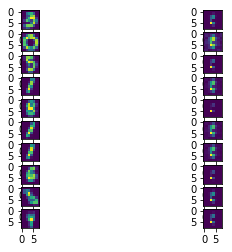

In [37]:
fig, axes = plt.subplots(nrows=10, ncols=2)
to_transform = torch.cat((dataset1[:10][0],
                       dataset1[:10][1].float().view(-1, 1)), dim=1).cuda()
transformed = T(to_transform).detach().cpu()
for i, ax in enumerate(axes):
    ax[0].imshow(dataset1[i][0].view(8, 8))
    ax[1].imshow(transformed[i].view(8, 8))

In [38]:
Xi(dataset1[:10][0].cuda())

tensor([[9.3690e-10],
        [3.7688e-08],
        [3.3977e-06],
        [2.4187e-06],
        [7.7223e-11],
        [3.2103e-07],
        [2.8919e-07],
        [5.2551e-10],
        [7.9777e-06],
        [1.2021e-06]], device='cuda:0', grad_fn=<SoftplusBackward>)

In [39]:
lv1 = np.array(lv1)
lv2 = np.array(lv2)

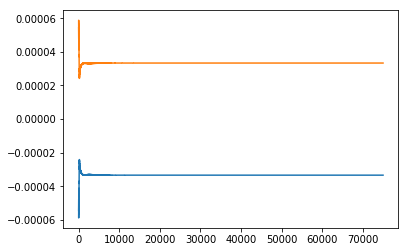

In [40]:
plt.plot(lv1)
plt.plot(lv2)